# Análisis Predictivo de Pagos de Clientes

**Candidata: Dafne Castellanos Rosas**

---

## Tabla de Contenido

1. [Introducción](#1.-Introducción)
2. [Carga y Exploración Inicial de Datos](#2.-Carga-y-Exploración-Inicial-de-Datos)
3. [Análisis Exploratorio de Datos (EDA)](#3.-Análisis-Exploratorio-de-Datos-(EDA))
   - 3.1. Análisis Univariado
   - 3.2. Análisis Bivariado
   - 3.3. Distribución de la variable objetivo en el tiempo
4. [Preprocesamiento de Datos](#4.-Preprocesamiento-de-Datos)
   - 4.1. Recategorización de variables categóricas
   - 4.2. Tratamiento de duplicados
   - 4.3. Preprocesamiento con flags de imputación
5. [Modelos Base](#5.-Modelos-Base)
6. [Selección de Variables (Feature Selection)](#6.-Selección-de-Variables)
7. [Modelos con Variables Seleccionadas](#7.-Modelos-con-Variables-Seleccionadas)
8. [Manejo de Desbalanceo de Clases](#8.-Manejo-de-Desbalanceo-de-Clases)
9. [Selección del Mejor Modelo](#9.-Selección-del-Mejor-Modelo)
10. [Análisis de Importancia de Características y SHAP Values](#10.-Análisis-de-Importancia-de-Características)
11. [Conclusiones y Próximos Pasos](#11.-Conclusiones-y-Próximos-Pasos)
12. [Sentencias SQL](#12.-Sentencias-SQL)

---

## 1. Introducción

Este cuaderno implementa un flujo completo de ciencia de datos para predecir la probabilidad de pago de clientes. El proceso incluye:

1. **Análisis Exploratorio de Datos (EDA)**
2. **Preprocesamiento de Datos**
3. **Modelado Predictivo**
4. **Evaluación y Análisis de Resultados**

### Configuración Inicial

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Importación de bibliotecas
import os
import sys
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from IPython.display import display, Markdown

# Configuración de visualización
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Configuración de pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Añadir el directorio src al path
project_dir = Path().resolve().parent
src_dir = project_dir / 'src'
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))

# Importar módulos personalizados
from data import load_data, validate_dataframe
from eda import (
    plot_missing_values, 
    plot_target_distribution,
    plot_numerical_distributions,
    plot_categorical_distributions,
    plot_correlation_matrix,
    plot_outliers_boxplot,
    plot_bivariate_numerical_vs_target,
    plot_bivariate_categorical_vs_target,
    calculate_bivariate_statistics,
    plot_payment_distribution_by_month
)

# Configuración de rutas
data_path = project_dir / 'data' / 'PruebaDS.xlsx'
output_dir = project_dir / 'outputs'
output_dir.mkdir(exist_ok=True)
figures_dir = output_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

print('✅ Entorno configurado correctamente')

✅ Entorno configurado correctamente


## 2. Carga y Exploración Inicial de Datos

En esta sección, cargaremos el conjunto de datos y realizaremos una exploración inicial para entender su estructura y calidad.

In [4]:
# Cargar datos
print(f'📂 Cargando datos desde: {data_path}')

exempt_fields = ['identificacion', 'mes']

try:
    df = load_data(data_path, exempt_fields=exempt_fields)
    print(f'✅ Datos cargados correctamente. Dimensiones: {df.shape}')
except Exception as e:
    print(f'❌ Error al cargar los datos: {e}')
    raise

# Mostrar información básica
display(Markdown('### Información del Dataset'))
display(Markdown(f'- **Número de filas:** {df.shape[0]}'))
display(Markdown(f'- **Número de columnas:** {df.shape[1]}'))
display(Markdown(f'- **Variables numéricas:** {len(df.select_dtypes(include=['int64', 'float64']).columns)}'))
display(Markdown(f'- **Variables categóricas:** {len(df.select_dtypes(include=['object', 'category', 'bool']).columns)}'))

# Mostrar primeras filas
display(Markdown('### Vista previa de los datos:'))
display(df.head())

# Mostrar información de tipos de datos y valores nulos
display(Markdown('### Tipos de datos y valores nulos:'))
df_info = pd.DataFrame({
    'Tipo': df.dtypes,
    'Valores nulos': df.isnull().sum(),
    '% Valores nulos': (df.isnull().mean() * 100).round(2),
    'Valores únicos': df.nunique()
})
display(df_info)

# Estadísticas descriptivas
display(Markdown('### Estadísticas descriptivas (variables numéricas):'))
display(df.describe().T)

2026-02-20 08:24:39,264 - INFO - Intentando cargar el archivo: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\data\PruebaDS.xlsx
2026-02-20 08:24:39,265 - INFO - Cargando el archivo Excel...


📂 Cargando datos desde: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\data\PruebaDS.xlsx


2026-02-20 08:24:43,687 - WARNING - Advertencia: La columna 'antiguedad_deuda' tiene una alta tasa de valores faltantes: 71.24%
2026-02-20 08:24:43,688 - WARNING - Advertencia: La columna 'meses_desde_ultimo_pago' tiene una alta tasa de valores faltantes: 98.39%
2026-02-20 08:24:43,688 - WARNING - Advertencia: Se encontraron 4 filas duplicadas
2026-02-20 08:24:43,691 - INFO - Reporte de calidad guardado en: outputs\data_quality_report.json



RESUMEN DE CALIDAD DE DATOS
Archivo: PruebaDS.xlsx
Filas: 29613, Columnas: 18
Valores faltantes: 72933 (13.68%)
Filas duplicadas: 4

Columnas con mayor porcentaje de valores faltantes:
  - meses_desde_ultimo_pago: 98.39%
  - antiguedad_deuda: 71.24%
  - departamento: 26.30%
  - genero: 25.44%
  - rango_edad_probable: 24.91%

Advertencias:
  - La columna 'antiguedad_deuda' tiene una alta tasa de valores faltantes: 71.24%
  - La columna 'meses_desde_ultimo_pago' tiene una alta tasa de valores faltantes: 98.39%
  - Se encontraron 4 filas duplicadas


✅ Datos cargados correctamente. Dimensiones: (29613, 18)


### Información del Dataset

- **Número de filas:** 29613

- **Número de columnas:** 18

- **Variables numéricas:** 11

- **Variables categóricas:** 6

### Vista previa de los datos:

mes tipo_documento  identificacion  genero rango_edad_probable  \
0  2025-10              C          499220  HOMBRE               56-60   
1  2025-04              C          365960  HOMBRE               51-55   
2  2025-04              C          608458                       31-35   
3  2025-09              C          159935       M                 66+   
4  2025-12              C          322934   MUJER               66-70   

   departamento  saldo_capital  dias_mora       banco antiguedad_deuda  \
0     BOGOTA DC    2619298.740       3411    citibank              NaT   
1        CALDAS    4760221.000       2630   colpatria       2017-10-21   
2  CUNDINAMARCA    2329327.000       1092  davivienda              NaT   
3     ATLANTICO    7784362.000        564  davivienda              NaT   
4          META    8811594.140       2774   colpatria              NaT   

   pago_mes_anterior  meses_desde_ultimo_pago  sin_pago_previo  \
0                  0                      NaN                1   
1                  0                      NaN                1   
2                  0                      NaN                1   
3                  0                      NaN                1   
4                  0                      NaN                1   

   contacto_mes_actual  contacto_mes_anterior  contacto_ultimos_6meses  \
0                    0                      0                        0   
1                    0                      0                        0   
2                    0                      0                        0   
3                    0                      0                        1   
4                    0                      0                        0   

   duracion_llamadas_ultimos_6meses  pago  
0                                 0     0  
1                                 0     0  
2                                 0     0  
3                               224     0  
4                                 0     0

### Tipos de datos y valores nulos:

Tipo  Valores nulos  \
mes                                          str              0   
tipo_documento                               str              0   
identificacion                             int64              0   
genero                                       str           7534   
rango_edad_probable                          str           7378   
departamento                                 str           7789   
saldo_capital                            float64              0   
dias_mora                                  int64              0   
banco                                        str              0   
antiguedad_deuda                  datetime64[us]          21097   
pago_mes_anterior                          int64              0   
meses_desde_ultimo_pago                  float64          29135   
sin_pago_previo                            int64              0   
contacto_mes_actual                        int64              0   
contacto_mes_anterior                      int64              0   
contacto_ultimos_6meses                    int64              0   
duracion_llamadas_ultimos_6meses           int64              0   
pago                                       int64              0   

                                  % Valores nulos  Valores únicos  
mes                                         0.000              12  
tipo_documento                              0.000               4  
identificacion                              0.000           23837  
genero                                     25.440               6  
rango_edad_probable                        24.910              26  
departamento                               26.300              31  
saldo_capital                               0.000           25295  
dias_mora                                   0.000            3230  
banco                                       0.000               5  
antiguedad_deuda                           71.240            1102  
pago_mes_anterior                           0.000               2  
meses_desde_ultimo_pago                    98.390               8  
sin_pago_previo                             0.000               2  
contacto_mes_actual                         0.000               2  
contacto_mes_anterior                       0.000               2  
contacto_ultimos_6meses                     0.000               2  
duracion_llamadas_ultimos_6meses            0.000            1662  
pago                                        0.000               2

### Estadísticas descriptivas (variables numéricas):

count                        mean  \
identificacion                   29613.000                  550555.405   
saldo_capital                    29613.000                 5728032.906   
dias_mora                        29613.000                    1621.957   
antiguedad_deuda                      8516  2017-08-27 16:29:32.099577   
pago_mes_anterior                29613.000                       0.007   
meses_desde_ultimo_pago            478.000                       1.874   
sin_pago_previo                  29613.000                       0.984   
contacto_mes_actual              29613.000                       0.103   
contacto_mes_anterior            29613.000                       0.103   
contacto_ultimos_6meses          29613.000                       0.175   
duracion_llamadas_ultimos_6meses 29613.000                     109.743   
pago                             29613.000                       0.018   

                                                  min                  25%  \
identificacion                             100049.000           328400.000   
saldo_capital                                 500.000          1202586.000   
dias_mora                                       0.000              647.000   
antiguedad_deuda                  1997-06-18 00:00:00  2017-04-18 12:00:00   
pago_mes_anterior                               0.000                0.000   
meses_desde_ultimo_pago                         1.000                1.000   
sin_pago_previo                                 0.000                1.000   
contacto_mes_actual                             0.000                0.000   
contacto_mes_anterior                           0.000                0.000   
contacto_ultimos_6meses                         0.000                0.000   
duracion_llamadas_ultimos_6meses                0.000                0.000   
pago                                            0.000                0.000   

                                                  50%                  75%  \
identificacion                             549140.000           776037.000   
saldo_capital                             2356254.090          6170198.000   
dias_mora                                    1450.000             2517.000   
antiguedad_deuda                  2017-11-30 00:00:00  2018-05-29 00:00:00   
pago_mes_anterior                               0.000                0.000   
meses_desde_ultimo_pago                         2.000                2.000   
sin_pago_previo                                 1.000                1.000   
contacto_mes_actual                             0.000                0.000   
contacto_mes_anterior                           0.000                0.000   
contacto_ultimos_6meses                         0.000                0.000   
duracion_llamadas_ultimos_6meses                0.000                0.000   
pago                                            0.000                0.000   

                                                  max         std  
identificacion                             999995.000  259375.513  
saldo_capital                           113158433.840 8859934.136  
dias_mora                                   10031.000    1047.757  
antiguedad_deuda                  2028-08-08 00:00:00         NaN  
pago_mes_anterior                               1.000       0.083  
meses_desde_ultimo_pago                         8.000       1.105  
sin_pago_previo                                 1.000       0.126  
contacto_mes_actual                             1.000       0.304  
contacto_mes_anterior                           1.000       0.304  
contacto_ultimos_6meses                         1.000       0.380  
duracion_llamadas_ultimos_6meses            14266.000     484.154  
pago                                            1.000       0.132

## 3. Análisis Exploratorio de Datos (EDA)

En esta sección, exploraremos los datos para entender mejor sus características, distribuciones y relaciones entre variables.

### 3.1.  Univariado

### 3.1.1. Valores Faltantes

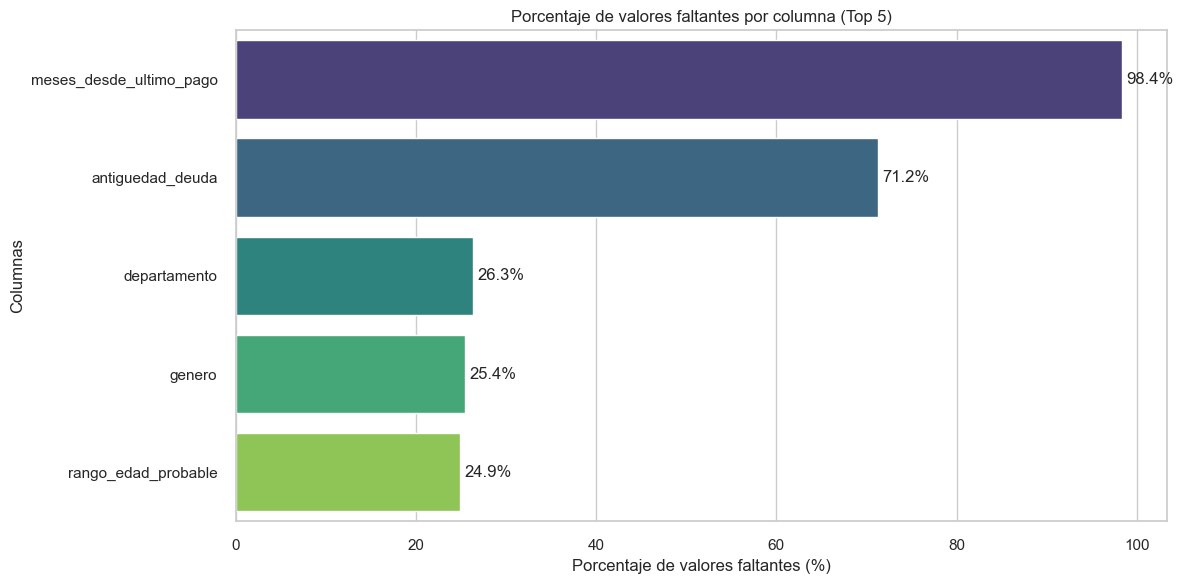

### 3.1.2. Distribución de la Variable Objetivo (pago)

2026-02-20 08:24:50,531 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 08:24:50,537 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


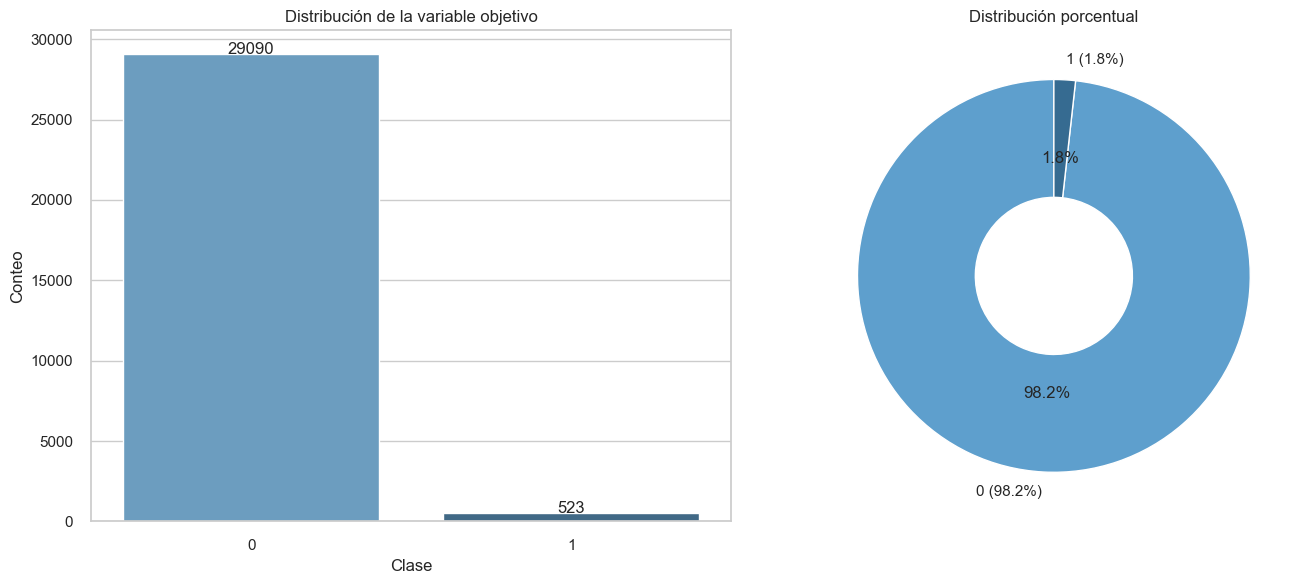

**Distribución de clases:** 98.2% No Pago vs 1.8% Pago

### 3.1.3. Distribuciones de Variables Numéricas

2026-02-20 08:24:51,333 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 08:24:51,338 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 08:24:51,404 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 08:24:51,410 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 08:24:51,431 - INFO - Using categorical units to plot a list of strings that are all parsable as 

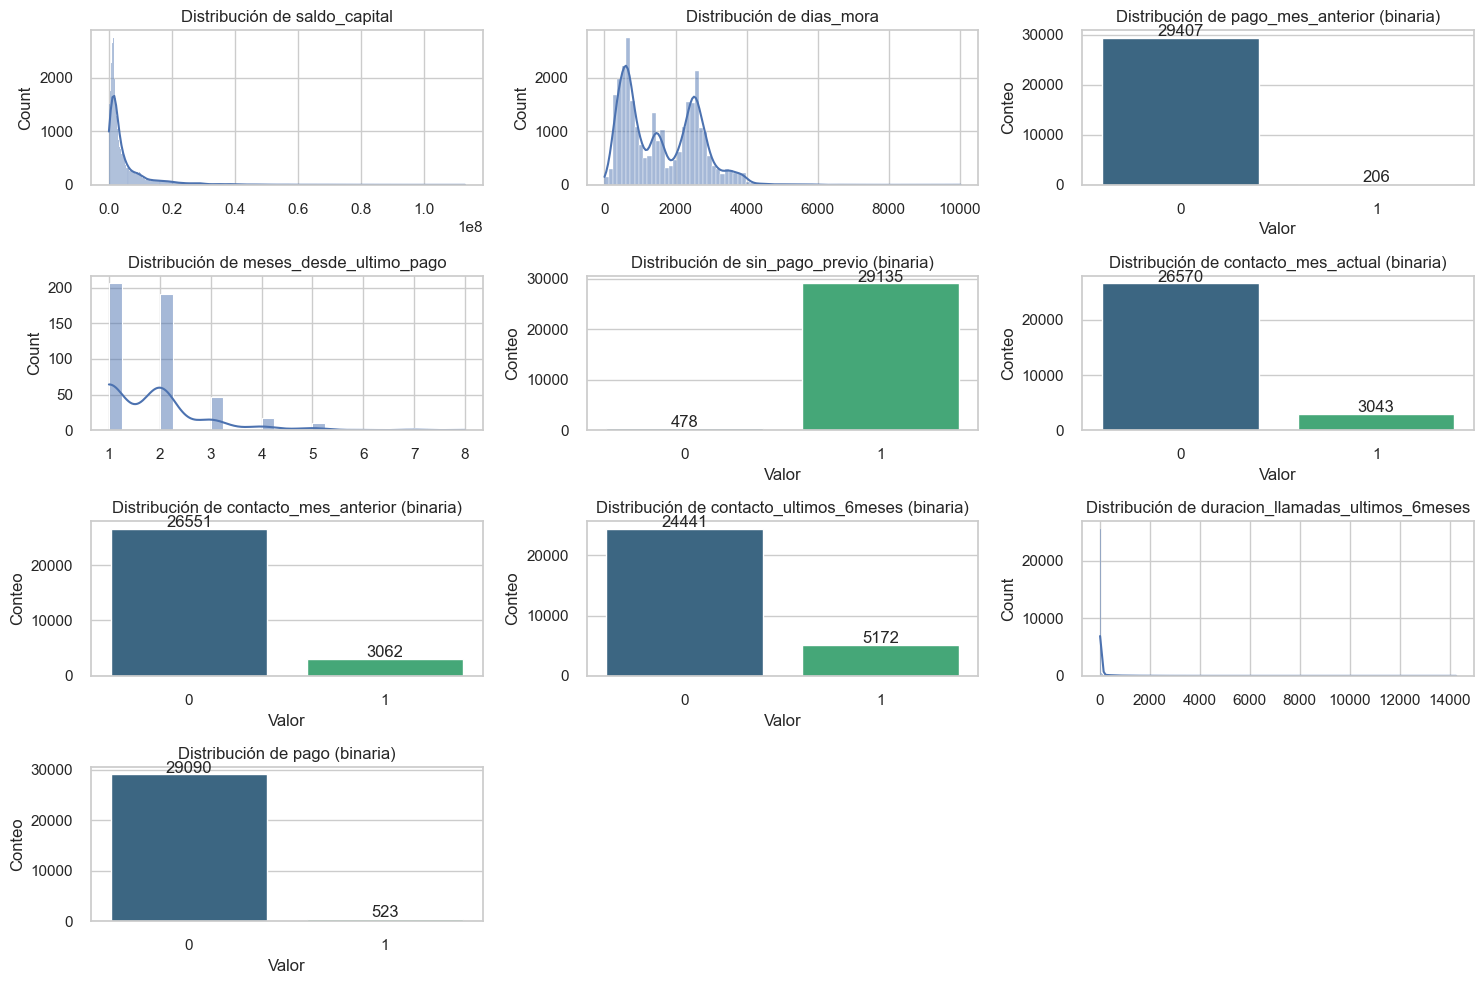

### 3.1.4. Distribuciones de Variables Categóricas

2026-02-20 08:24:53,196 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 08:24:53,201 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


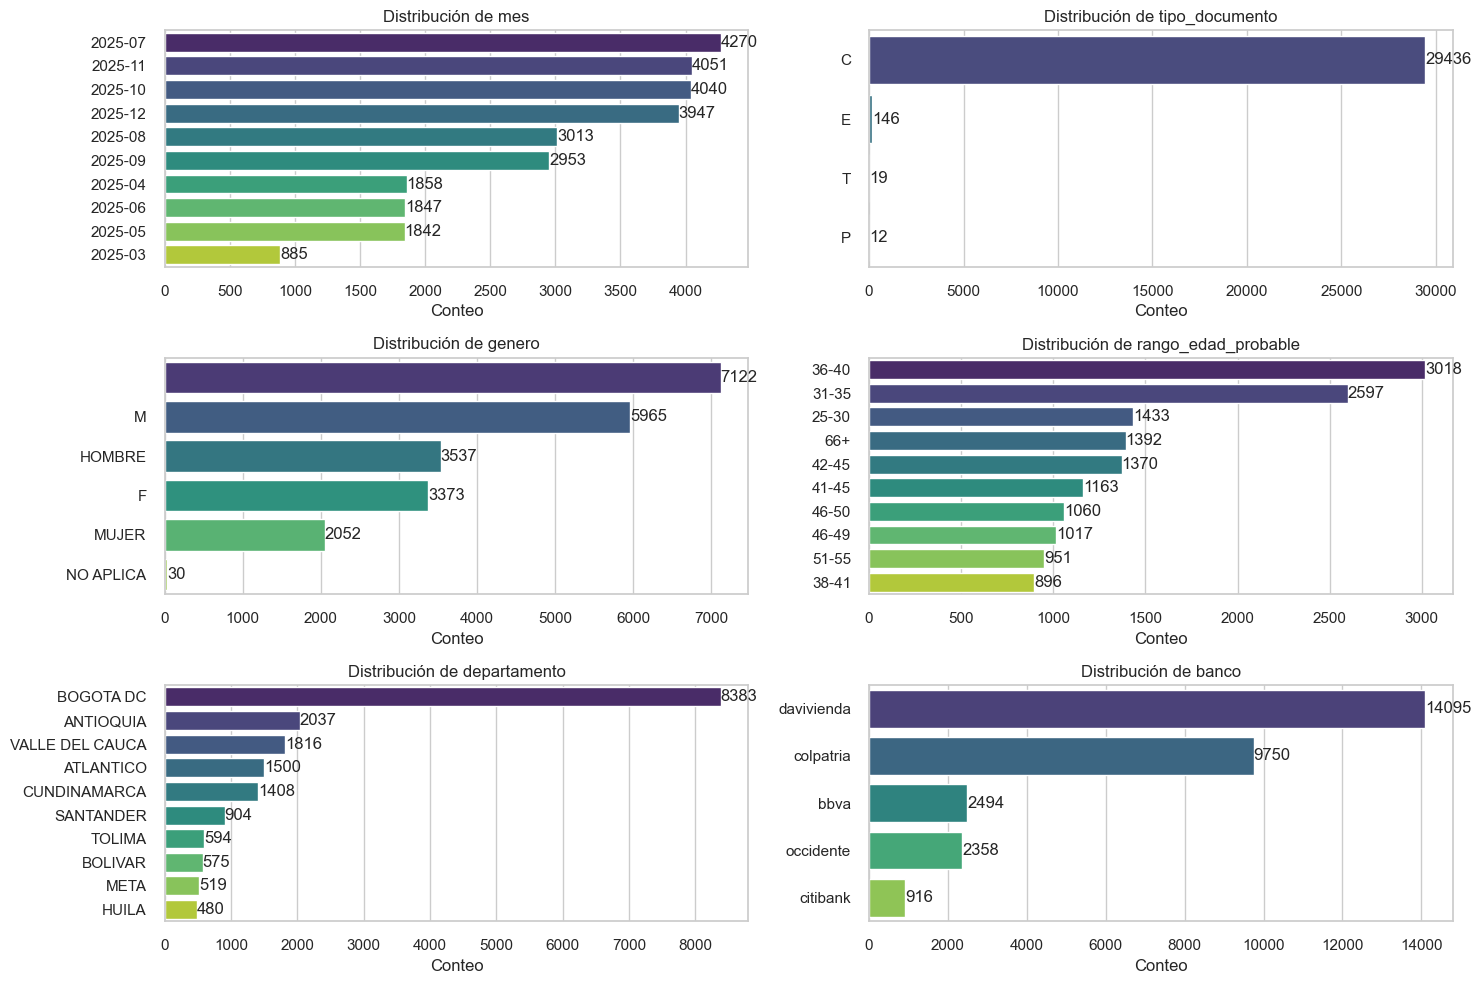

### 3.1.5. Matriz de Correlación

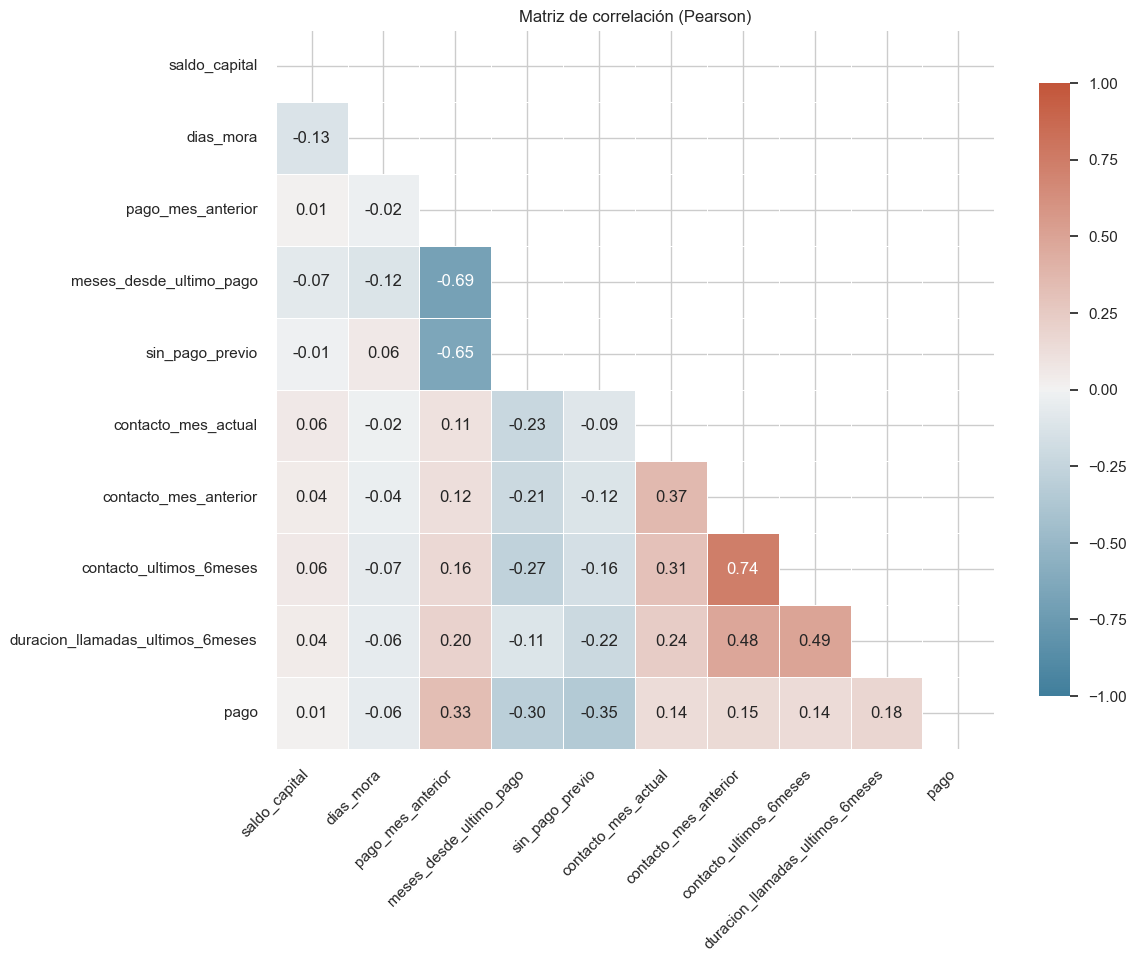

### 3.1.6. Detección de Outliers

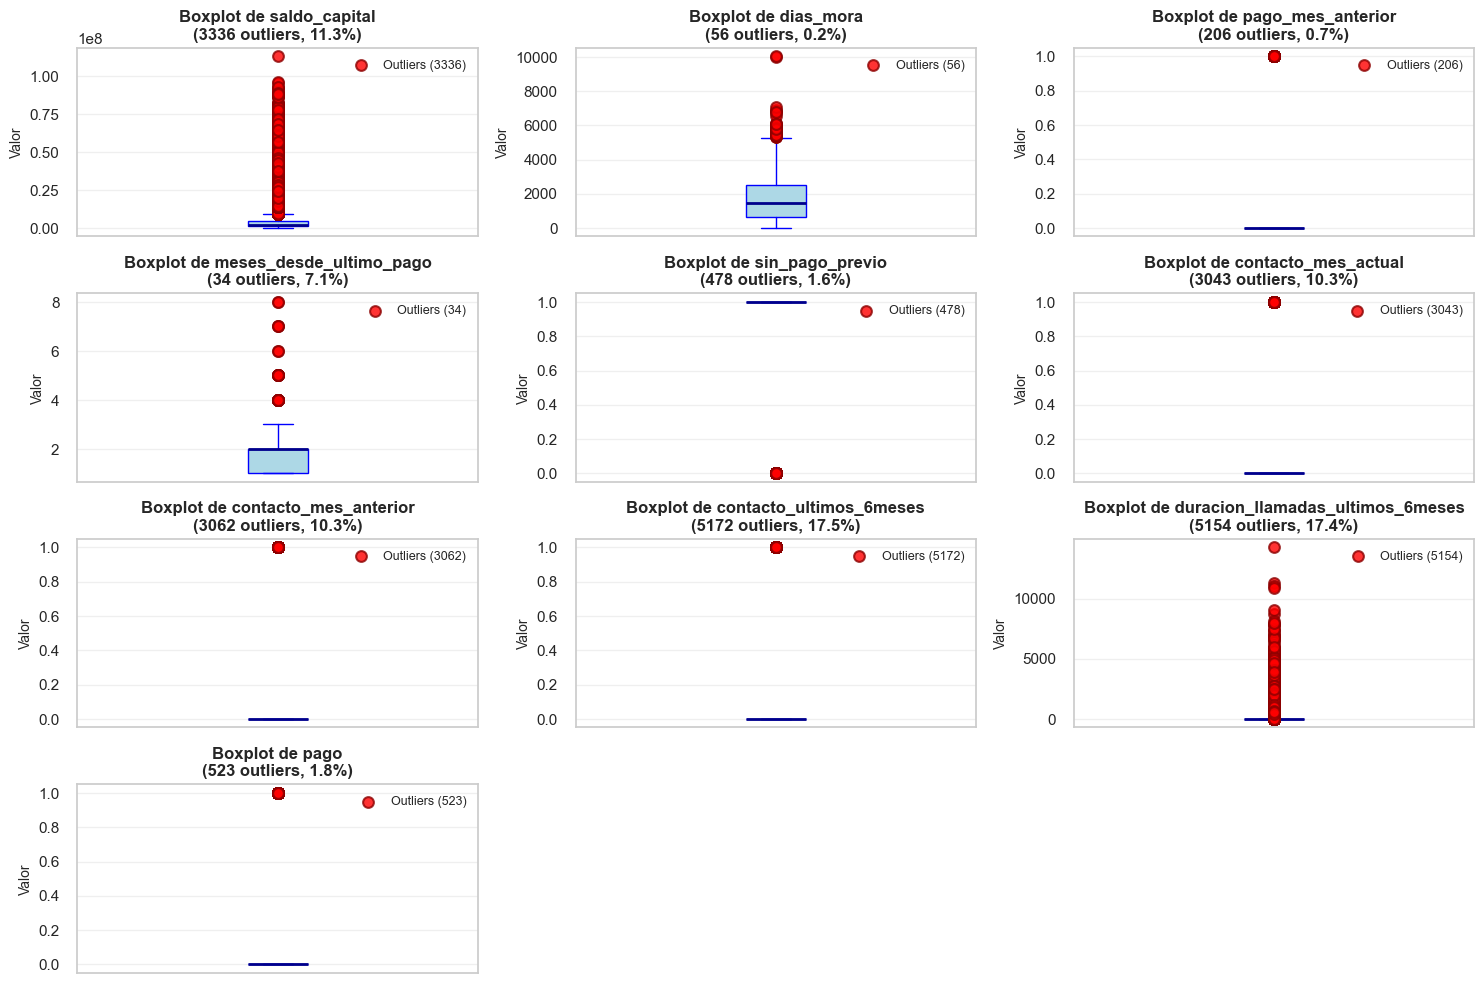

In [5]:
# 3.1.1. Análisis de Valores Faltantes
display(Markdown('### 3.1.1. Valores Faltantes'))
fig_missing = plot_missing_values(df)
plt.show()
fig_missing.savefig(figures_dir / 'missing_values.png', bbox_inches='tight')

# 3.1.2. Análisis de la Variable Objetivo
if 'pago' in df.columns:
    display(Markdown('### 3.1.2. Distribución de la Variable Objetivo (pago)'))
    fig_target = plot_target_distribution(df['pago'])
    plt.show()
    fig_target.savefig(figures_dir / 'target_distribution.png', bbox_inches='tight')
    
    # Calcular desbalance de clases
    class_balance = df['pago'].value_counts(normalize=True) * 100
    display(Markdown(f'**Distribución de clases:** {class_balance[0]:.1f}% No Pago vs {class_balance[1]:.1f}% Pago'))

# 3.1.3. Análisis de Variables Numéricas
display(Markdown('### 3.1.3. Distribuciones de Variables Numéricas'))
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'pago' in num_cols:
    num_cols.remove('pago')
    
if num_cols:
    fig_num = plot_numerical_distributions(df[num_cols + (['pago'] if 'pago' in df.columns else [])], exempt_fields=exempt_fields)
    plt.show()
    fig_num.savefig(figures_dir / 'numerical_distributions.png', bbox_inches='tight')

# 3.1.4. Análisis de Variables Categóricas
display(Markdown('### 3.1.4. Distribuciones de Variables Categóricas'))

fig_cat = plot_categorical_distributions(df)
plt.show()
fig_cat.savefig(figures_dir / 'categorical_distributions.png', bbox_inches='tight')


# 3.1.5. Análisis de Correlaciones
display(Markdown('### 3.1.5. Matriz de Correlación'))
fig_corr = plot_correlation_matrix(df, exempt_fields=exempt_fields)
if fig_corr:
    plt.show()
    fig_corr.savefig(figures_dir / 'correlation_matrix.png', bbox_inches='tight')

# 3.1.6. Detectar Outliers
display(Markdown('### 3.1.6. Detección de Outliers'))
fig = plot_outliers_boxplot(df, exempt_fields=['identificacion'])
plt.show()
fig.savefig(figures_dir / 'outliers_boxplot.png', bbox_inches='tight')

### 3.2. Bivariado

### 3.2.1. Hallazgos Principales del Análisis Bivariado

#### 1. Drivers principales de pago
El análisis revela que **las variables relacionadas con la interacción reciente con el cliente** son los principales predictores del pago.  
Variables como `duracion_llamadas_ultimos_6meses`, `contacto_ultimos_6meses`, `contacto_mes_anterior` y `contacto_mes_actual` presentan **valores altos de AUC** (0.73–0.66), indicando que la gestión activa de cobranza tiene un impacto significativo en la probabilidad de pago.

#### 2. Comportamiento histórico
Algunas variables de **comportamiento pasado**, como `pago_mes_anterior`, `sin_pago_previo` y `meses_desde_ultimo_pago`, también muestran señal predictiva, aunque con menor magnitud que las variables de contacto reciente.  
Se observa que variables como `sin_pago_previo` y `meses_desde_ultimo_pago` presentan **relaciones inversas con el target** (AUC < 0.5), lo cual indica que mayores valores se asocian con menor probabilidad de pago.  
Se recomienda invertir estas variables o tratar los valores faltantes mediante flags para preservar su información.

#### 3. Variables demográficas y financieras
Entre las variables categóricas, destacan `rango_edad_probable`, `banco` y `genero` como significativas según el test Chi-Square (p-value < 0.001). Esto sugiere que factores demográficos y la entidad financiera influyen en la probabilidad de pago.  
Otras variables como `departamento` o `tipo_documento` no presentan relación significativa con el target y podrían considerarse para exclusión en modelos futuros.

#### 4. Calidad y disponibilidad de los datos
Algunas variables, como `meses_desde_ultimo_pago`, presentan **alto porcentaje de datos faltantes** (> 98%). Aunque esto limita la información directa, la parte de datos disponible todavía aporta señal relevante (MI = 0.04). Se recomienda crear indicadores de missing o imputar valores de manera estratégica.

#### 5. Consideraciones para modelado
Dado el **alto desbalance del target** (≈ 98% no pago), las métricas más informativas para evaluar variables son:
- **AUC**: evalúa la capacidad de discriminación de cada variable frente al target binario.
- **Mutual Information (MI)**: captura relaciones no lineales entre variables y target.
- La **correlación** lineal puede resultar engañosa y debe interpretarse con precaución.

> En resumen, el análisis bivariado identifica claramente los drivers de pago más relevantes, destaca la importancia de variables de contacto y comportamiento reciente, y proporciona guía sobre qué variables incluir y cómo tratarlas en futuros modelos predictivos de pago.

#### 3.2.1. Variables Numéricas vs Target

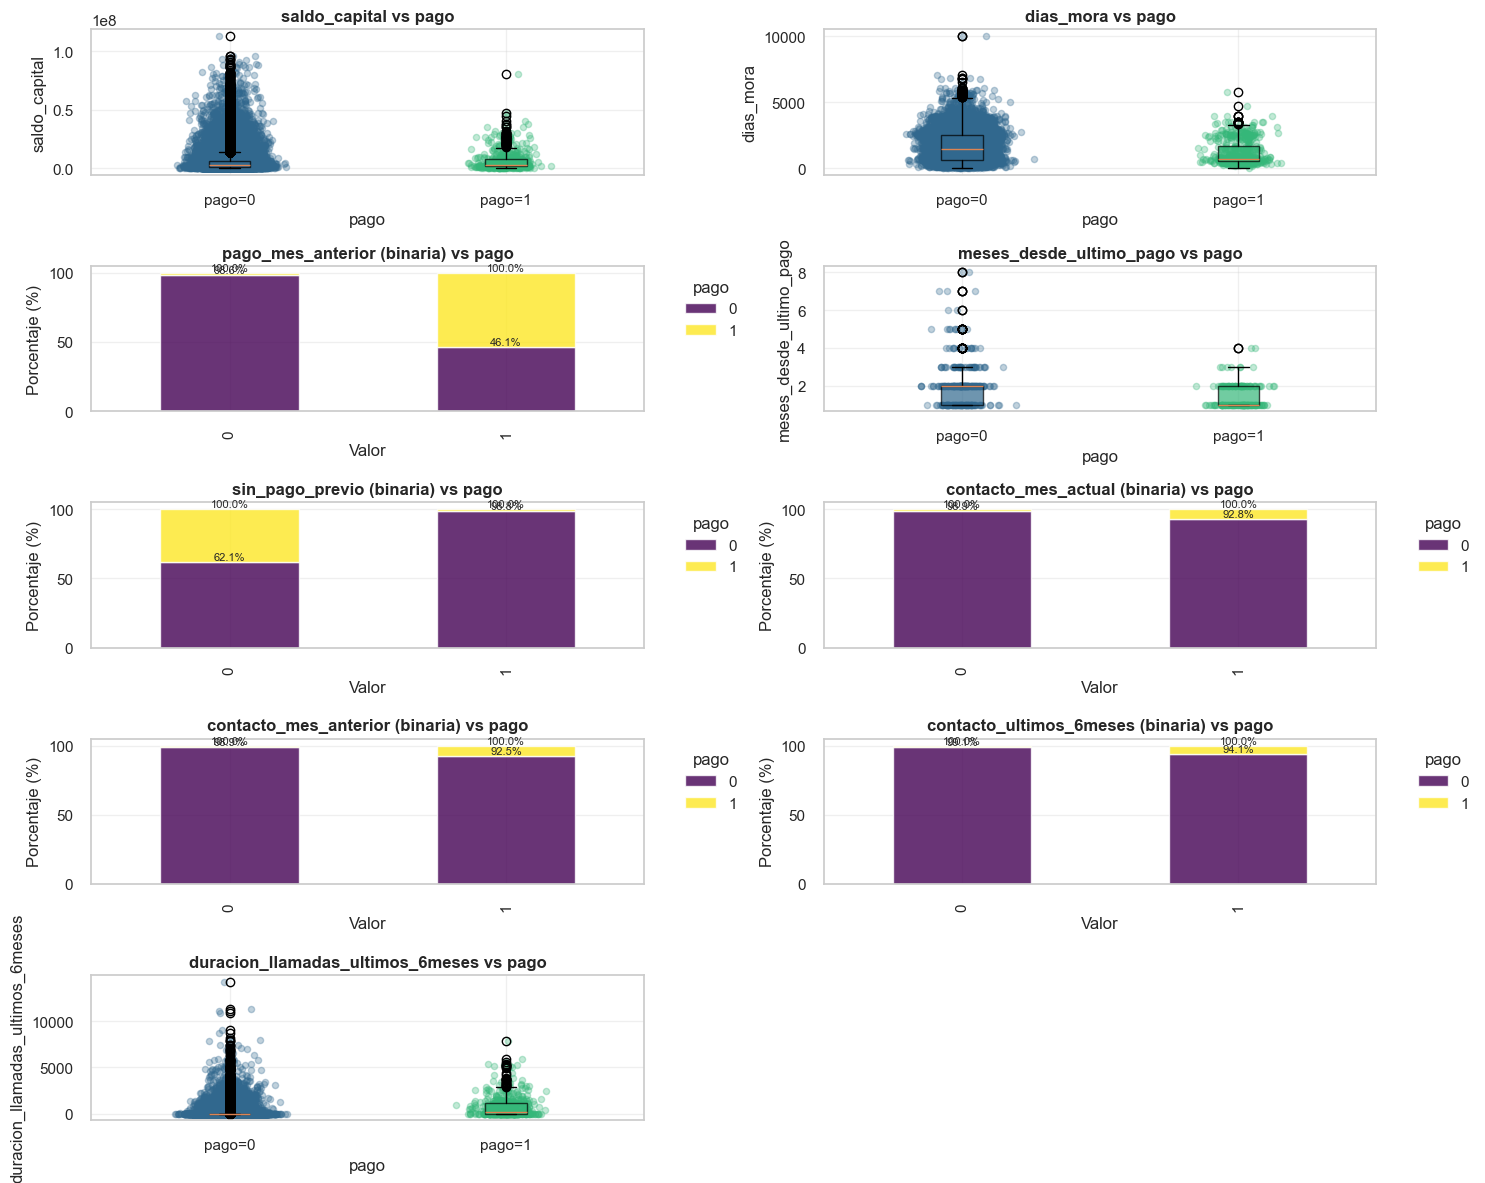

#### 3.2.2. Variables Categóricas vs Target

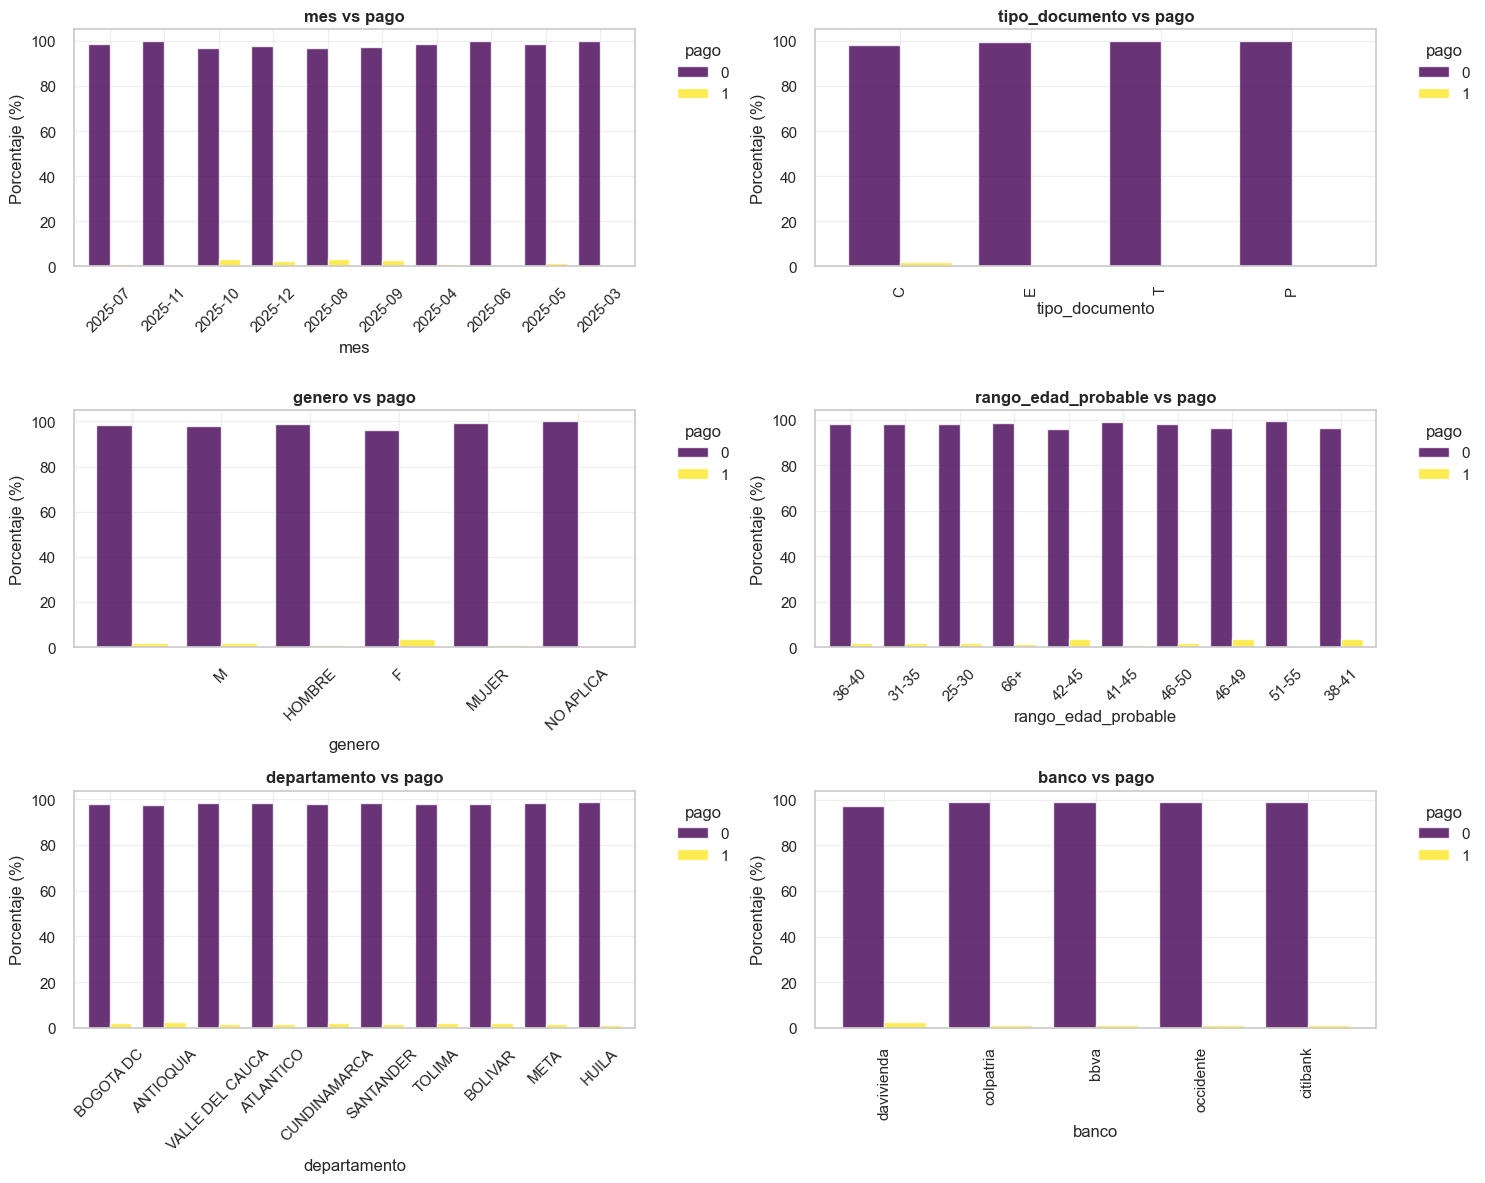

#### 3.2.3. Estadísticas Bivariadas

##### 3.2.3.1. Importancia de Variables Numéricas

auc mutual_information correlation  \
duracion_llamadas_ultimos_6meses 0.731              0.012       0.177   
contacto_ultimos_6meses          0.707              0.008       0.144   
contacto_mes_anterior            0.672              0.006       0.149   
contacto_mes_actual              0.661              0.006       0.140   
pago_mes_anterior                0.604              0.010       0.331   
saldo_capital                    0.548              0.002       0.010   
dias_mora                        0.377              0.002      -0.055   
sin_pago_previo                  0.332              0.020      -0.351   
meses_desde_ultimo_pago          0.322              0.026      -0.302   

                                 missing_rate  
duracion_llamadas_ultimos_6meses        0.000  
contacto_ultimos_6meses                 0.000  
contacto_mes_anterior                   0.000  
contacto_mes_actual                     0.000  
pago_mes_anterior                       0.000  
saldo_capital                           0.000  
dias_mora                               0.000  
sin_pago_previo                         0.000  
meses_desde_ultimo_pago                 0.984

##### 3.2.3.2. Chi-Square Test para Variables Categóricas

chi2_statistic chi2_p_value mutual_information  \
rango_edad_probable        100.716        0.000              0.000   
banco                       99.820        0.000              0.005   
genero                      88.640        0.000              0.003   
departamento                18.069        0.957              0.000   
tipo_documento               1.550        0.671              0.000   

                    missing_rate  
rango_edad_probable        0.249  
banco                      0.000  
genero                     0.254  
departamento               0.263  
tipo_documento             0.000

In [6]:
# 3.2.1. Variables Numéricas vs Target
display(Markdown('#### 3.2.1. Variables Numéricas vs Target'))
fig_num_biv = plot_bivariate_numerical_vs_target(df, target_col='pago', exempt_fields=exempt_fields)
if fig_num_biv:
    plt.show()
    fig_num_biv.savefig(figures_dir / 'numerical_vs_target.png', bbox_inches='tight')

# 3.2.2. Variables Categóricas vs Target
display(Markdown('#### 3.2.2. Variables Categóricas vs Target'))
fig_cat_biv = plot_bivariate_categorical_vs_target(df, target_col='pago')
if fig_cat_biv:
    plt.show()
    fig_cat_biv.savefig(figures_dir / 'categorical_vs_target.png', bbox_inches='tight')

# 3.2.3. Estadísticas Bivariadas
display(Markdown('#### 3.2.3. Estadísticas Bivariadas'))
bivariate_stats = calculate_bivariate_statistics(df, target_col='pago', exempt_fields=exempt_fields)

# Mostrar importancia para variables numéricas
display(Markdown('##### 3.2.3.1. Importancia de Variables Numéricas'))

num_stats = bivariate_stats['numerical_analysis']
num_df = pd.DataFrame(num_stats).T

if not num_df.empty:
    # Ordenar según el tipo de métrica disponible
    if 'auc' in num_df.columns:
        num_df = num_df.sort_values(by='auc', ascending=False)
        display(num_df[['auc', 'mutual_information', 'correlation', 'missing_rate']].head(20))
    
    elif 'correlation' in num_df.columns:
        num_df['abs_corr'] = num_df['correlation'].abs()
        num_df = num_df.sort_values(by='abs_corr', ascending=False)
        display(num_df[['correlation', 'mutual_information', 'missing_rate']].head(20))
    
    else:
        display(num_df.head(20))
else:
    display("No hay variables numéricas analizadas")

# Mostrar estadísticas chi-square para variables categóricas
display(Markdown('##### 3.2.3.2. Chi-Square Test para Variables Categóricas'))
cat_stats = bivariate_stats['categorical_analysis']
cat_df = pd.DataFrame(cat_stats).T

if not cat_df.empty:
    if 'chi2_statistic' in cat_df.columns:
        cat_df = cat_df.sort_values(by='chi2_statistic', ascending=False)
    
    display(cat_df[['chi2_statistic', 'chi2_p_value', 'mutual_information', 'missing_rate']].head(20))
else:
    display("No hay variables categóricas analizadas")

### 3.3. Distribución de variable objetivo en el tiempo

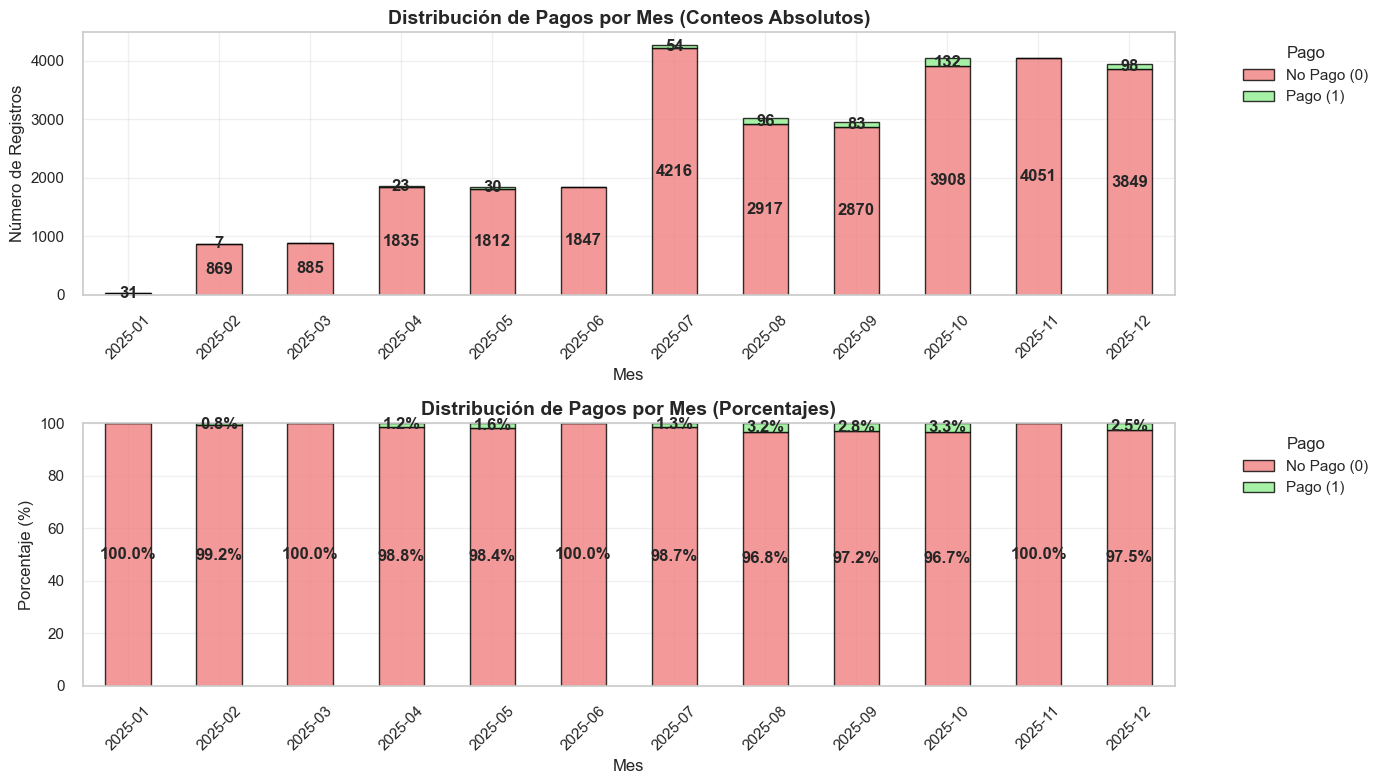

In [7]:
# Distribución completa por mes
fig_pay_in_time = plot_payment_distribution_by_month(df)
plt.show()
fig_pay_in_time.savefig('payment_distribution_by_month.png')

## 4. Preprocesamiento de Datos

En esta sección, preprocesaremos los datos para prepararlos para el modelado, incluyendo:
- Recategorización de variables categoricas
- Tratamiento de duplicados
- División en conjuntos de entrenamiento y prueba (Se hace este paso antes para evitar data leakage)
- Manejo de valores faltantes (Creación de variables flags_imputados)
- Escalado de características
- Codificación de variables categóricas

### 4.1. Recategorización de variables categoricas

In [8]:
# Seleccionar variables de tipo object o category
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)
for col in categorical_cols[1:]:
    print(f"Columna: {col}")
    print(df[col].value_counts(dropna=False))
    print('-'*30)

Index(['mes', 'tipo_documento', 'genero', 'rango_edad_probable',
       'departamento', 'banco'],
      dtype='str')
Columna: tipo_documento
tipo_documento
C    29436
E      146
T       19
P       12
Name: count, dtype: int64
------------------------------
Columna: genero
genero
NaN          7534
             7122
M            5965
HOMBRE       3537
F            3373
MUJER        2052
NO APLICA      30
Name: count, dtype: int64
------------------------------
Columna: rango_edad_probable
rango_edad_probable
NaN          7378
36-40        3018
31-35        2597
25-30        1433
66+          1392
42-45        1370
41-45        1163
46-50        1060
46-49        1017
51-55         951
38-41         896
62-65         871
56-60         809
58-61         739
50-53         735
54-57         697
61-65         639
30-33         595
34-37         593
66-70         468
26-29         460
Mas de 75     218
71-75         190
18-25         165
22-25         125
NO APLICA      30
18-21           4
Na

In [9]:
# Recodificar columna genero
df['genero'] = df['genero'].replace({
    'M': 'HOMBRE',
    'F': 'MUJER'
})

# Convertir strings vacíos a NaN
df.loc[df['genero'].str.strip() == '', 'genero'] = np.nan

# Revisar resultado
print(df['genero'].value_counts(dropna=False))

genero
NaN          14656
HOMBRE        9502
MUJER         5425
NO APLICA       30
Name: count, dtype: int64


### 4.2. Tratamiento de duplicados

Durante el análisis exploratorio (EDA) se identificaron 4 filas duplicadas exactas en el dataset completo. Dado que representan registros completamente repetidos, se procederá a eliminarlas antes de continuar con el preprocesamiento y la división en conjuntos de entrenamiento y prueba.

In [10]:
# 1. Revisar duplicados completos
duplicados_totales = df.duplicated()
print(f'Total de filas duplicadas exactas: {duplicados_totales.sum()}')

# 2. Eliminar duplicados exactos
df = df.drop_duplicates()

Total de filas duplicadas exactas: 4


Al analizar la columna identificacion, se observó que 4,543 IDs tienen múltiples registros, lo cual es consistente con la estructura del dataset (cada fila corresponde a un mes o a un evento diferente para el mismo cliente). Por lo tanto, estos registros no se eliminarán, ya que representan información legítima y relevante para el análisis y modelado.

In [11]:
# 3. Revisar cantidad de registros por ID
registros_por_id = df.groupby('identificacion').size()
print(f'IDs con múltiples registros:\n{registros_por_id[registros_por_id > 1]}')

IDs con múltiples registros:
identificacion
100281    3
100934    2
101045    3
101287    2
101840    3
         ..
997852    3
998013    2
998327    2
998515    2
999744    3
Length: 4543, dtype: int64


### 4.3. Preprocesamiento de datos con flags de imputación

Se realiza:

1. División de los datos en **train/test** (previniendo data leakage)  
2. Creación de **flags de imputación** 
3. Escalado de variables numéricas  
4. Codificación de variables categóricas con OneHotEncoding  
5. Obtención de nombres de features finales  
6. Guardado del preprocesador para uso futuro

Dado que este proyecto se realiza como un caso de prueba, se decidió imputar los valores faltantes en las variables numéricas continuas utilizando la mediana de cada columna. Esta estrategia simple permite manejar los nulos sin introducir sesgos significativos en el análisis inicial. En futuras iteraciones, si se construyen modelos más robustos, se podrán implementar técnicas de imputación más avanzadas, como KNN, regresión múltiple o algoritmos basados en árboles, que podrían capturar mejor la estructura de los datos y las correlaciones entre variables.

En cuanto a las variables categóricas, los valores faltantes se imputan con un valor constante (“missing”) y además se crean flags de imputación para registrar qué observaciones fueron imputadas. Posteriormente, estas variables se transforman mediante OneHotEncoding, generando columnas binarias que representan cada categoría y preservando la información de los datos originales para el modelado.

Las variables binarias con valores faltantes se imputan con 0 y se añade un flag para indicar los valores imputados. Esta aproximación permite a los modelos diferenciar entre registros reales y faltantes, manteniendo la información del patrón de ausencia y asegurando que los modelos seleccionados sean robustos frente a esta imputación en este caso de prueba.Para las variables binarias que contienen valores faltantes, se decidió imputar los NaN con 0 y generar un flag de imputación. Esta estrategia se eligió porque, al tratarse de indicadores binarios de eventos (por ejemplo, pago previo o contacto reciente), asumir que la ausencia de información equivale a “no ocurrió” (0) es una aproximación razonable en un caso de prueba. 

El flag permite al modelo diferenciar entre valores originales y valores imputados, evitando pérdida de información y permitiendo que los modelos capturen patrones potenciales asociados a la falta de registro. Dado que los modelos seleccionados (Logistic Regression, Random Forest, Gradient Boosting, XGBoost) son relativamente robustos frente a esta imputación, se garantiza que la performance inicial no se vea comprometida. En escenarios de producción, se podrían evaluar estrategias más sofisticadas de imputación para variables binarias si se observa que la cantidad de NaN afecta el desempeño.

In [21]:
from sklearn.model_selection import train_test_split
import importlib
import preprocessing
importlib.reload(preprocessing)

# Separar features y target
X = df.drop('pago', axis=1)
y = df['pago']

# Identificar tipos de variables
numeric_candidates = [col for col in X.select_dtypes(include=['int64', 'float64']).columns
                      if col not in exempt_fields]

# Detectar automáticamente binarias
binary_features = [col for col in numeric_candidates if X[col].dropna().nunique() == 2]

# El resto de numéricas continuas
numeric_features = [col for col in numeric_candidates if col not in binary_features]

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y
)

print("Columnas existentes: ", X_train.columns.tolist())


# Usar preprocesamiento manual
X_train_preprocessed, X_test_preprocessed, feature_names = preprocessing.manual_preprocessing(
    X_train, X_test,
    numeric_features=numeric_features,
    binary_features=binary_features,
    categorical_features=categorical_features
)
 
print(f"🎉 ¡PREPROCESAMIENTO EXITOSO!")
print(f"📊 Features creadas: {len(feature_names)}")
print(f"📊 Primeras 10 features: {feature_names[:10]}")


2026-02-20 08:41:43,871 - ERROR - Failed to read module file 'C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\src\preprocessing.py' for module 'preprocessing': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 556, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 5537: character maps to <undefined>


Columnas existentes:  ['mes', 'tipo_documento', 'identificacion', 'genero', 'rango_edad_probable', 'departamento', 'saldo_capital', 'dias_mora', 'banco', 'antiguedad_deuda', 'pago_mes_anterior', 'meses_desde_ultimo_pago', 'sin_pago_previo', 'contacto_mes_actual', 'contacto_mes_anterior', 'contacto_ultimos_6meses', 'duracion_llamadas_ultimos_6meses']
🔧 Iniciando preprocesamiento manual...
🔄 Procesando numéricas: ['saldo_capital', 'dias_mora', 'meses_desde_ultimo_pago', 'duracion_llamadas_ultimos_6meses']
✅ Numéricas procesadas
🔄 Procesando binarias: ['pago_mes_anterior', 'sin_pago_previo', 'contacto_mes_actual', 'contacto_mes_anterior', 'contacto_ultimos_6meses']
✅ Binarias procesadas
🔄 Procesando categóricas: ['mes', 'tipo_documento', 'genero', 'rango_edad_probable', 'departamento', 'banco']
✅ Categóricas procesadas
✅ Preprocesamiento completado
📊 Shape final - Train: (23687, 108), Test: (5922, 108)
🎉 ¡PREPROCESAMIENTO EXITOSO!
📊 Features creadas: 108
📊 Primeras 10 features: ['saldo_ca

## 5. Modelos Base

En esta sección, entrenaremos y evaluaremos distintos modelos de machine learning para predecir la probabilidad de pago. Primero se construyen los modelos base sin técnicas adicionales de balanceo, utilizando algoritmos como Regresión Logística, Random Forest, Gradient Boosting y XGBoost. Se aplican hiperparámetros que permiten manejar el desbalance de clases de manera básica, como class_weight='balanced' o scale_pos_weight. La evaluación de cada modelo se realizará mediante métricas clave de clasificación, incluyendo ROC AUC, Precision, Recall y F1, con el fin de comparar su desempeño inicial antes de aplicar técnicas avanzadas de balanceo o ajuste de hiperparámetros.

**Consideración Importante:**

Dado que el dataset está desbalanceado, la métrica principal que priorizaremos para evaluar los modelos es **ROC AUC**, ya que refleja la capacidad del modelo para **diferenciar correctamente entre pagos y no pagos** independientemente de la proporción de clases. En el futuro, se podrán evaluar también otras métricas como precisión, recall o F1 para obtener un panorama más completo del desempeño.

### Comparación de Modelos Base

A continuación se presentan las métricas de los modelos base entrenados **sin técnicas de balanceo**. Se observa un patrón típico en datasets desbalanceados: aunque la **accuracy** es alta para todos los modelos, esto se debe principalmente a la predominancia de la clase negativa. Las métricas enfocadas en la clase positiva (precision, recall y F1) muestran que ninguno de los modelos predice bien los pagos, confirmando la necesidad de técnicas de balanceo o ajuste de umbral.

| Modelo               | Accuracy | Precision | Recall | F1    | ROC AUC | PR AUC |
|---------------------|---------|----------|--------|-------|---------|--------|
| Gradient Boosting    | 0.983   | 0.567    | 0.162  | 0.252 | 0.889   | 0.305  |
| Regresión Logística  | 0.839   | 0.077    | 0.733  | 0.139 | 0.885   | 0.261  |
| XGBoost              | 0.959   | 0.203    | 0.448  | 0.279 | 0.869   | 0.306  |
| Random Forest        | 0.983   | 0.607    | 0.162  | 0.256 | 0.847   | 0.291  |

**Conclusión:** Los modelos capturan cierta discriminación (ROC AUC alto), pero la clase minoritaria no se predice adecuadamente (PR AUC y F1 bajos). Esto indica que es necesario aplicar **estrategias de balanceo** y ajuste de hiperparámetros para mejorar el desempeño sobre pagos.

🔍 Evaluando modelo: Regresión Logística


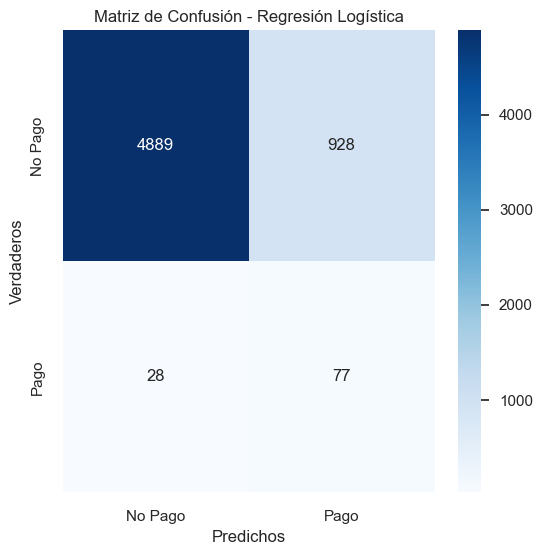

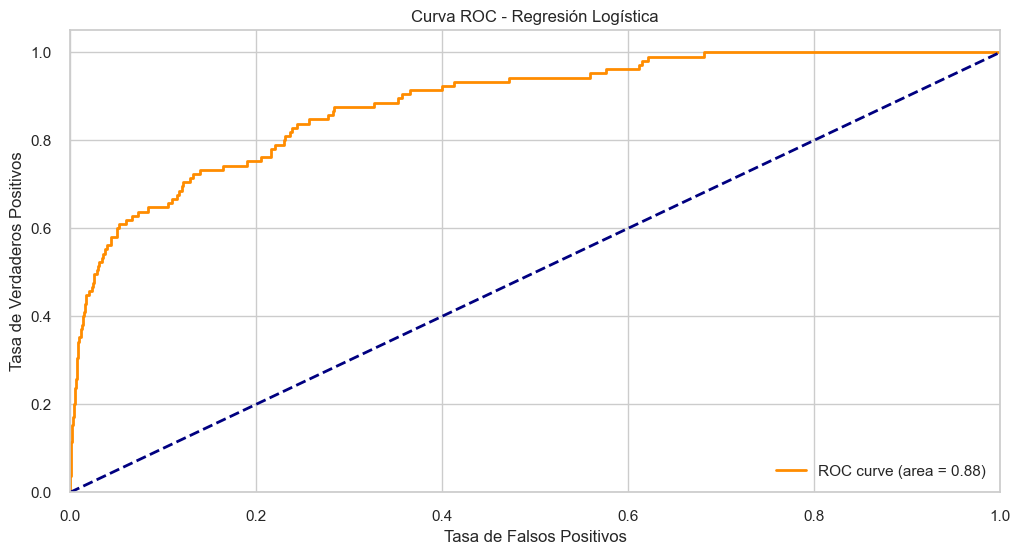

🔍 Evaluando modelo: Random Forest


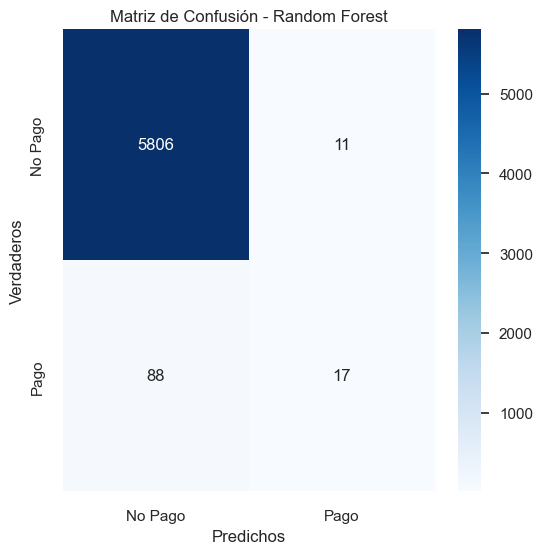

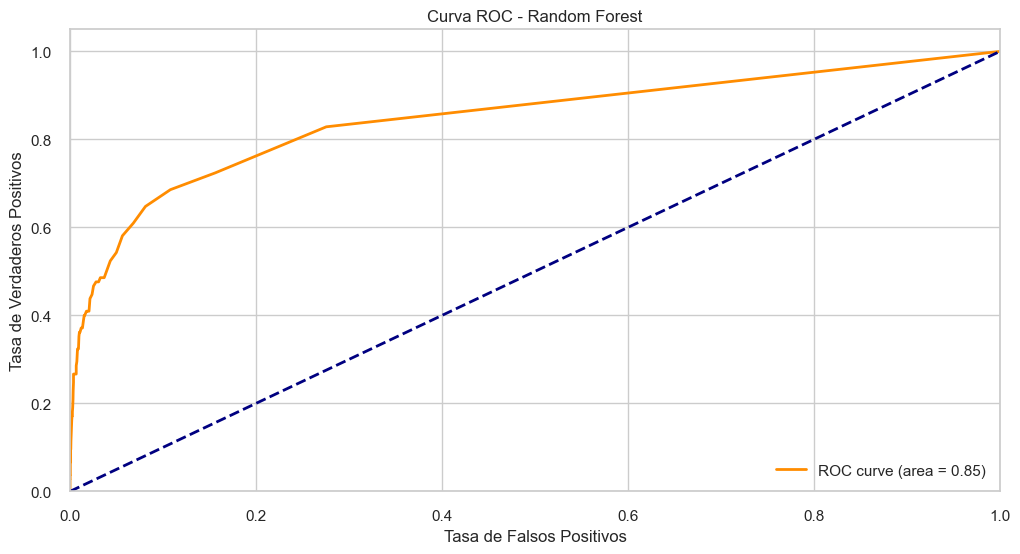

🔍 Evaluando modelo: Gradient Boosting


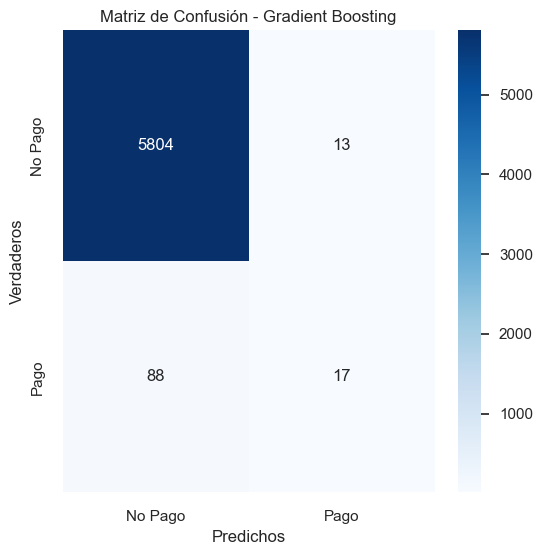

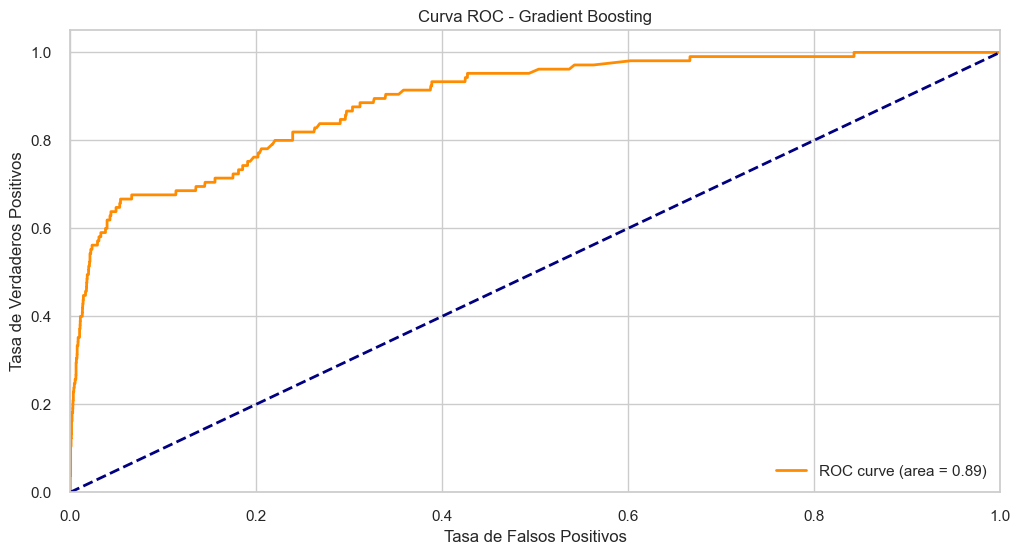

🔍 Evaluando modelo: XGBoost


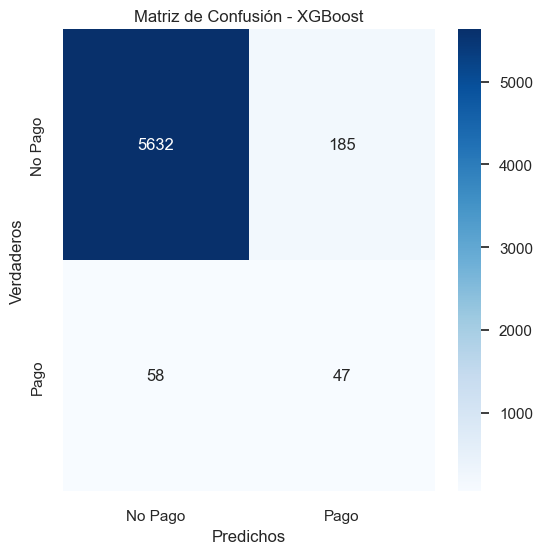

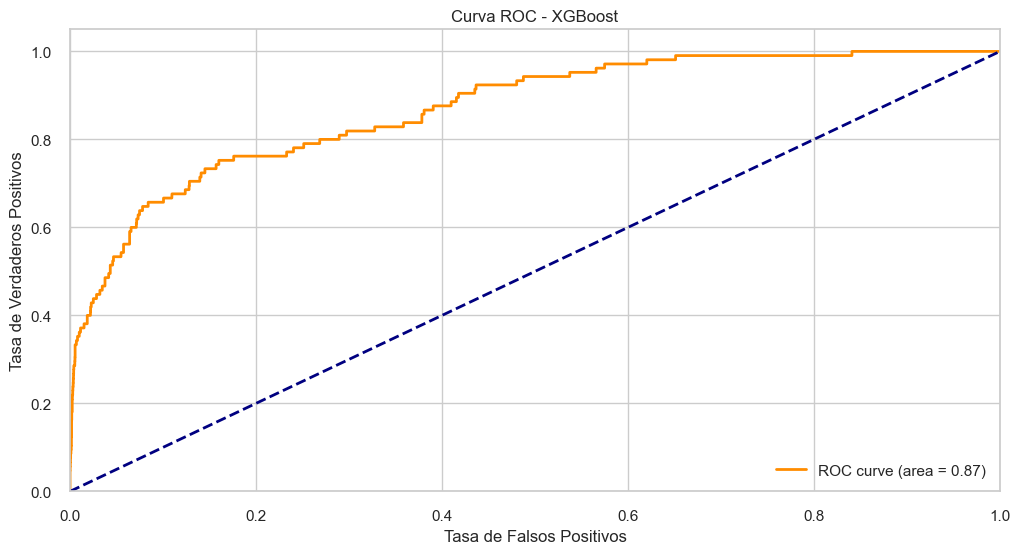

### Comparación de Modelos

accuracy  precision  recall    f1  roc_auc  pr_auc
Gradient Boosting       0.983      0.567   0.162 0.252    0.889   0.305
Regresión Logística     0.839      0.077   0.733 0.139    0.885   0.261
XGBoost                 0.959      0.203   0.448 0.279    0.869   0.306
Random Forest           0.983      0.607   0.162 0.256    0.847   0.291

✅ Mejor modelo guardado: Gradient Boosting en C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\outputs\best_model_sin_balanceo.joblib


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 5.1. Definir modelos a evaluar
models = {
    'Regresión Logística': LogisticRegression(random_state=15, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=15, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=15),
    'XGBoost': xgb.XGBClassifier(random_state=15, scale_pos_weight=sum(y==0)/sum(y==1) if sum(y==1) > 0 else 1)
}

# 5.2. Función para evaluar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predecir probabilidades
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predecir clases
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calcular métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5,
        'pr_auc': average_precision_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5
    }
    
    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Pago', 'Pago'],
                yticklabels=['No Pago', 'Pago'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.savefig(figures_dir / f'confusion_matrix_sin_balanceo_{model_name.lower().replace(' ', '_')}.png')
    plt.show()
    
    # Mostrar curva ROC
    if len(np.unique(y_test)) > 1:  # Solo si hay al menos una muestra de cada clase
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc='lower right')
        plt.savefig(figures_dir / f'roc_curve_sin_balanceo_{model_name.lower().replace(' ', '_')}.png')
        plt.show()
    
    return metrics, model

# 5.3. Entrenar y evaluar modelos
results = {}
trained_models = {}
for name, model in models.items():
    print(f'🔍 Evaluando modelo: {name}')
    metrics, trained_model = evaluate_model(
        model, X_train_preprocessed, y_train, 
        X_test_preprocessed, y_test, name
    )
    results[name] = metrics
    trained_models[name] = trained_model

# 5.4. Comparar resultados
results_df = pd.DataFrame.from_dict(results, orient='index')
display(Markdown('### Comparación de Modelos'))
display(results_df.sort_values('roc_auc', ascending=False))

# Guardar el mejor modelo
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = trained_models[best_model_name]
joblib.dump(best_model, output_dir / 'best_model_sin_balanceo.joblib')
print(f'✅ Mejor modelo guardado: {best_model_name} en {output_dir / 'best_model_sin_balanceo.joblib'}')

## 6. Feature Selection 

En esta etapa se realizó la selección de características para reducir la dimensionalidad y centrarse en las variables más relevantes para la predicción del pago. Se aplicaron dos métodos basados en XGBoost: uno usando la importancia de features y otro mediante RFE (Recursive Feature Elimination). Ambos métodos permitieron identificar las 20 características más informativas de un total de 108, logrando un desempeño robusto en validación cruzada (CV ≈ 0.90). Esta selección busca reducir ruido, mejorar la interpretabilidad del modelo y optimizar el tiempo de entrenamiento de los algoritmos.

2026-02-20 09:14:49,290 - ERROR - Failed to read module file 'C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\src\feature_selection.py' for module 'feature_selection': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 556, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 9122: character maps to <undefined>
2026-02-20 09:14:49,472 - ERROR - Failed to read module file 'C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\src

🔧 Iniciando selección de características con XGBoost...
📊 Método: importance
📊 Total características: 108
📊 Objetivo: Top 20 características


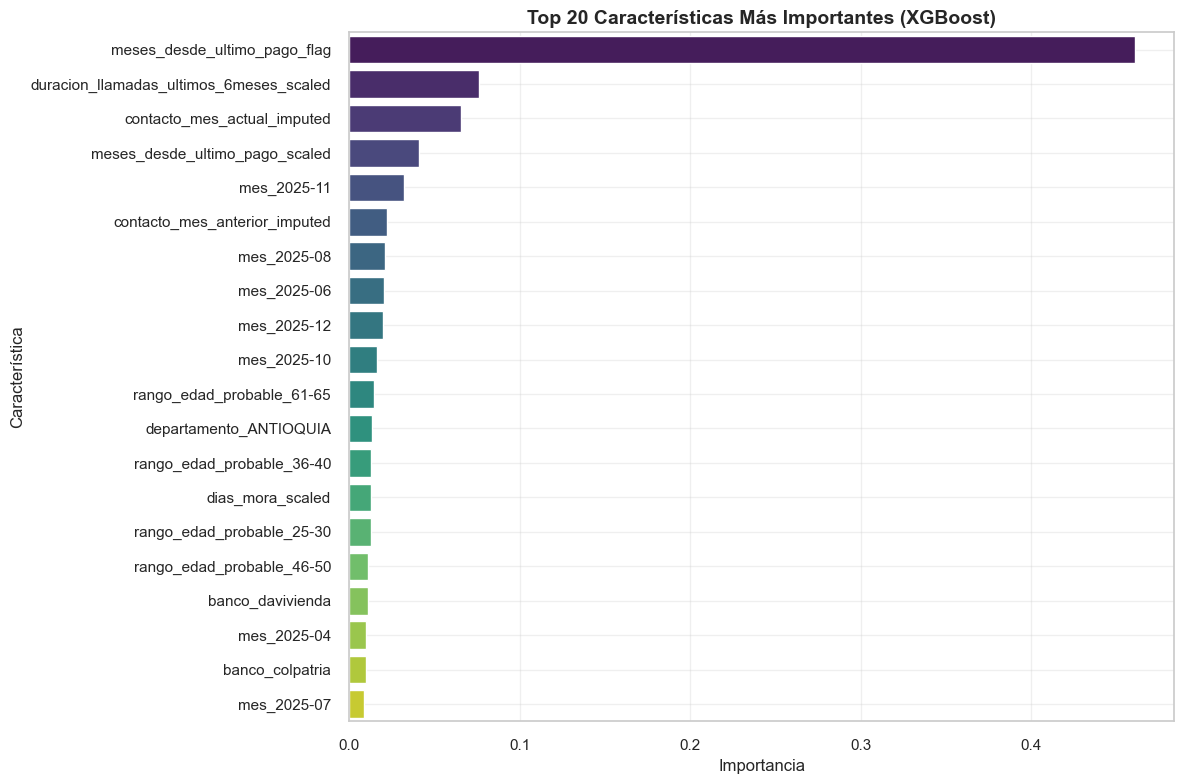

🔄 Evaluando características seleccionadas...
✅ Selección completada
📊 Características seleccionadas: 20
📊 Score CV: 0.898 ± 0.007
📊 Top 5 características: ['meses_desde_ultimo_pago_flag', 'duracion_llamadas_ultimos_6meses_scaled', 'contacto_mes_actual_imputed', 'meses_desde_ultimo_pago_scaled', 'mes_2025-11']
🔧 Iniciando selección de características con XGBoost...
📊 Método: rfe
📊 Total características: 108
📊 Objetivo: Top 20 características


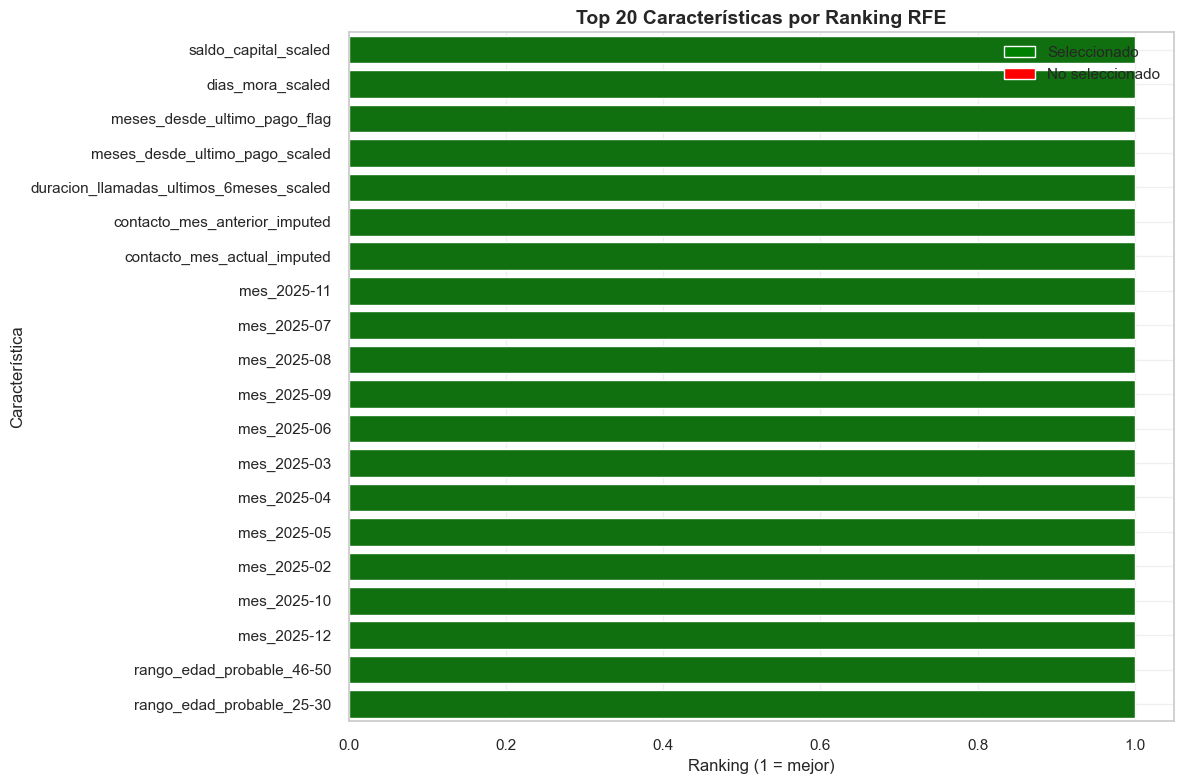

🔄 Evaluando características seleccionadas...
✅ Selección completada
📊 Características seleccionadas: 20
📊 Score CV: 0.903 ± 0.007
📊 Top 5 características: ['saldo_capital_scaled', 'dias_mora_scaled', 'meses_desde_ultimo_pago_flag', 'meses_desde_ultimo_pago_scaled', 'duracion_llamadas_ultimos_6meses_scaled']


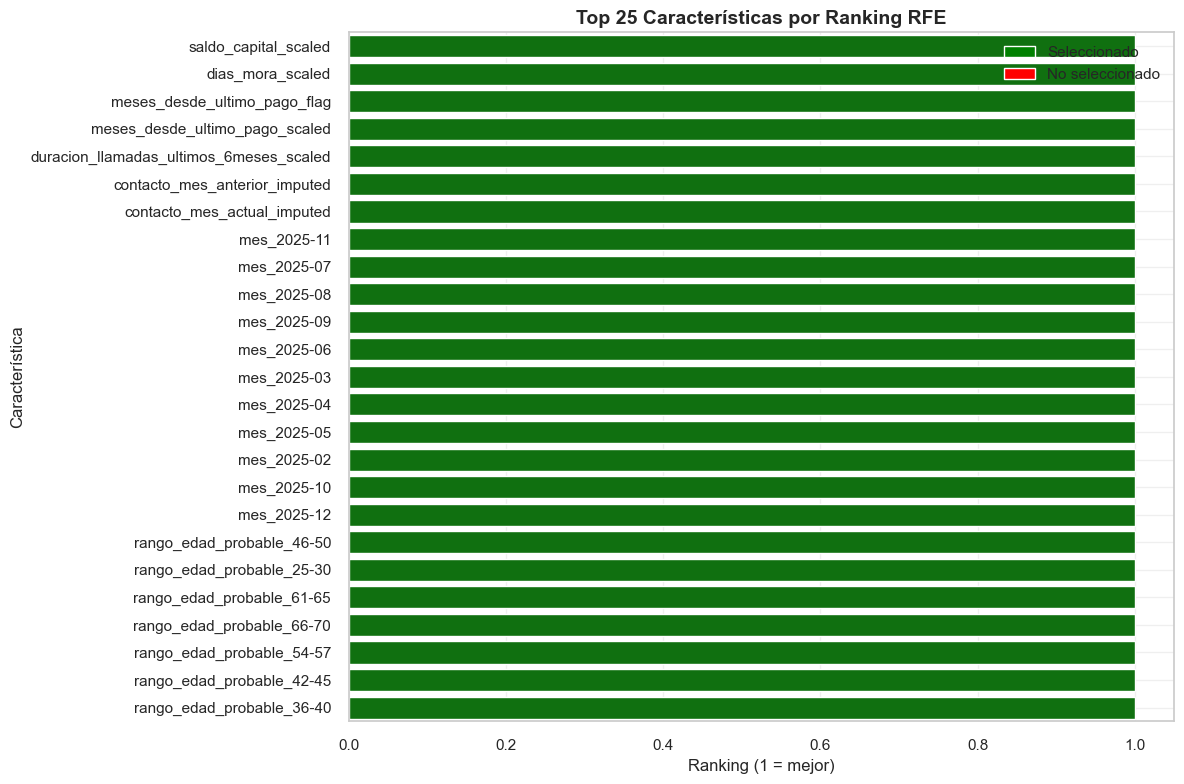

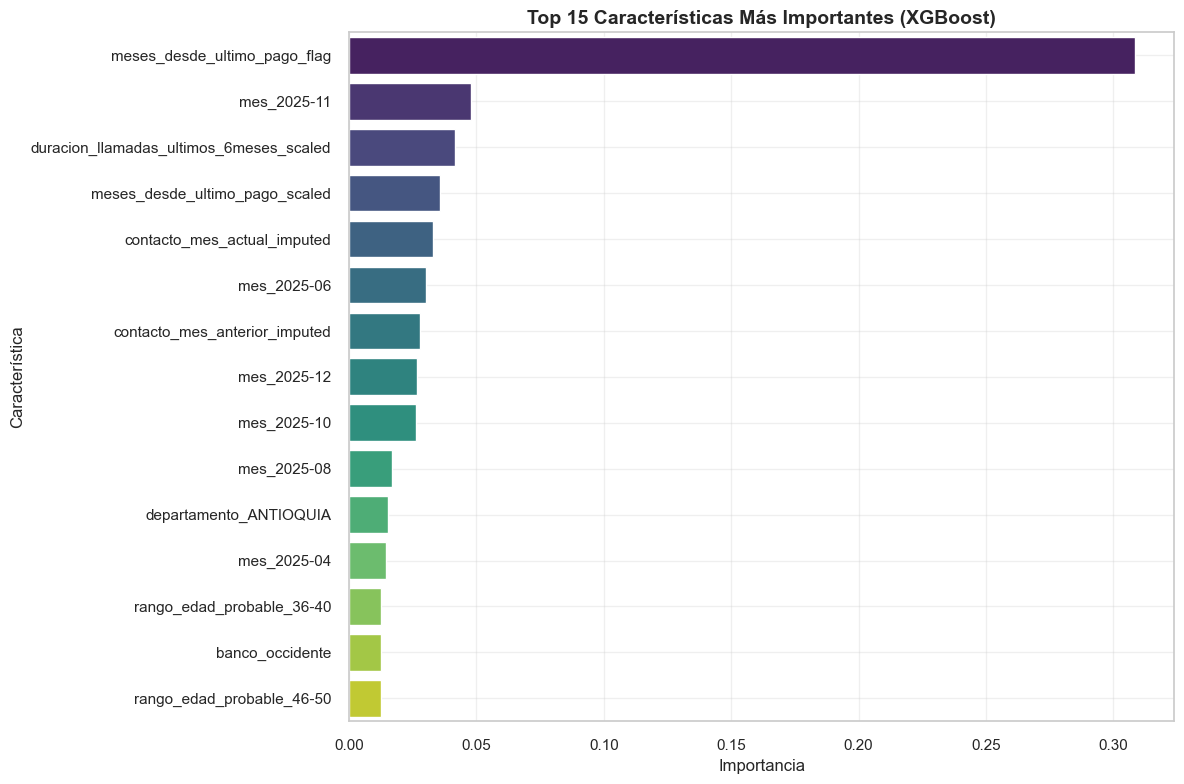

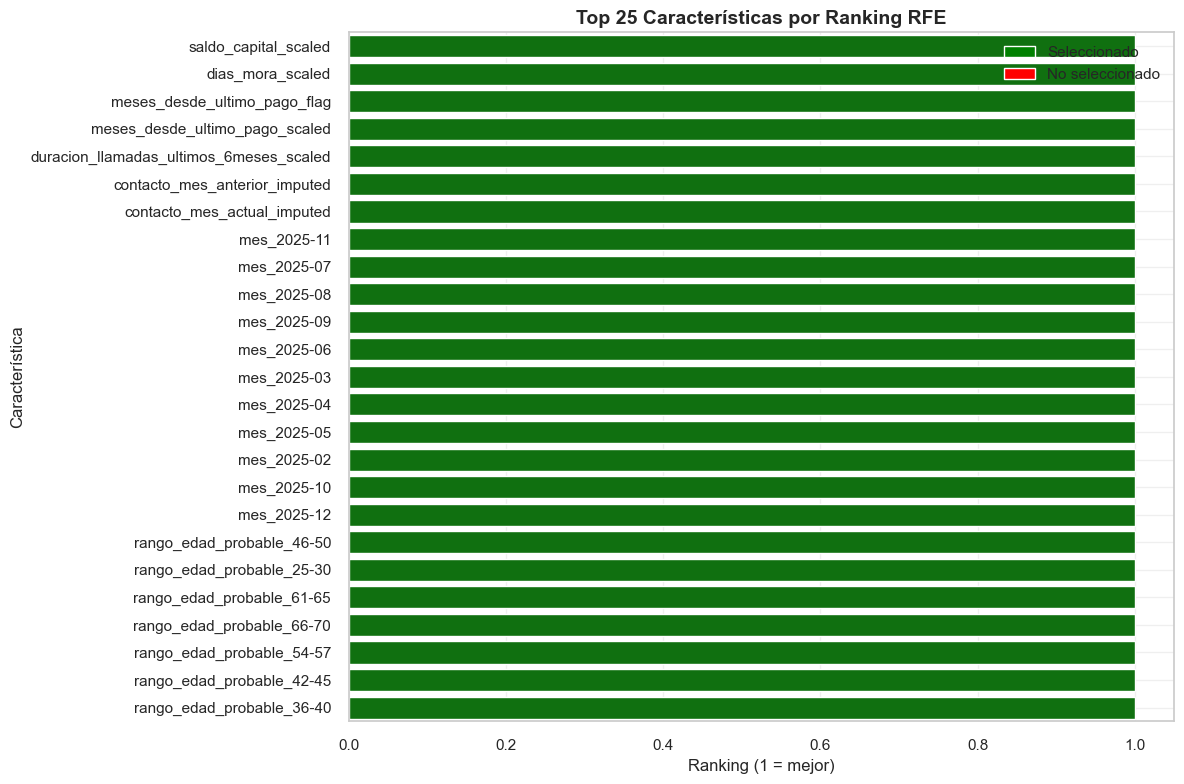

In [26]:
# Importar el módulo
# Recargar el módulo feature_selection
import importlib
import feature_selection
importlib.reload(feature_selection)

# Ahora importar las funciones
from feature_selection import select_features_with_xgboost, XGBoostFeatureSelector, XGBoostRFESelector

# Método 1: Por importancia de características
selected_imp, mask_imp, results_imp = select_features_with_xgboost(
    X_train_preprocessed, y_train, feature_names,
    method='importance',
    top_n=20
)

# Método 2: Por RFE
selected_rfe, mask_rfe, results_rfe = select_features_with_xgboost(
    X_train_preprocessed, y_train, feature_names,
    method='rfe',
    top_n=20,
    cv=5
)

# Uso individual de clases
selector = XGBoostFeatureSelector(n_estimators=200, max_depth=4)
selector.fit(X_train_preprocessed, y_train, feature_names)
top_features = selector.get_feature_importance(15)
selector.plot_feature_importance(15)

# RFE individual
rfe_selector = XGBoostRFESelector(step=0.2, cv=5)
rfe_selector.fit(X_train_preprocessed, y_train, feature_names)
best_features, mask = rfe_selector.get_top_features(25)
rfe_selector.plot_rfe_results(25)

## 7. Modelos con variables seleccionadas

**Consideración Importante:**

Dado que el dataset está desbalanceado, la métrica principal que priorizaremos para evaluar los modelos es **ROC AUC**, ya que refleja la capacidad del modelo para **diferenciar correctamente entre pagos y no pagos** independientemente de la proporción de clases. En el futuro, se podrán evaluar también otras métricas como precisión, recall o F1 para obtener un panorama más completo del desempeño.

---

Se entrenaron los cuatro modelos seleccionados (Regresión Logística, Random Forest, Gradient Boosting y XGBoost) usando tres conjuntos de características: top 5 de importancia, top 5 seleccionadas por RFE y la unión de ambos top 5. Esto permitió reducir dimensionalidad y enfocarse en las variables más relevantes para la predicción de pagos.

Los resultados muestran que la combinación de características seleccionadas por ambos métodos entrega un mejor balance entre recall y precisión, particularmente en Regresión Logística y Gradient Boosting, lo que indica que se capturan mejor los pagos sin sacrificar demasiado la capacidad general del modelo. En comparación, los conjuntos individuales (solo importancia o solo RFE) ofrecen métricas más desbalanceadas: RFE mejora ligeramente el F1 de algunos modelos, mientras que la selección por importancia destaca en interpretabilidad pero con recall más bajo.

Al comparar con los modelos entrenados originalmente con las 108 variables, la reducción a las características seleccionadas no solo disminuye complejidad computacional sino que mantiene métricas de ROC AUC y recall comparables, mostrando que el feature selection logró conservar la información más relevante. **Por lo tanto, el conjunto combinado de características seleccionadas se considera la mejor opción para este caso de prueba.**

---
El mejor modelo resultó ser Regresión Logística, entrenado con 7 características seleccionadas: ['meses_desde_ultimo_pago_flag', 'duracion_llamadas_ultimos_6meses_scaled', 'contacto_mes_actual_imputed', 'meses_desde_ultimo_pago_scaled', 'mes_2025-11', 'saldo_capital_scaled', 'dias_mora_scaled']. Este modelo logra el mejor balance entre recall y ROC AUC (0.891), superando a los demás modelos y mostrando que la reducción de variables de 108 a las más relevantes mantiene la capacidad predictiva mientras simplifica el modelo.

2026-02-20 10:37:16,683 - ERROR - Failed to read module file 'C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\src\modeling.py' for module 'modeling': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 556, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 9274: character maps to <undefined>


🔍 Seleccionando características por importancia...
🔧 Iniciando selección de características con XGBoost...
📊 Método: importance
📊 Total características: 108
📊 Objetivo: Top 10 características


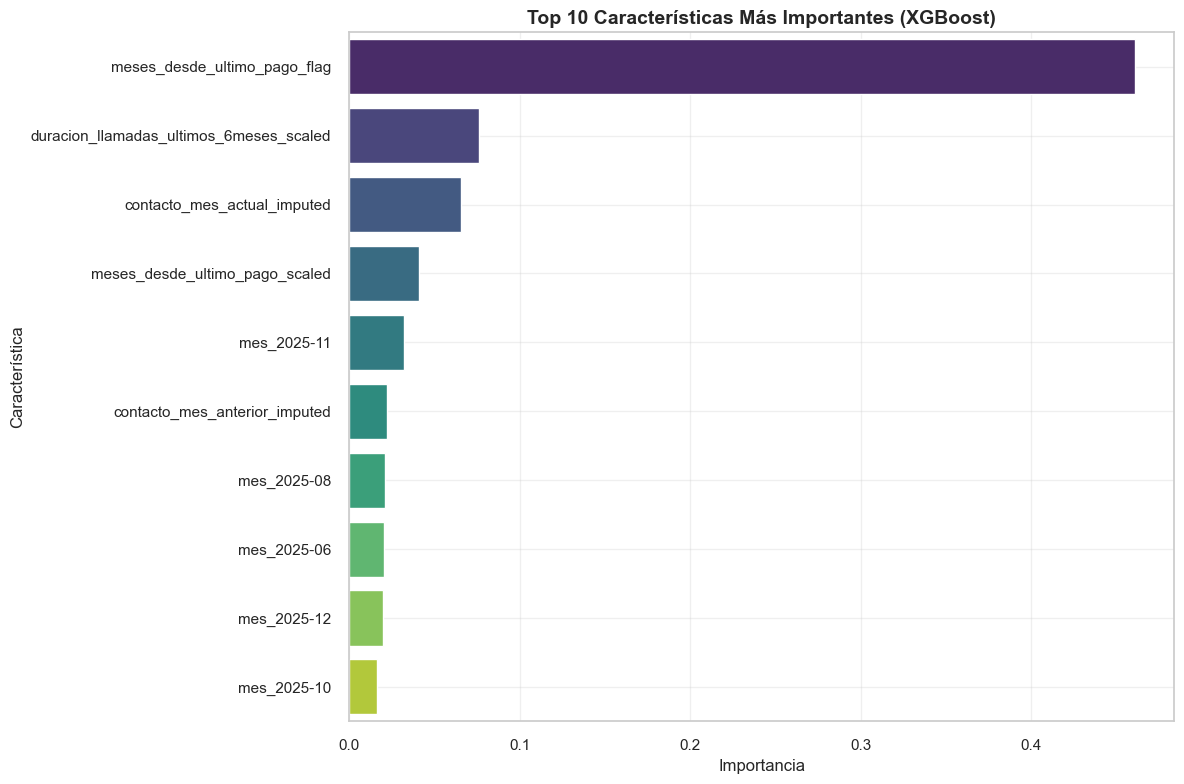

🔄 Evaluando características seleccionadas...
✅ Selección completada
📊 Características seleccionadas: 10
📊 Score CV: 0.891 ± 0.007
📊 Top 5 características: ['meses_desde_ultimo_pago_flag', 'duracion_llamadas_ultimos_6meses_scaled', 'contacto_mes_actual_imputed', 'meses_desde_ultimo_pago_scaled', 'mes_2025-11']

🔄 Seleccionando características por RFE...
🔧 Iniciando selección de características con XGBoost...
📊 Método: rfe
📊 Total características: 108
📊 Objetivo: Top 10 características


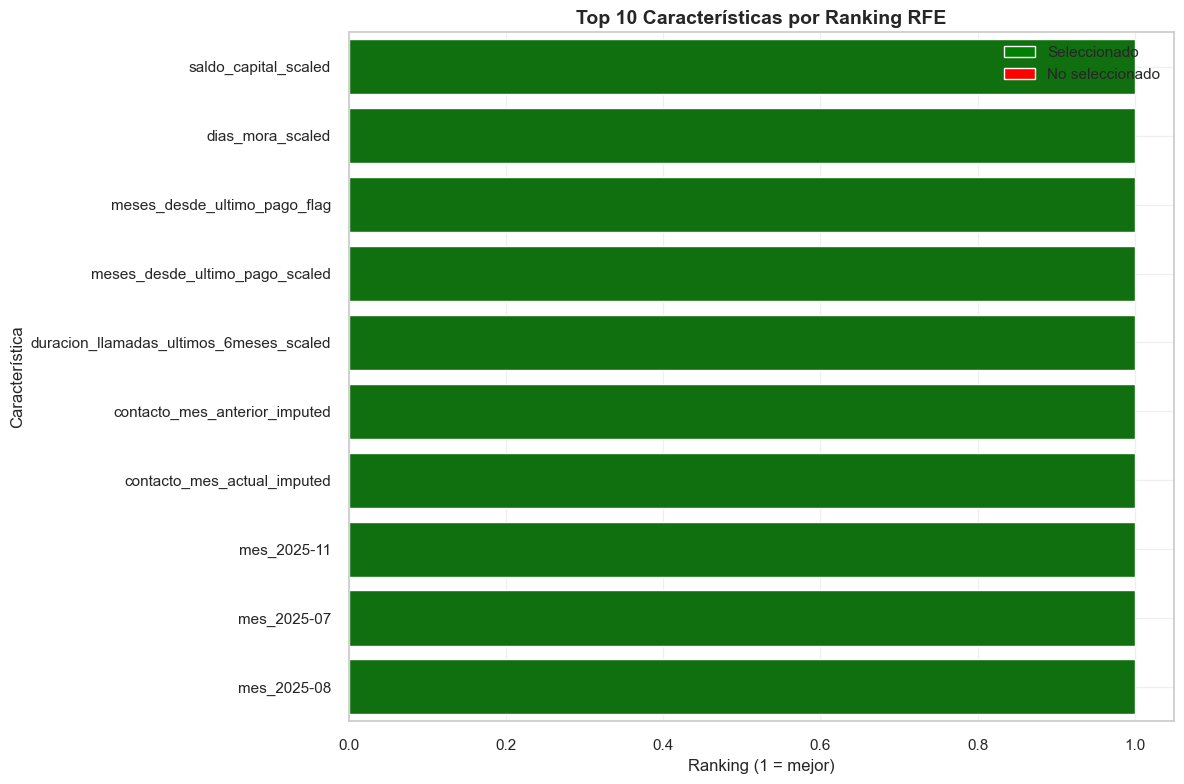

🔄 Evaluando características seleccionadas...
✅ Selección completada
📊 Características seleccionadas: 10
📊 Score CV: 0.879 ± 0.006
📊 Top 5 características: ['saldo_capital_scaled', 'dias_mora_scaled', 'meses_desde_ultimo_pago_flag', 'meses_desde_ultimo_pago_scaled', 'duracion_llamadas_ultimos_6meses_scaled']
🎯 MODELADO SIN BALANCEO
🔧 Iniciando modelado con características seleccionadas...
📊 Características por importancia (top 5): ['meses_desde_ultimo_pago_flag', 'duracion_llamadas_ultimos_6meses_scaled', 'contacto_mes_actual_imputed', 'meses_desde_ultimo_pago_scaled', 'mes_2025-11']
📊 Características por RFE (top 5): ['saldo_capital_scaled', 'dias_mora_scaled', 'meses_desde_ultimo_pago_flag', 'meses_desde_ultimo_pago_scaled', 'duracion_llamadas_ultimos_6meses_scaled']
📊 Características combinadas: ['meses_desde_ultimo_pago_flag', 'duracion_llamadas_ultimos_6meses_scaled', 'contacto_mes_actual_imputed', 'meses_desde_ultimo_pago_scaled', 'mes_2025-11', 'saldo_capital_scaled', 'dias_mora_

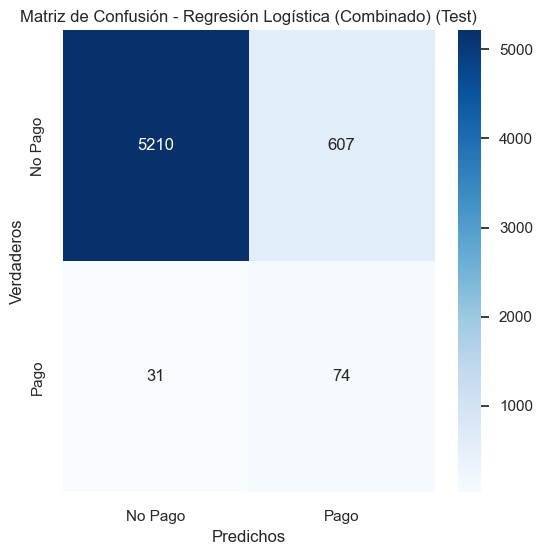

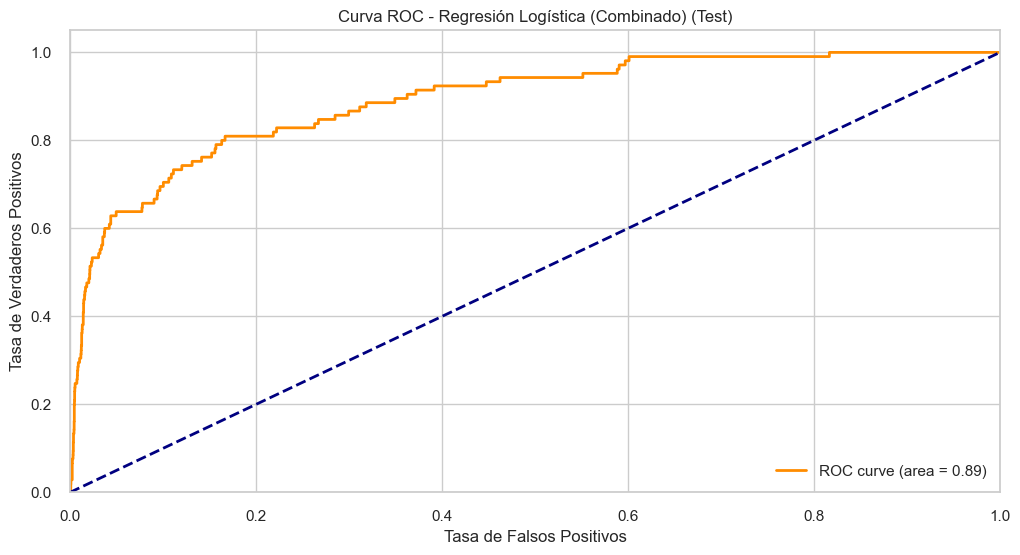


📊 Análisis de Overfitting - Regresión Logística (Combinado):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.900    0.892    0.008      0.9     % Low     
precision    0.112    0.109    0.004      3.5     % Low     
recall       0.675    0.705    -0.030     -4.3    % Low     
f1           0.193    0.188    0.004      2.4     % Low     
roc_auc      0.870    0.891    -0.021     -2.3    % Low     
pr_auc       0.221    0.235    -0.015     -6.2    % Low     
🔍 Evaluando modelo: Random Forest


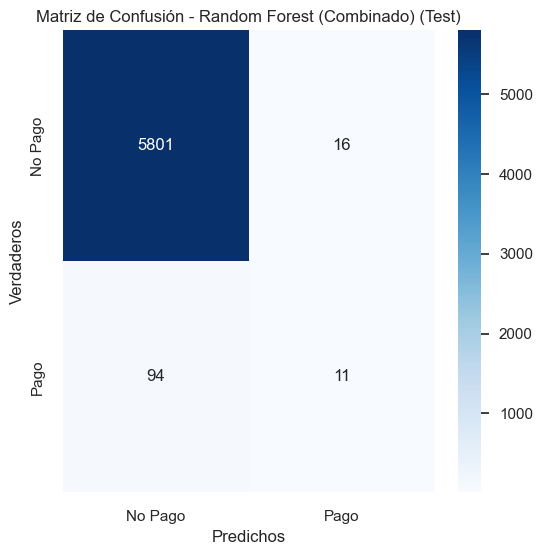

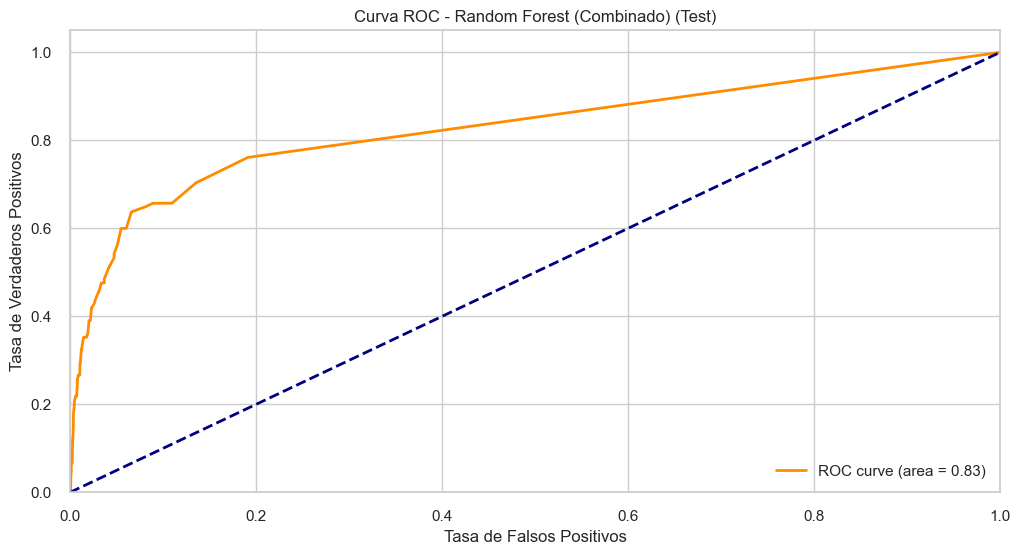


📊 Análisis de Overfitting - Random Forest (Combinado):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     1.000    0.981    0.018      1.8     % Low     
precision    0.977    0.407    0.569      139.7   % High    
recall       1.000    0.105    0.895      854.5   % High    
f1           0.988    0.167    0.822      492.9   % High    
roc_auc      1.000    0.828    0.172      20.8    % High    
pr_auc       0.991    0.207    0.785      379.5   % High    
🔍 Evaluando modelo: Gradient Boosting


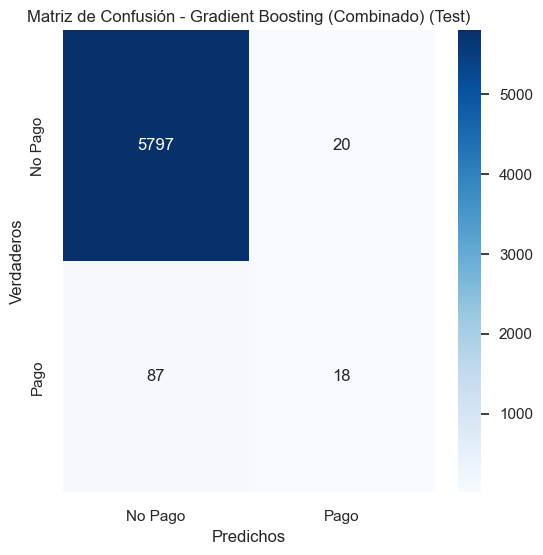

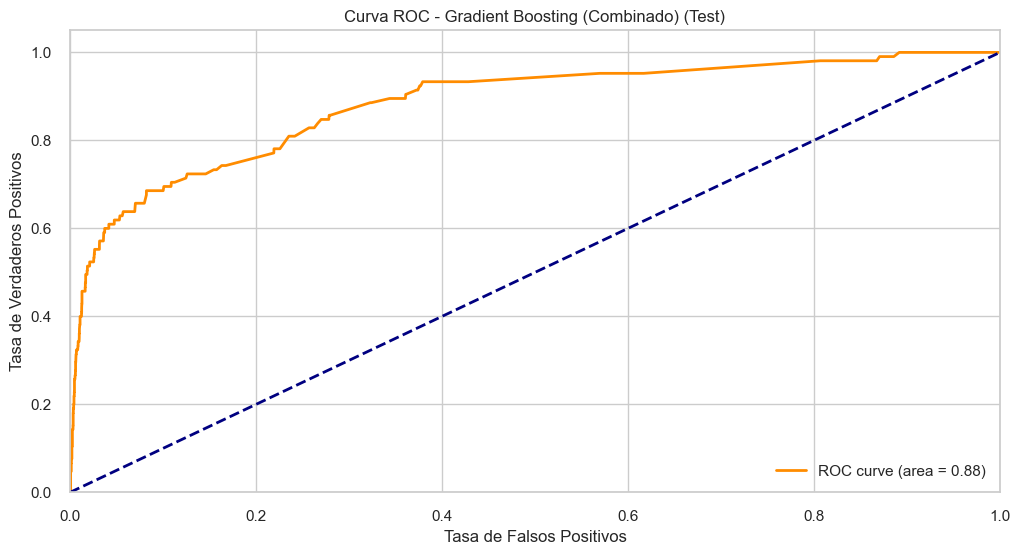


📊 Análisis de Overfitting - Gradient Boosting (Combinado):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.986    0.982    0.004      0.4     % Low     
precision    0.758    0.474    0.285      60.1    % High    
recall       0.270    0.171    0.099      57.7    % High    
f1           0.399    0.252    0.147      58.3    % High    
roc_auc      0.900    0.882    0.018      2.1     % Low     
pr_auc       0.464    0.272    0.192      70.4    % High    
🔍 Evaluando modelo: XGBoost


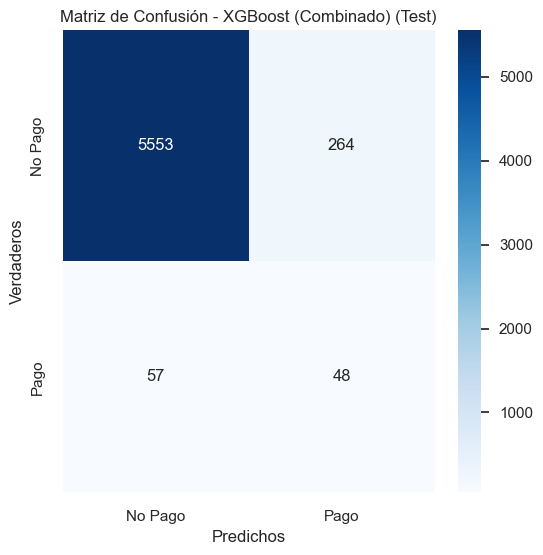

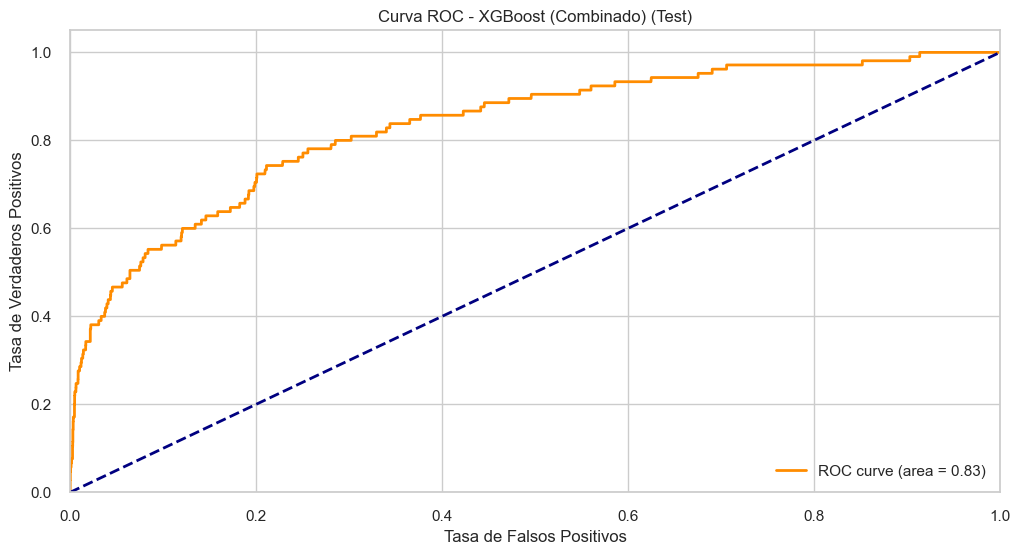


📊 Análisis de Overfitting - XGBoost (Combinado):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.973    0.946    0.027      2.9     % Low     
precision    0.394    0.154    0.240      155.8   % High    
recall       1.000    0.457    0.543      118.8   % High    
f1           0.565    0.230    0.335      145.4   % High    
roc_auc      0.998    0.833    0.165      19.8    % High    
pr_auc       0.918    0.204    0.715      350.5   % High    

📊 Evaluando con características por importancia (5 features)...


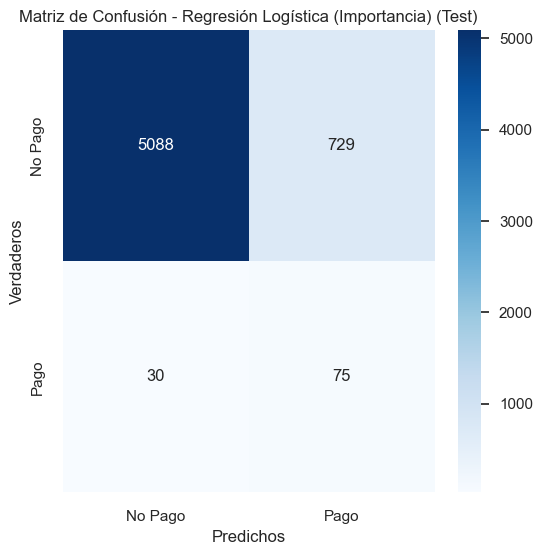

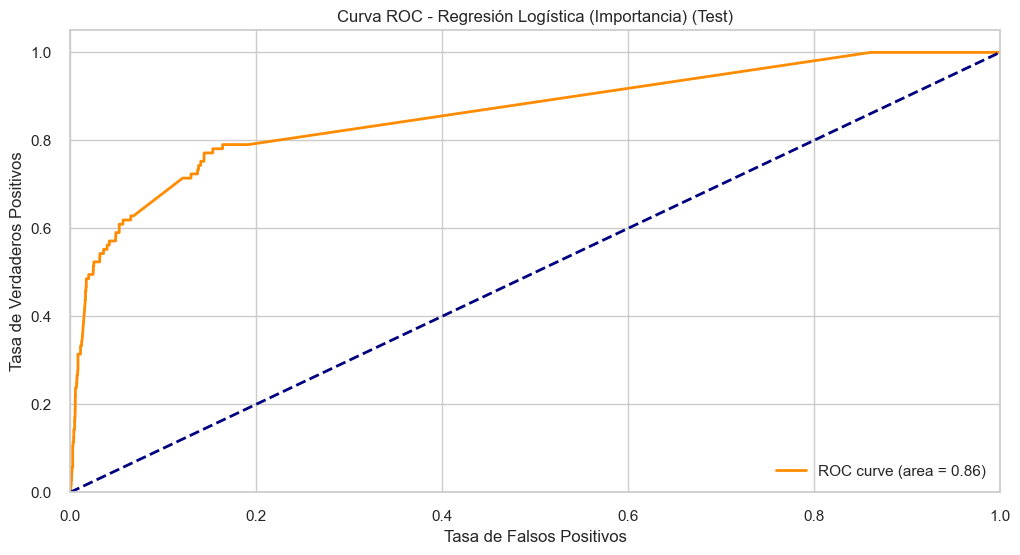


📊 Análisis de Overfitting - Regresión Logística (Importancia):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.881    0.872    0.009      1.1     % Low     
precision    0.097    0.093    0.003      3.5     % Low     
recall       0.687    0.714    -0.028     -3.9    % Low     
f1           0.169    0.165    0.004      2.5     % Low     
roc_auc      0.846    0.861    -0.015     -1.7    % Low     
pr_auc       0.212    0.219    -0.007     -3.3    % Low     


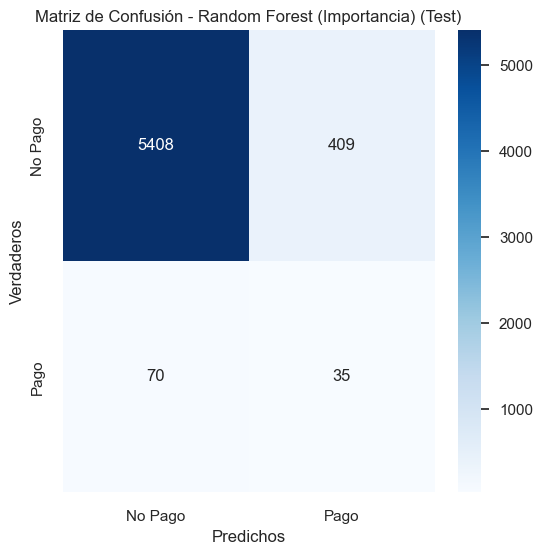

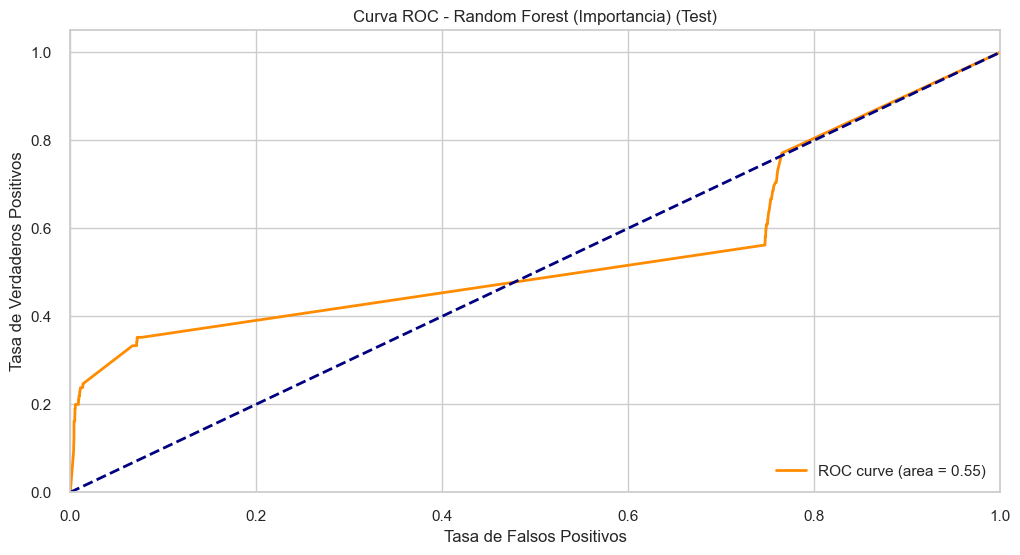


📊 Análisis de Overfitting - Random Forest (Importancia):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.941    0.919    0.022      2.4     % Low     
precision    0.197    0.079    0.118      149.6   % High    
recall       0.754    0.333    0.420      126.1   % High    
f1           0.312    0.128    0.185      144.7   % High    
roc_auc      0.893    0.548    0.345      63.0    % High    
pr_auc       0.391    0.099    0.292      293.7   % High    


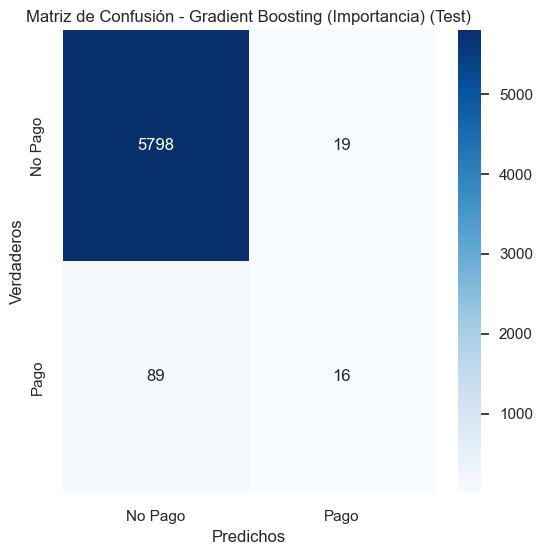

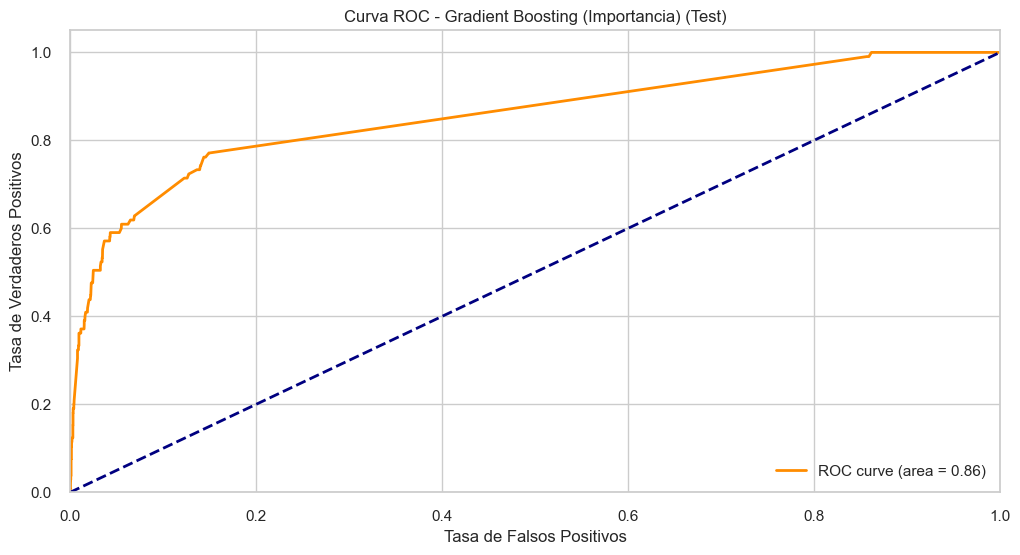


📊 Análisis de Overfitting - Gradient Boosting (Importancia):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.985    0.982    0.003      0.3     % Low     
precision    0.750    0.457    0.293      64.1    % High    
recall       0.237    0.152    0.084      55.4    % High    
f1           0.360    0.229    0.131      57.5    % High    
roc_auc      0.854    0.856    -0.001     -0.1    % Low     
pr_auc       0.419    0.244    0.175      71.8    % High    


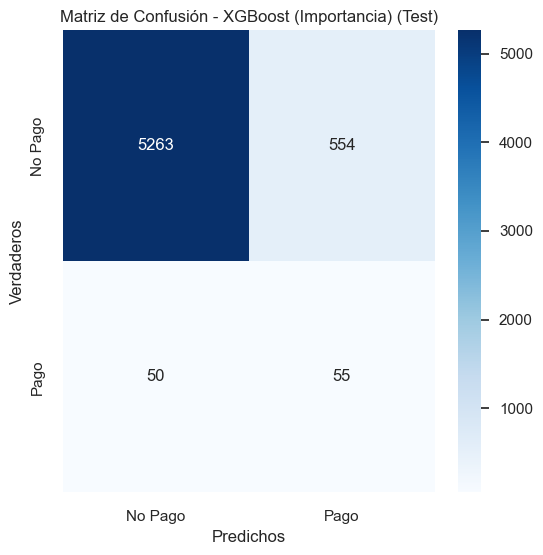

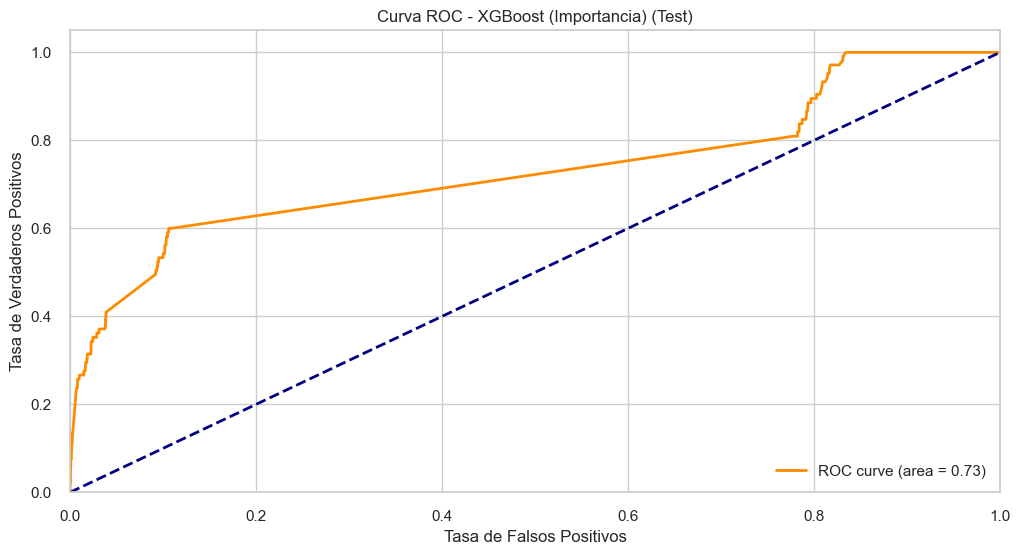


📊 Análisis de Overfitting - XGBoost (Importancia):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.914    0.898    0.016      1.7     % Low     
precision    0.140    0.090    0.050      54.8    % High    
recall       0.756    0.524    0.232      44.3    % High    
f1           0.236    0.154    0.082      53.2    % High    
roc_auc      0.885    0.733    0.152      20.7    % High    
pr_auc       0.458    0.186    0.272      146.4   % High    

📊 Evaluando con características por RFE (5 features)...


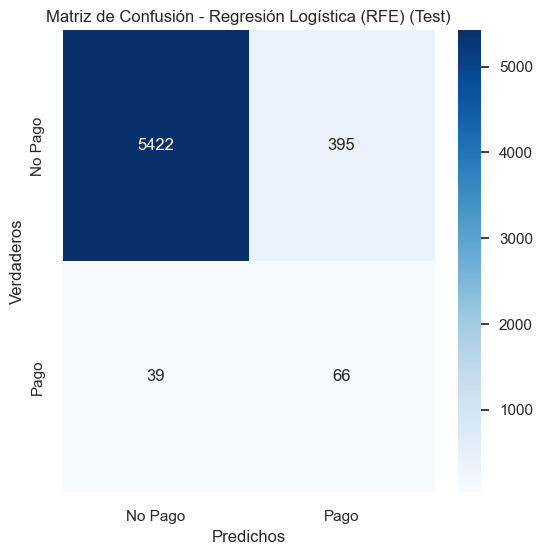

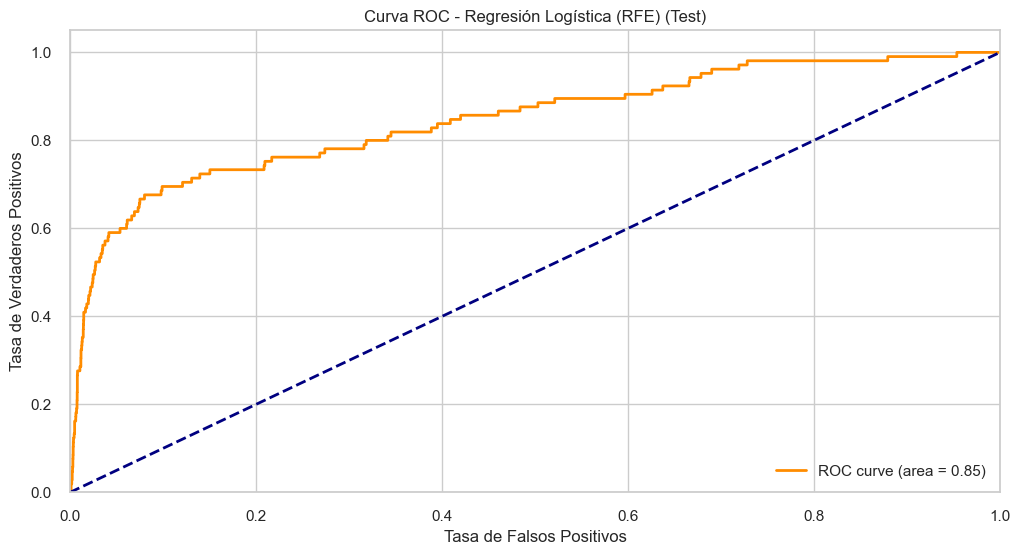


📊 Análisis de Overfitting - Regresión Logística (RFE):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.932    0.927    0.006      0.6     % Low     
precision    0.146    0.143    0.003      1.8     % Low     
recall       0.581    0.629    -0.047     -7.5    % Low     
f1           0.233    0.233    -0.000     -0.1    % Low     
roc_auc      0.831    0.846    -0.016     -1.9    % Low     
pr_auc       0.182    0.204    -0.023     -11.1   % Low     


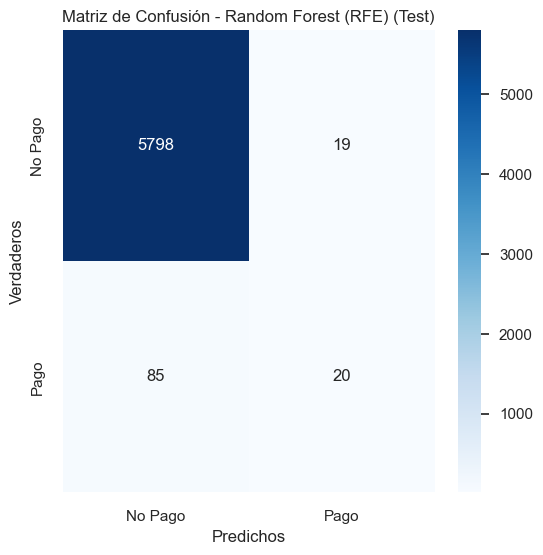

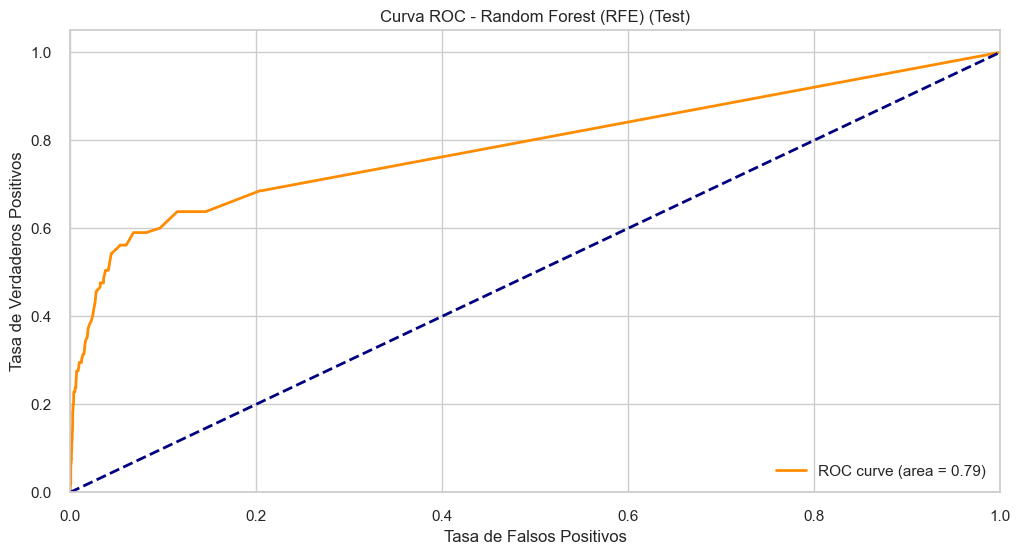


📊 Análisis de Overfitting - Random Forest (RFE):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.999    0.982    0.017      1.7     % Low     
precision    0.961    0.513    0.448      87.4    % High    
recall       1.000    0.190    0.810      425.0   % High    
f1           0.980    0.278    0.702      252.8   % High    
roc_auc      1.000    0.787    0.213      27.1    % High    
pr_auc       0.988    0.216    0.772      357.7   % High    


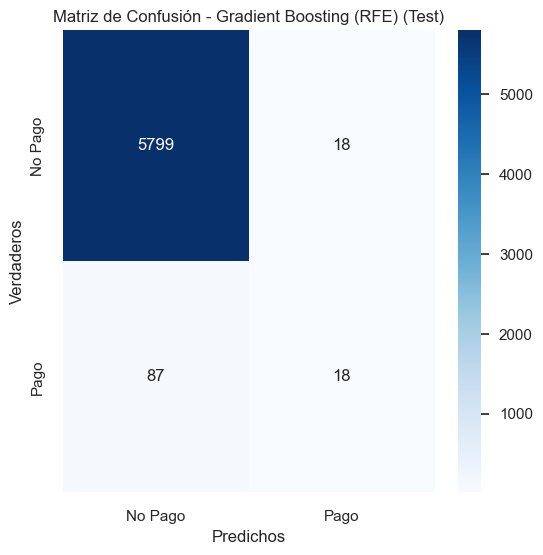

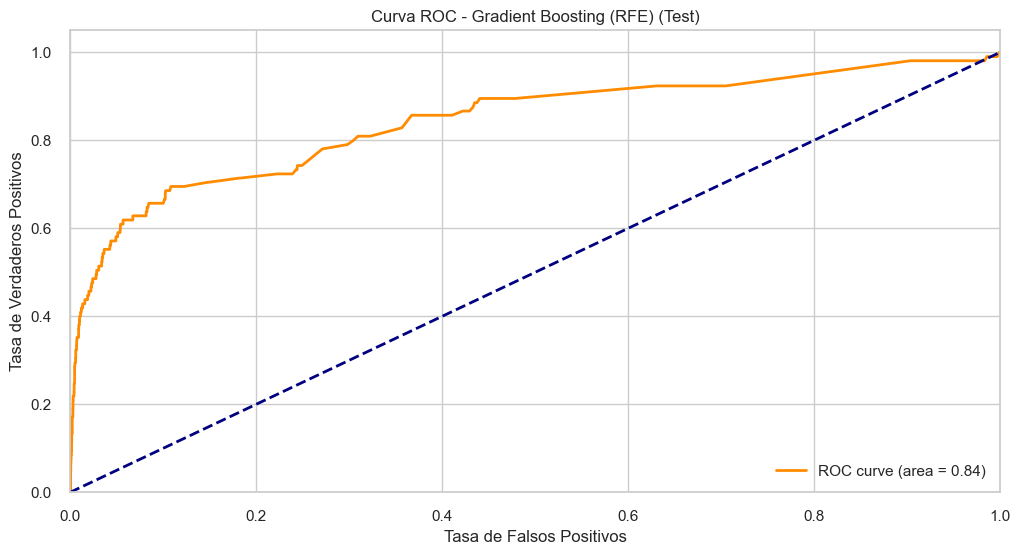


📊 Análisis de Overfitting - Gradient Boosting (RFE):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.985    0.982    0.003      0.3     % Low     
precision    0.748    0.500    0.248      49.6    % High    
recall       0.249    0.171    0.077      45.1    % High    
f1           0.373    0.255    0.118      46.3    % High    
roc_auc      0.868    0.843    0.026      3.1     % Low     
pr_auc       0.447    0.271    0.176      64.8    % High    


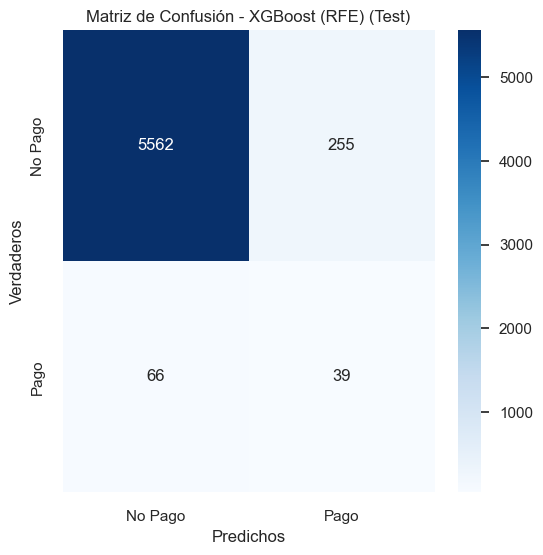

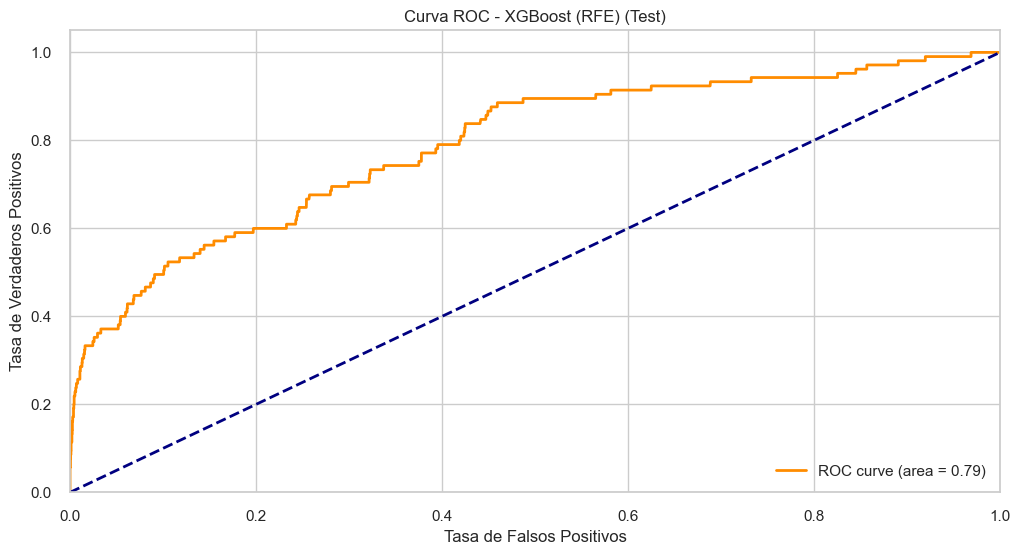


📊 Análisis de Overfitting - XGBoost (RFE):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.972    0.946    0.026      2.8     % Low     
precision    0.385    0.133    0.253      190.4   % High    
recall       1.000    0.371    0.629      169.2   % High    
f1           0.556    0.195    0.361      184.5   % High    
roc_auc      0.998    0.789    0.209      26.4    % High    
pr_auc       0.893    0.226    0.667      295.8   % High    

📊 TABLAS COMPARATIVAS TRAIN vs TEST

🎯 TABLA GENERAL TRAIN vs TEST:


Model     Metric  Train  Test  Difference  %_Diff  \
0   Regresión Logística   ACCURACY  0.900 0.892       0.008   0.898   
1   Regresión Logística  PRECISION  0.112 0.109       0.004   3.475   
2   Regresión Logística     RECALL  0.675 0.705      -0.030  -4.274   
3   Regresión Logística         F1  0.193 0.188       0.004   2.368   
4   Regresión Logística    ROC_AUC  0.870 0.891      -0.021  -2.343   
5   Regresión Logística     PR_AUC  0.221 0.235      -0.015  -6.211   
6         Random Forest   ACCURACY  1.000 0.981       0.018   1.850   
7         Random Forest  PRECISION  0.977 0.407       0.569 139.720   
8         Random Forest     RECALL  1.000 0.105       0.895 854.545   
9         Random Forest         F1  0.988 0.167       0.822 492.908   
10        Random Forest    ROC_AUC  1.000 0.828       0.172  20.760   
11        Random Forest     PR_AUC  0.991 0.207       0.785 379.542   
12    Gradient Boosting   ACCURACY  0.986 0.982       0.004   0.374   
13    Gradient Boosting  PRECISION  0.758 0.474       0.285  60.104   
14    Gradient Boosting     RECALL  0.270 0.171       0.099  57.695   
15    Gradient Boosting         F1  0.399 0.252       0.147  58.328   
16    Gradient Boosting    ROC_AUC  0.900 0.882       0.018   2.082   
17    Gradient Boosting     PR_AUC  0.464 0.272       0.192  70.446   
18              XGBoost   ACCURACY  0.973 0.946       0.027   2.857   
19              XGBoost  PRECISION  0.394 0.154       0.240 155.838   
20              XGBoost     RECALL  1.000 0.457       0.543 118.750   
21              XGBoost         F1  0.565 0.230       0.335 145.363   
22              XGBoost    ROC_AUC  0.998 0.833       0.165  19.844   
23              XGBoost     PR_AUC  0.918 0.204       0.715 350.510   
24  Regresión Logística   ACCURACY  0.881 0.872       0.009   1.055   
25  Regresión Logística  PRECISION  0.097 0.093       0.003   3.451   
26  Regresión Logística     RECALL  0.687 0.714      -0.028  -3.876   
27  Regresión Logística         F1  0.169 0.165       0.004   2.548   
28  Regresión Logística    ROC_AUC  0.846 0.861      -0.015  -1.688   
29  Regresión Logística     PR_AUC  0.212 0.219      -0.007  -3.258   
30        Random Forest   ACCURACY  0.941 0.919       0.022   2.420   
31        Random Forest  PRECISION  0.197 0.079       0.118 149.594   
32        Random Forest     RECALL  0.754 0.333       0.420 126.077   
33        Random Forest         F1  0.312 0.128       0.185 144.725   
34        Random Forest    ROC_AUC  0.893 0.548       0.345  63.028   
35        Random Forest     PR_AUC  0.391 0.099       0.292 293.742   
36    Gradient Boosting   ACCURACY  0.985 0.982       0.003   0.344   
37    Gradient Boosting  PRECISION  0.750 0.457       0.293  64.062   
38    Gradient Boosting     RECALL  0.237 0.152       0.084  55.428   
39    Gradient Boosting         F1  0.360 0.229       0.131  57.500   
40    Gradient Boosting    ROC_AUC  0.854 0.856      -0.001  -0.142   
41    Gradient Boosting     PR_AUC  0.419 0.244       0.175  71.798   
42              XGBoost   ACCURACY  0.914 0.898       0.016   1.739   
43              XGBoost  PRECISION  0.140 0.090       0.050  54.822   
44              XGBoost     RECALL  0.756 0.524       0.232  44.324   
45              XGBoost         F1  0.236 0.154       0.082  53.184   
46              XGBoost    ROC_AUC  0.885 0.733       0.152  20.744   
47              XGBoost     PR_AUC  0.458 0.186       0.272 146.430   
48  Regresión Logística   ACCURACY  0.932 0.927       0.006   0.619   
49  Regresión Logística  PRECISION  0.146 0.143       0.003   1.758   
50  Regresión Logística     RECALL  0.581 0.629      -0.047  -7.514   
51  Regresión Logística         F1  0.233 0.233      -0.000  -0.100   
52  Regresión Logística    ROC_AUC  0.831 0.846      -0.016  -1.865   
53  Regresión Logística     PR_AUC  0.182 0.204      -0.023 -11.078   
54        Random Forest   ACCURACY  0.999 0.982       0.017   1.715   
55        Random Forest  PRECISION  0.961 

✅ Tabla comparativa guardada en: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\outputs\train_test_comparison.csv

📈 RESULTADOS COMPARATIVOS
🎯 Características Combinadas:
                     accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.892      0.109   0.705 0.188    0.891   0.235
Gradient Boosting       0.982      0.474   0.171 0.252    0.882   0.272
XGBoost                 0.946      0.154   0.457 0.230    0.833   0.204
Random Forest           0.981      0.407   0.105 0.167    0.828   0.207

📊 Características por Importancia:
                     accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.872      0.093   0.714 0.165    0.861   0.219
Gradient Boosting       0.982      0.457   0.152 0.229    0.856   0.244
XGBoost                 0.898      0.090   0.524 0.154    0.733   0.186
Random Forest           0.919      0.079   0.333 0.128    0.548   0.099

🔄 Características por RFE:
                     accuracy

accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.892      0.109   0.705 0.188    0.891   0.235
Gradient Boosting       0.982      0.474   0.171 0.252    0.882   0.272
XGBoost                 0.946      0.154   0.457 0.230    0.833   0.204
Random Forest           0.981      0.407   0.105 0.167    0.828   0.207


📊 TRAIN RESULTS (SIN BALANCEO):


accuracy  precision  recall    f1  roc_auc  \
Random Forest                       1.000      0.977   1.000 0.988    1.000   
Random Forest_rfe                   0.999      0.961   1.000 0.980    1.000   
XGBoost                             0.973      0.394   1.000 0.565    0.998   
XGBoost_rfe                         0.972      0.385   1.000 0.556    0.998   
Gradient Boosting                   0.986      0.758   0.270 0.399    0.900   
Random Forest_importancia           0.941      0.197   0.754 0.312    0.893   
XGBoost_importancia                 0.914      0.140   0.756 0.236    0.885   
Regresión Logística                 0.900      0.112   0.675 0.193    0.870   
Gradient Boosting_rfe               0.985      0.748   0.249 0.373    0.868   
Gradient Boosting_importancia       0.985      0.750   0.237 0.360    0.854   
Regresión Logística_importancia     0.881      0.097   0.687 0.169    0.846   
Regresión Logística_rfe             0.932      0.146   0.581 0.233    0.831   

                                 pr_auc  
Random Forest                     0.991  
Random Forest_rfe                 0.988  
XGBoost                           0.918  
XGBoost_rfe                       0.893  
Gradient Boosting                 0.464  
Random Forest_importancia         0.391  
XGBoost_importancia               0.458  
Regresión Logística               0.221  
Gradient Boosting_rfe             0.447  
Gradient Boosting_importancia     0.419  
Regresión Logística_importancia   0.212  
Regresión Logística_rfe           0.182


⚠️  ANÁLISIS DE OVERFITTING (SIN BALANCEO)

🔍 Overfitting - Regresión Logística:
  accuracy: Low risk (0.9% diff)
  precision: Low risk (3.5% diff)
  recall: Low risk (-4.3% diff)
  f1: Low risk (2.4% diff)
  roc_auc: Low risk (-2.3% diff)
  pr_auc: Low risk (-6.2% diff)

🔍 Overfitting - Random Forest:
  accuracy: Low risk (1.8% diff)
  precision: High risk (139.7% diff)
  recall: High risk (854.5% diff)
  f1: High risk (492.9% diff)
  roc_auc: High risk (20.8% diff)
  pr_auc: High risk (379.5% diff)

🔍 Overfitting - Gradient Boosting:
  accuracy: Low risk (0.4% diff)
  precision: High risk (60.1% diff)
  recall: High risk (57.7% diff)
  f1: High risk (58.3% diff)
  roc_auc: Low risk (2.1% diff)
  pr_auc: High risk (70.4% diff)

🔍 Overfitting - XGBoost:
  accuracy: Low risk (2.9% diff)
  precision: High risk (155.8% diff)
  recall: High risk (118.8% diff)
  f1: High risk (145.4% diff)
  roc_auc: High risk (19.8% diff)
  pr_auc: High risk (350.5% diff)

📊 GRÁFICO COMPARATIVO (SIN BALAN

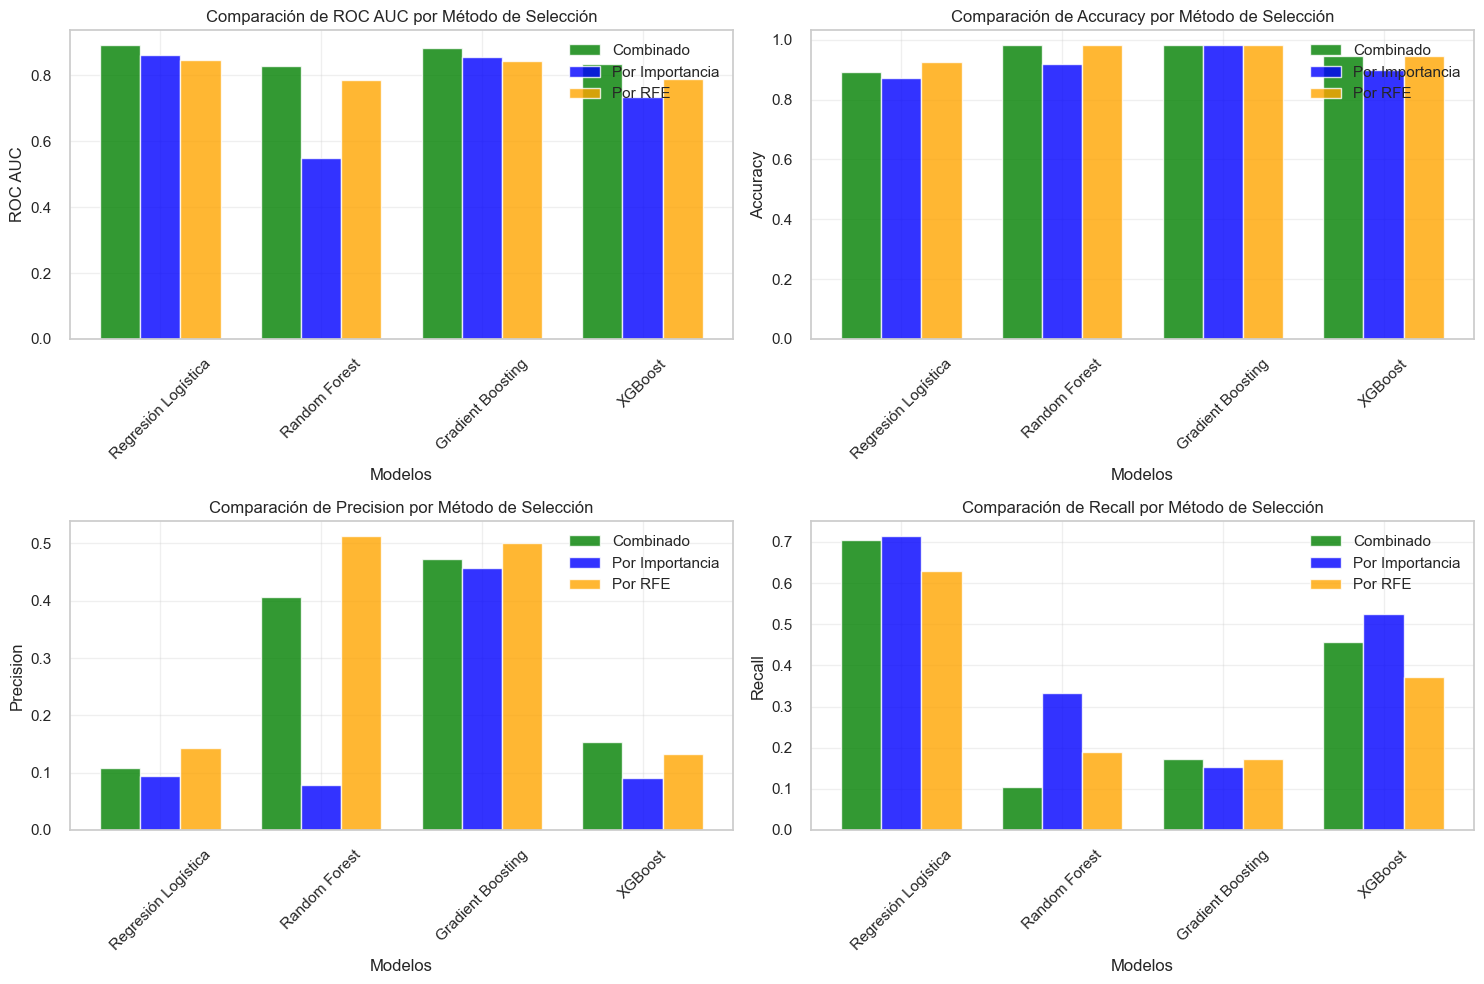


🥇 Mejor modelo SIN balanceo: Regresión Logística (ROC AUC: 0.891)


In [34]:
# 1. Importar módulos necesarios
import importlib
import feature_selection
import modeling
importlib.reload(feature_selection)
importlib.reload(modeling)

from feature_selection import select_features_with_xgboost
from modeling import train_and_evaluate_models, plot_model_comparison

# 2. Obtener características seleccionadas por importancia
print("🔍 Seleccionando características por importancia...")
selected_imp, mask_imp, results_imp = select_features_with_xgboost(
    X_train_preprocessed, y_train, feature_names,
    method='importance',
    top_n=10,  # Obtener top 10 para luego tomar las 5 mejores
    plot_results=True
)

# 3. Obtener características seleccionadas por RFE
print("\n🔄 Seleccionando características por RFE...")
selected_rfe, mask_rfe, results_rfe = select_features_with_xgboost(
    X_train_preprocessed, y_train, feature_names,
    method='rfe',
    top_n=10,  # Obtener top 10 para luego tomar las 5 mejores
    plot_results=True
)

# 4. Modelado SIN balanceo (características seleccionadas)
print("🎯 MODELADO SIN BALANCEO")
print("="*50)

results = train_and_evaluate_models(
    X_train_preprocessed, y_train, 
    X_test_preprocessed, y_test,
    selected_imp, selected_rfe, feature_names,
    figures_dir=figures_dir,
    output_dir=output_dir
)

# 5. Mostrar resultados de TEST
print("\n📊 TEST RESULTS (SIN BALANCEO):")
display(results['combined_results'].sort_values('roc_auc', ascending=False))

# 6. Mostrar resultados de TRAIN para detectar overfitting
print("\n📊 TRAIN RESULTS (SIN BALANCEO):")
train_df = pd.DataFrame.from_dict(results['train_results'], orient='index')
train_df.index = train_df.index.str.replace('_combinado', '')
display(train_df.sort_values('roc_auc', ascending=False))

# 7. Análisis de overfitting
print("\n⚠️  ANÁLISIS DE OVERFITTING (SIN BALANCEO)")
print("="*50)

for model_key, overfit in results['overfitting_results'].items():
    if '_combinado' in model_key:
        model_name = model_key.replace('_combinado', '')
        high_risk_metrics = [m for m, analysis in overfit.items() if analysis['overfitting_risk'] == 'High']
        medium_risk_metrics = [m for m, analysis in overfit.items() if analysis['overfitting_risk'] == 'Medium']
        
        print(f"\n🔍 Overfitting - {model_name}:")
        for metric, analysis in overfit.items():
            print(f"  {metric}: {analysis['overfitting_risk']} risk ({analysis['pct_diff']:.1f}% diff)")

# 8. Gráfico comparativo
print("\n📊 GRÁFICO COMPARATIVO (SIN BALANCEO)")
fig1 = plot_model_comparison(results)
plt.show()

# 9. Mejor modelo sin balanceo
best_no_balance = results['combined_results']['roc_auc'].idxmax()
best_score_no_balance = results['combined_results']['roc_auc'].max()

print(f"\n🥇 Mejor modelo SIN balanceo: {best_no_balance} (ROC AUC: {best_score_no_balance:.3f})")

In [38]:
print("\n📊 TABLA COMPLETA TRAIN vs TEST:")
print("="*50)

df_comp = results['train_test_comparison']
display(df_comp)


📊 TABLA COMPLETA TRAIN vs TEST:


Model     Metric  Train  Test  Difference  %_Diff  \
0   Regresión Logística   ACCURACY  0.900 0.892       0.008   0.898   
1   Regresión Logística  PRECISION  0.112 0.109       0.004   3.475   
2   Regresión Logística     RECALL  0.675 0.705      -0.030  -4.274   
3   Regresión Logística         F1  0.193 0.188       0.004   2.368   
4   Regresión Logística    ROC_AUC  0.870 0.891      -0.021  -2.343   
5   Regresión Logística     PR_AUC  0.221 0.235      -0.015  -6.211   
6         Random Forest   ACCURACY  1.000 0.981       0.018   1.850   
7         Random Forest  PRECISION  0.977 0.407       0.569 139.720   
8         Random Forest     RECALL  1.000 0.105       0.895 854.545   
9         Random Forest         F1  0.988 0.167       0.822 492.908   
10        Random Forest    ROC_AUC  1.000 0.828       0.172  20.760   
11        Random Forest     PR_AUC  0.991 0.207       0.785 379.542   
12    Gradient Boosting   ACCURACY  0.986 0.982       0.004   0.374   
13    Gradient Boosting  PRECISION  0.758 0.474       0.285  60.104   
14    Gradient Boosting     RECALL  0.270 0.171       0.099  57.695   
15    Gradient Boosting         F1  0.399 0.252       0.147  58.328   
16    Gradient Boosting    ROC_AUC  0.900 0.882       0.018   2.082   
17    Gradient Boosting     PR_AUC  0.464 0.272       0.192  70.446   
18              XGBoost   ACCURACY  0.973 0.946       0.027   2.857   
19              XGBoost  PRECISION  0.394 0.154       0.240 155.838   
20              XGBoost     RECALL  1.000 0.457       0.543 118.750   
21              XGBoost         F1  0.565 0.230       0.335 145.363   
22              XGBoost    ROC_AUC  0.998 0.833       0.165  19.844   
23              XGBoost     PR_AUC  0.918 0.204       0.715 350.510   
24  Regresión Logística   ACCURACY  0.881 0.872       0.009   1.055   
25  Regresión Logística  PRECISION  0.097 0.093       0.003   3.451   
26  Regresión Logística     RECALL  0.687 0.714      -0.028  -3.876   
27  Regresión Logística         F1  0.169 0.165       0.004   2.548   
28  Regresión Logística    ROC_AUC  0.846 0.861      -0.015  -1.688   
29  Regresión Logística     PR_AUC  0.212 0.219      -0.007  -3.258   
30        Random Forest   ACCURACY  0.941 0.919       0.022   2.420   
31        Random Forest  PRECISION  0.197 0.079       0.118 149.594   
32        Random Forest     RECALL  0.754 0.333       0.420 126.077   
33        Random Forest         F1  0.312 0.128       0.185 144.725   
34        Random Forest    ROC_AUC  0.893 0.548       0.345  63.028   
35        Random Forest     PR_AUC  0.391 0.099       0.292 293.742   
36    Gradient Boosting   ACCURACY  0.985 0.982       0.003   0.344   
37    Gradient Boosting  PRECISION  0.750 0.457       0.293  64.062   
38    Gradient Boosting     RECALL  0.237 0.152       0.084  55.428   
39    Gradient Boosting         F1  0.360 0.229       0.131  57.500   
40    Gradient Boosting    ROC_AUC  0.854 0.856      -0.001  -0.142   
41    Gradient Boosting     PR_AUC  0.419 0.244       0.175  71.798   
42              XGBoost   ACCURACY  0.914 0.898       0.016   1.739   
43              XGBoost  PRECISION  0.140 0.090       0.050  54.822   
44              XGBoost     RECALL  0.756 0.524       0.232  44.324   
45              XGBoost         F1  0.236 0.154       0.082  53.184   
46              XGBoost    ROC_AUC  0.885 0.733       0.152  20.744   
47              XGBoost     PR_AUC  0.458 0.186       0.272 146.430   
48  Regresión Logística   ACCURACY  0.932 0.927       0.006   0.619   
49  Regresión Logística  PRECISION  0.146 0.143       0.003   1.758   
50  Regresión Logística     RECALL  0.581 0.629      -0.047  -7.514   
51  Regresión Logística         F1  0.233 0.233      -0.000  -0.100   
52  Regresión Logística    ROC_AUC  0.831 0.846      -0.016  -1.865   
53  Regresión Logística     PR_AUC  0.182 0.204      -0.023 -11.078   
54        Random Forest   ACCURACY  0.999 0.982       0.017   1.715   
55        Random Forest  PRECISION  0.961 

## 8. Manejo de desbalanceo

A continuación se realizará la aplicación de técnicas de balanceo sobre los modelos entrenados con las variables seleccionadas. Dado que el dataset está desbalanceado, se evaluarán tres estrategias: **undersampling** para reducir la clase mayoritaria, **oversampling** para aumentar la clase minoritaria, y **SMOTE** para generar ejemplos sintéticos basados en vecinos cercanos. Estas técnicas se aplicarán directamente sobre el subconjunto reducido de 7 variables seleccionadas, con el objetivo de mejorar la capacidad del modelo para predecir correctamente la clase minoritaria, aumentando métricas como **recall** y **precision**, mientras se mantiene la métrica principal **ROC AUC**.

2026-02-20 10:41:10,057 - ERROR - Failed to read module file 'C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\src\balanced_modeling.py' for module 'balanced_modeling': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 556, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 12856: character maps to <undefined>


🔄 MODELADO CON BALANCEO
🔧 Iniciando modelado con balanceo de clases...
📊 Características seleccionadas: ['meses_desde_ultimo_pago_flag', 'duracion_llamadas_ultimos_6meses_scaled', 'contacto_mes_actual_imputed', 'meses_desde_ultimo_pago_scaled', 'mes_2025-11', 'saldo_capital_scaled', 'dias_mora_scaled']
📊 Total características: 7
📊 Shape datos filtrados - Train: (23687, 7), Test: (5922, 7)

🔄 MÉTODO DE BALANCEO: UNDERSAMPLING
🔧 Aplicando undersampling...
📊 Distribución original:
   Clase 0 (No Pago): 23269 (98.2%)
   Clase 1 (Pago): 418 (1.8%)
📊 Distribución después de undersampling:
   Clase 0 (No Pago): 418 (50.0%)
   Clase 1 (Pago): 418 (50.0%)
📊 Shape original: (23687, 7) → Shape balanceado: (836, 7)


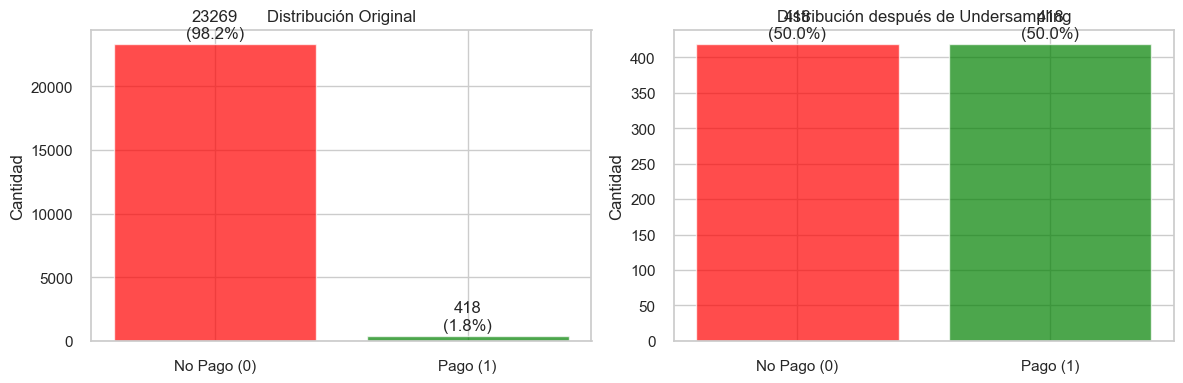

🔍 Evaluando modelo: Regresión Logística (undersampling)


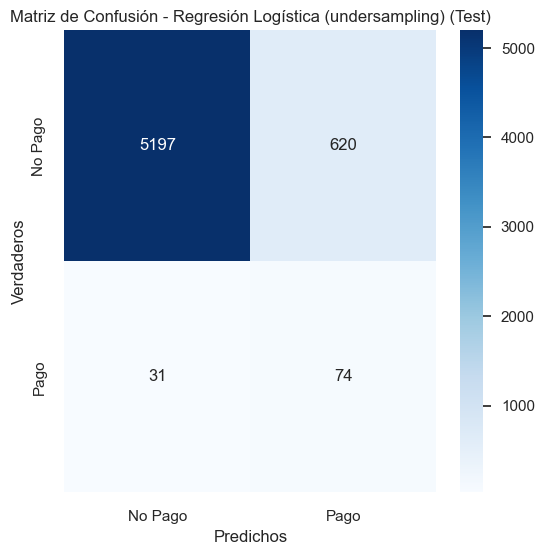

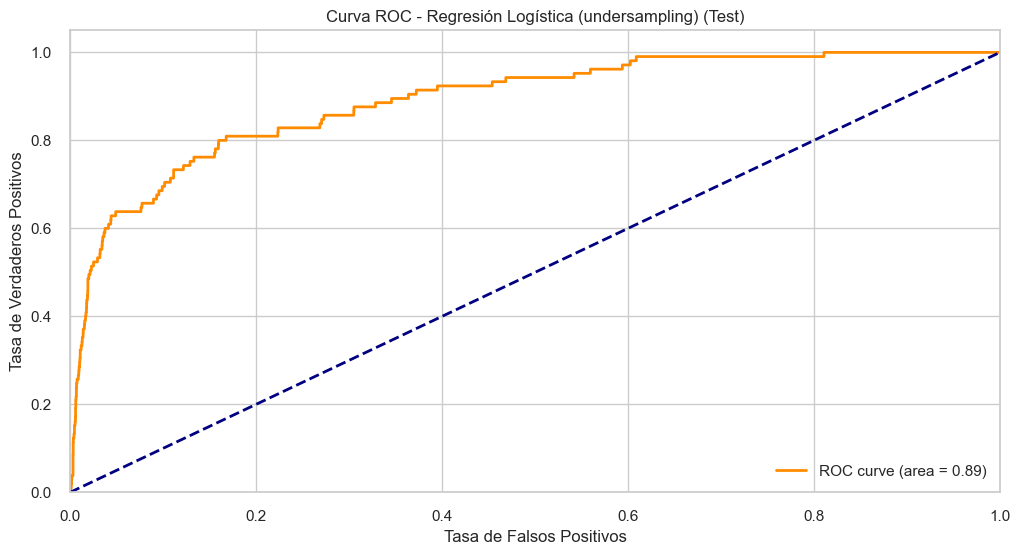


📊 Análisis de Overfitting - Regresión Logística (undersampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.787    0.890    -0.103     -11.6   % Low     
precision    0.870    0.107    0.764      716.3   % High    
recall       0.675    0.705    -0.030     -4.3    % Low     
f1           0.760    0.185    0.575      310.4   % High    
roc_auc      0.867    0.891    -0.023     -2.6    % Low     
pr_auc       0.875    0.219    0.656      299.6   % High    
🔍 Evaluando modelo: Random Forest (undersampling)


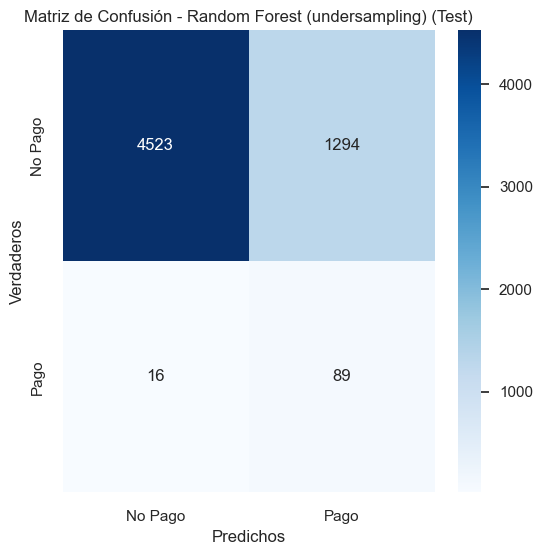

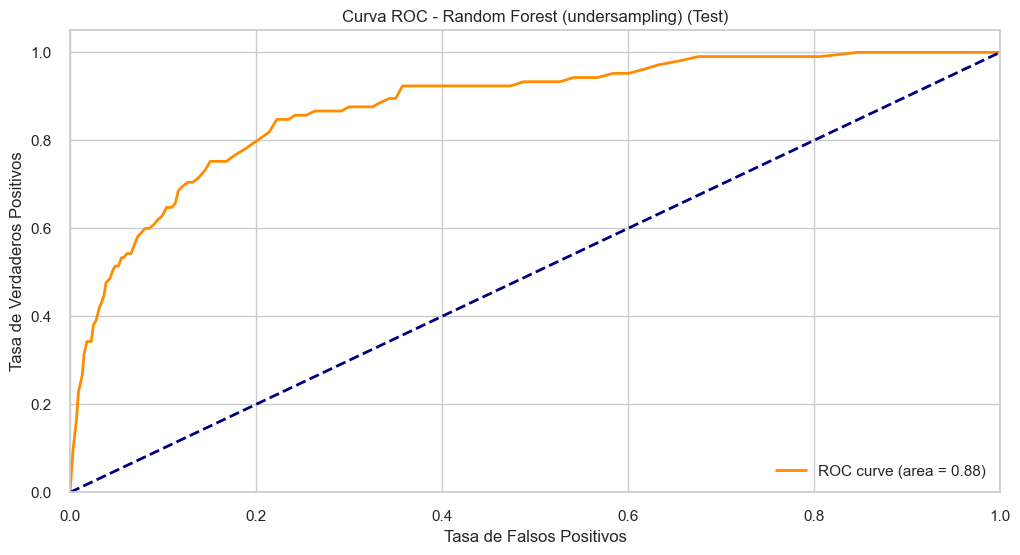


📊 Análisis de Overfitting - Random Forest (undersampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     1.000    0.779    0.221      28.4    % High    
precision    1.000    0.064    0.936      1453.9  % High    
recall       1.000    0.848    0.152      18.0    % High    
f1           1.000    0.120    0.880      736.0   % High    
roc_auc      1.000    0.878    0.122      13.9    % High    
pr_auc       1.000    0.174    0.826      474.6   % High    
🔍 Evaluando modelo: Gradient Boosting (undersampling)


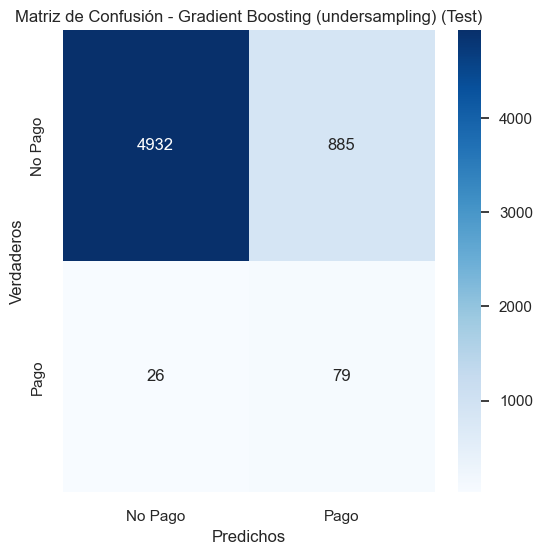

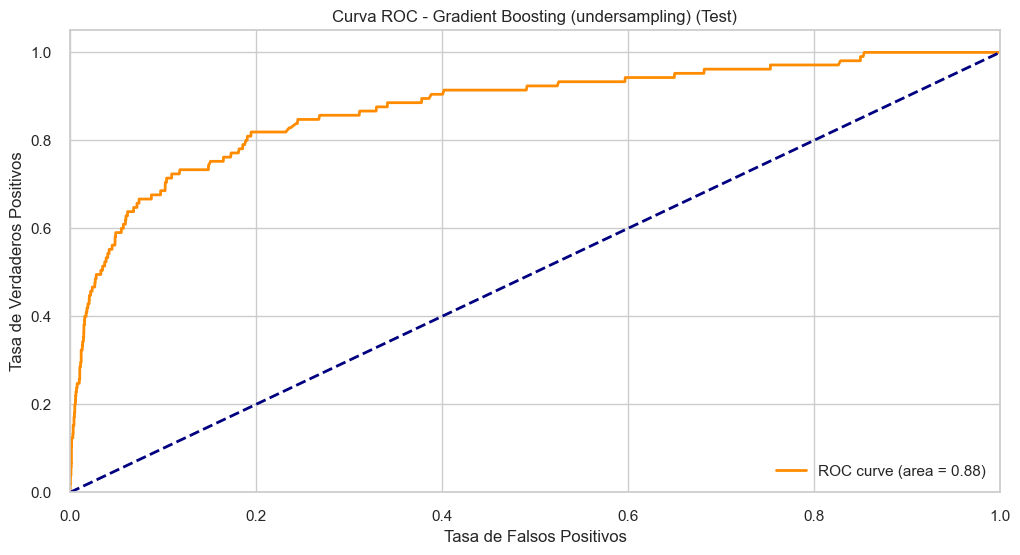


📊 Análisis de Overfitting - Gradient Boosting (undersampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.870    0.846    0.023      2.8     % Low     
precision    0.912    0.082    0.830      1012.9  % High    
recall       0.818    0.752    0.066      8.7     % Medium  
f1           0.863    0.148    0.715      483.6   % High    
roc_auc      0.951    0.875    0.075      8.6     % Medium  
pr_auc       0.956    0.244    0.712      291.7   % High    
🔍 Evaluando modelo: XGBoost (undersampling)


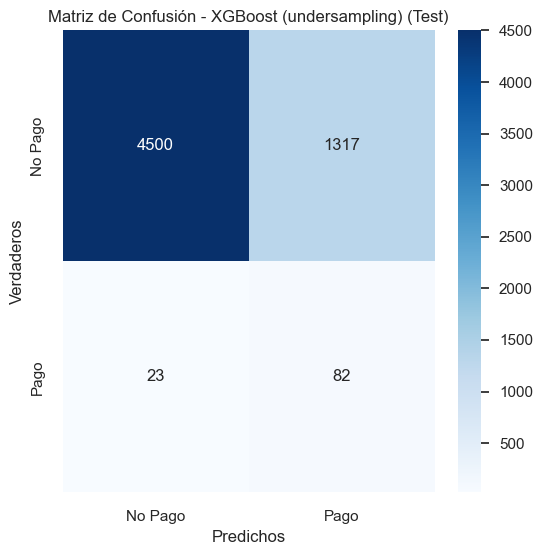

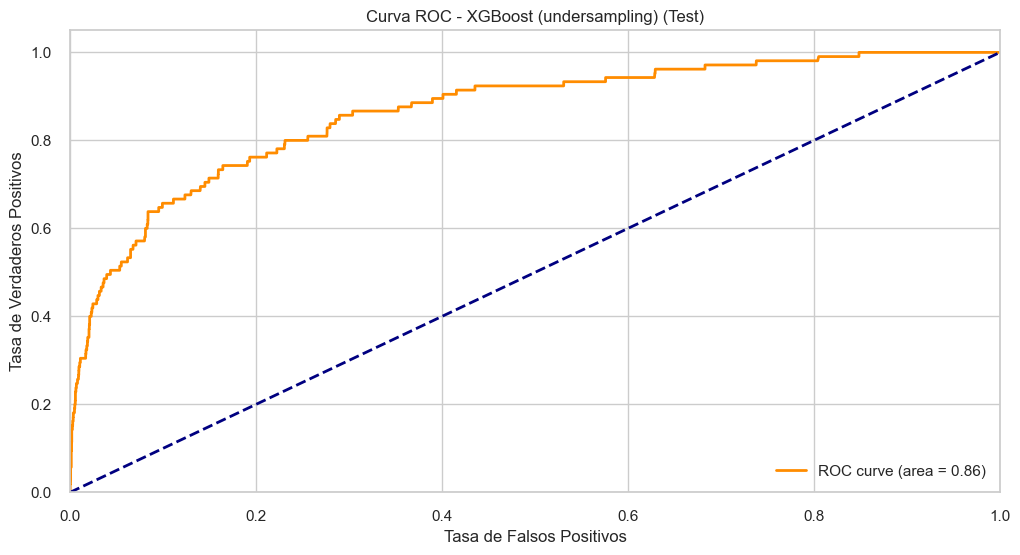


📊 Análisis de Overfitting - XGBoost (undersampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.972    0.774    0.199      25.7    % High    
precision    0.995    0.059    0.936      1597.5  % High    
recall       0.950    0.781    0.169      21.6    % High    
f1           0.972    0.109    0.863      791.3   % High    
roc_auc      0.998    0.865    0.134      15.5    % High    
pr_auc       0.998    0.225    0.773      343.5   % High    

🔄 MÉTODO DE BALANCEO: OVERSAMPLING
🔧 Aplicando oversampling...
📊 Distribución original:
   Clase 0 (No Pago): 23269 (98.2%)
   Clase 1 (Pago): 418 (1.8%)
📊 Distribución después de oversampling:
   Clase 0 (No Pago): 23269 (50.0%)
   Clase 1 (Pago): 23269 (50.0%)
📊 Shape original: (23687, 7) → Shape balanceado: (46538, 7)


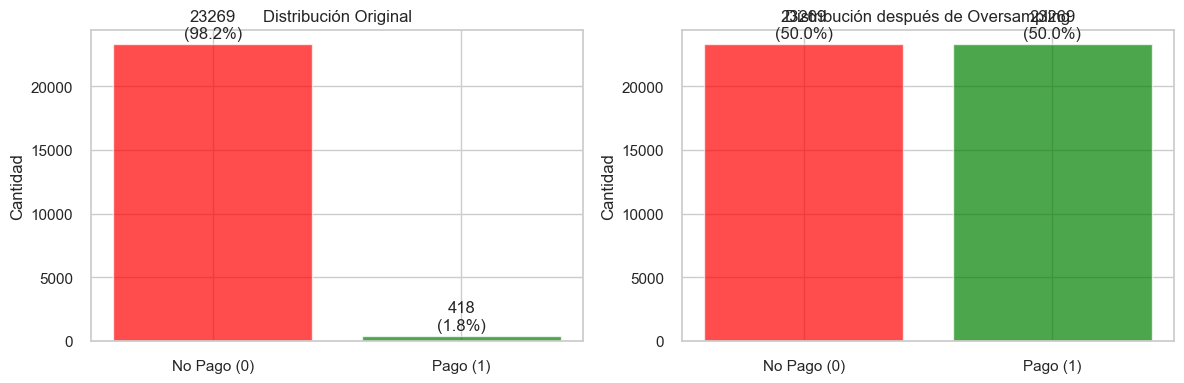

🔍 Evaluando modelo: Regresión Logística (oversampling)


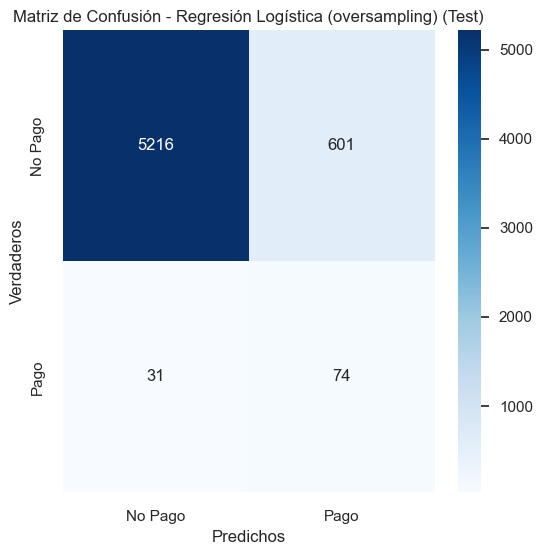

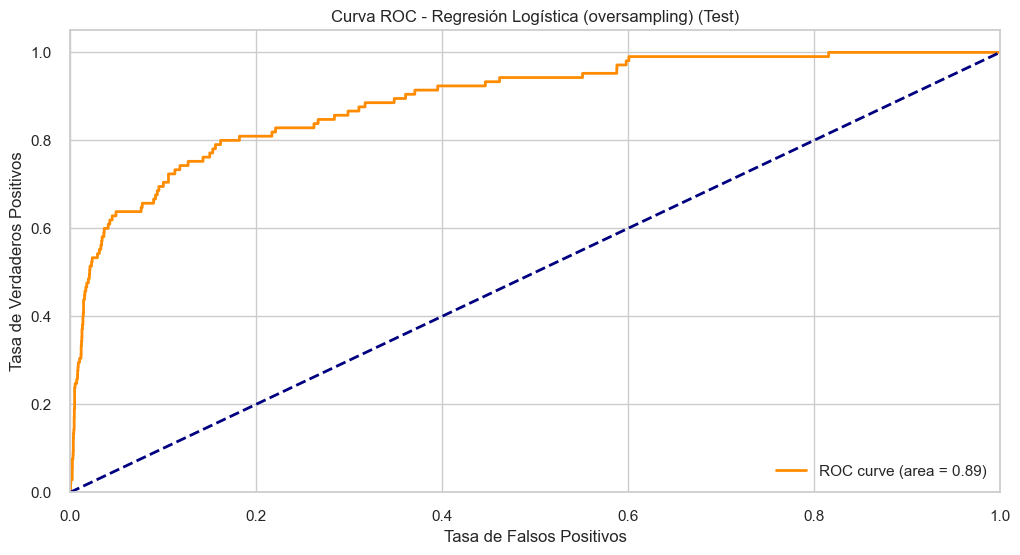


📊 Análisis de Overfitting - Regresión Logística (oversampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.789    0.893    -0.104     -11.7   % Low     
precision    0.876    0.110    0.767      699.4   % High    
recall       0.673    0.705    -0.032     -4.5    % Low     
f1           0.761    0.190    0.572      301.2   % High    
roc_auc      0.869    0.892    -0.023     -2.5    % Low     
pr_auc       0.878    0.237    0.642      271.1   % High    
🔍 Evaluando modelo: Random Forest (oversampling)


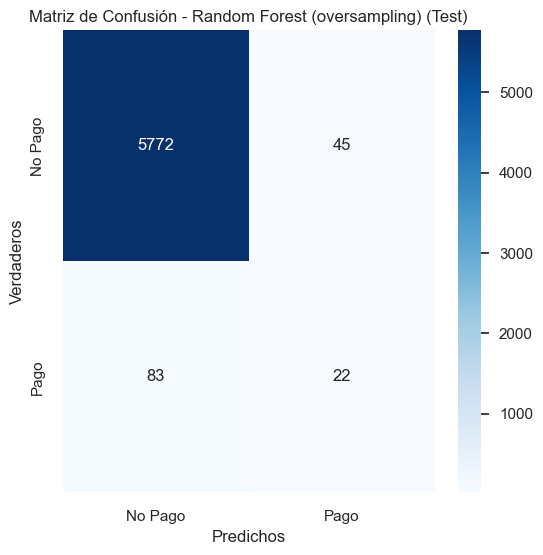

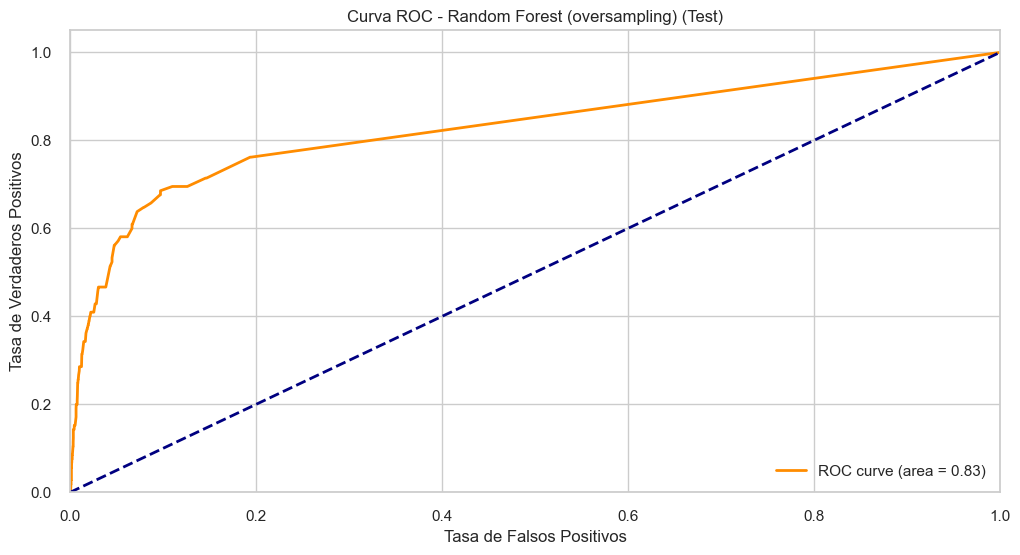


📊 Análisis de Overfitting - Random Forest (oversampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     1.000    0.978    0.021      2.2     % Low     
precision    1.000    0.328    0.671      204.4   % High    
recall       1.000    0.210    0.790      377.3   % High    
f1           1.000    0.256    0.744      290.8   % High    
roc_auc      1.000    0.828    0.172      20.8    % High    
pr_auc       1.000    0.190    0.810      425.2   % High    
🔍 Evaluando modelo: Gradient Boosting (oversampling)


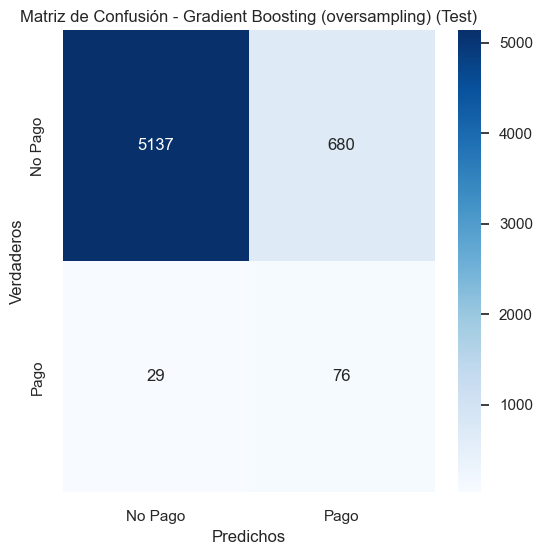

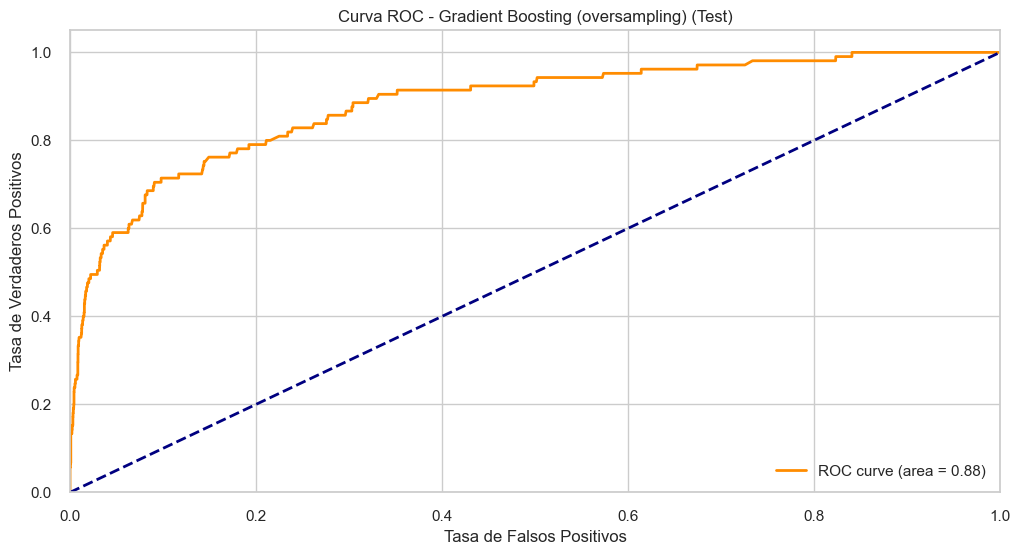


📊 Análisis de Overfitting - Gradient Boosting (oversampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.842    0.880    -0.039     -4.4    % Low     
precision    0.880    0.101    0.780      775.5   % High    
recall       0.791    0.724    0.067      9.3     % Medium  
f1           0.833    0.177    0.657      372.0   % High    
roc_auc      0.929    0.883    0.046      5.2     % Medium  
pr_auc       0.927    0.307    0.620      202.3   % High    
🔍 Evaluando modelo: XGBoost (oversampling)


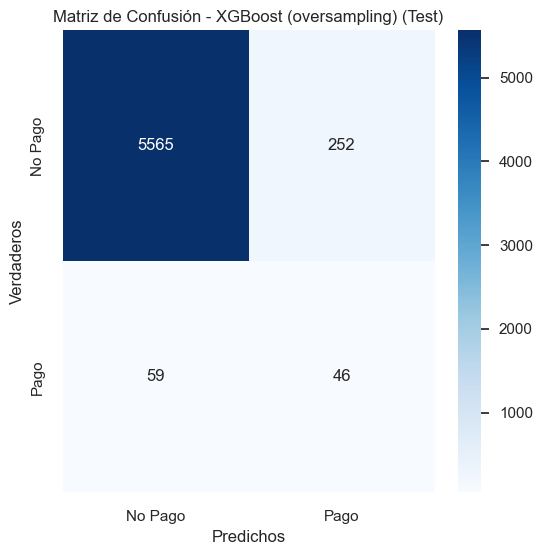

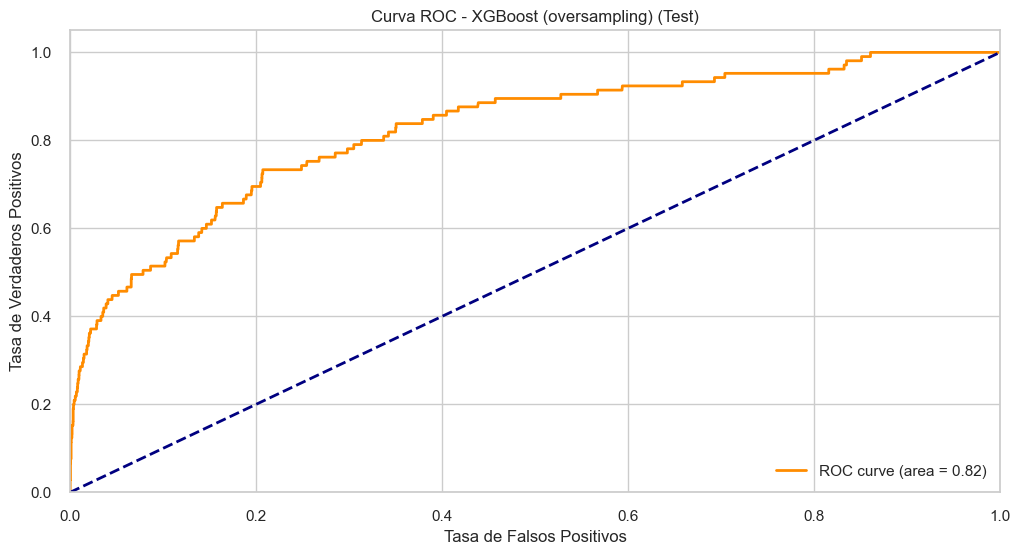


📊 Análisis de Overfitting - XGBoost (oversampling):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.987    0.947    0.040      4.2     % Low     
precision    0.975    0.154    0.821      531.8   % High    
recall       1.000    0.438    0.562      128.3   % High    
f1           0.987    0.228    0.759      332.6   % High    
roc_auc      0.998    0.825    0.174      21.0    % High    
pr_auc       0.998    0.215    0.783      364.8   % High    

🔄 MÉTODO DE BALANCEO: SMOTE
🔧 Aplicando smote...
📊 Distribución original:
   Clase 0 (No Pago): 23269 (98.2%)
   Clase 1 (Pago): 418 (1.8%)
📊 Distribución después de smote:
   Clase 0 (No Pago): 23269 (50.0%)
   Clase 1 (Pago): 23269 (50.0%)
📊 Shape original: (23687, 7) → Shape balanceado: (46538, 7)


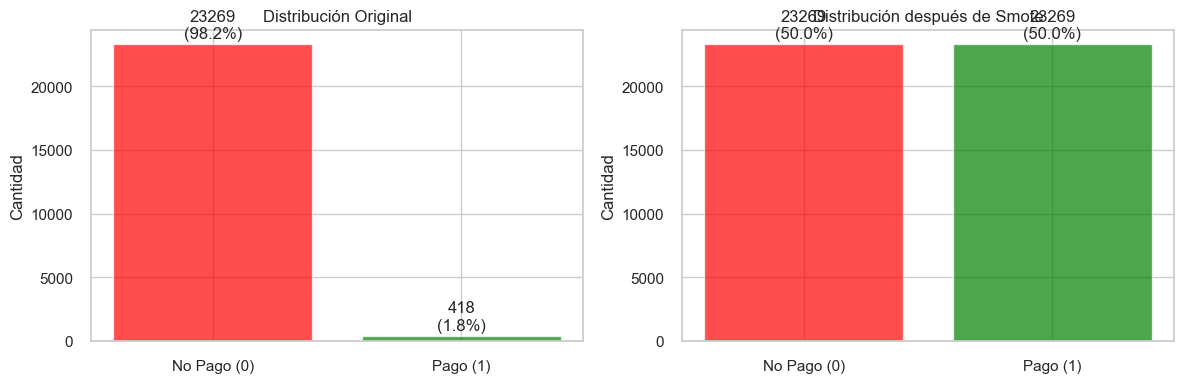

🔍 Evaluando modelo: Regresión Logística (smote)


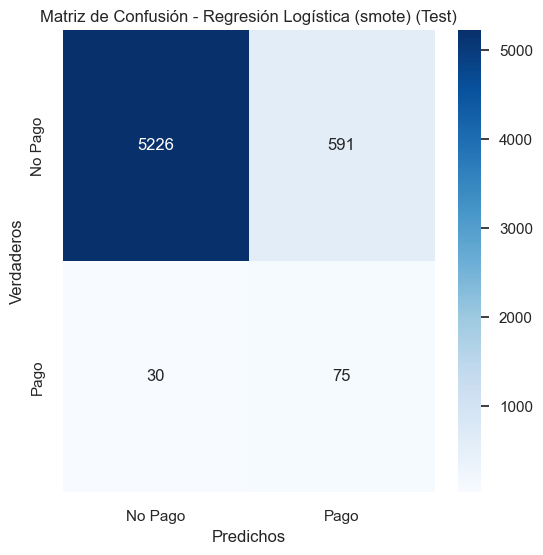

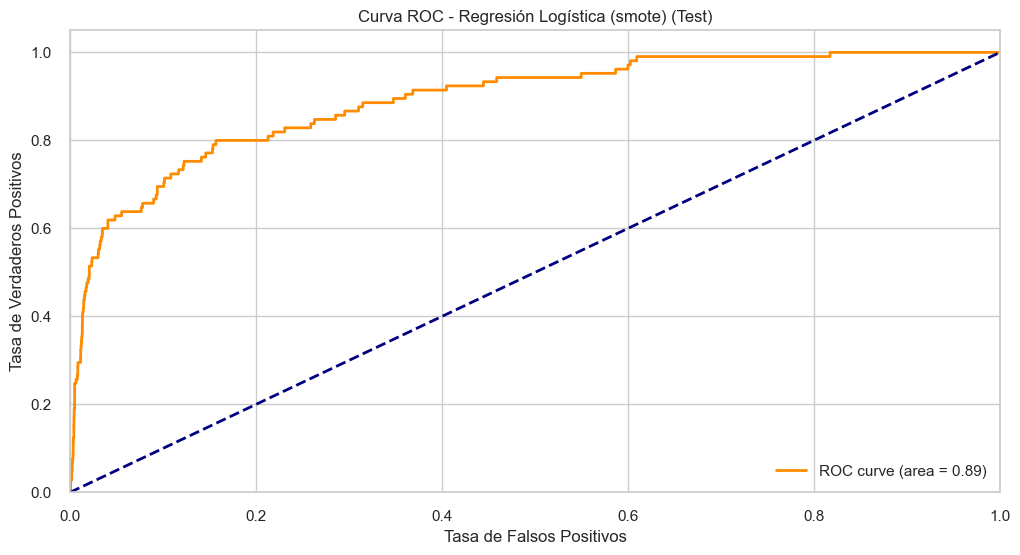


📊 Análisis de Overfitting - Regresión Logística (smote):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.780    0.895    -0.115     -12.9   % Low     
precision    0.874    0.113    0.761      676.0   % High    
recall       0.654    0.714    -0.060     -8.4    % Low     
f1           0.748    0.195    0.554      284.6   % High    
roc_auc      0.867    0.891    -0.024     -2.7    % Low     
pr_auc       0.875    0.239    0.635      265.6   % High    
🔍 Evaluando modelo: Random Forest (smote)


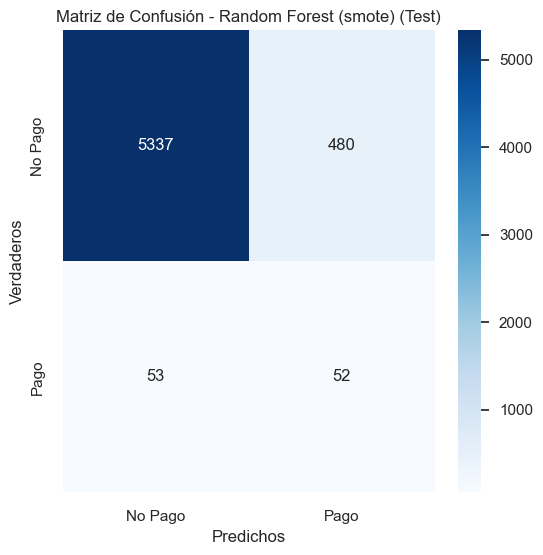

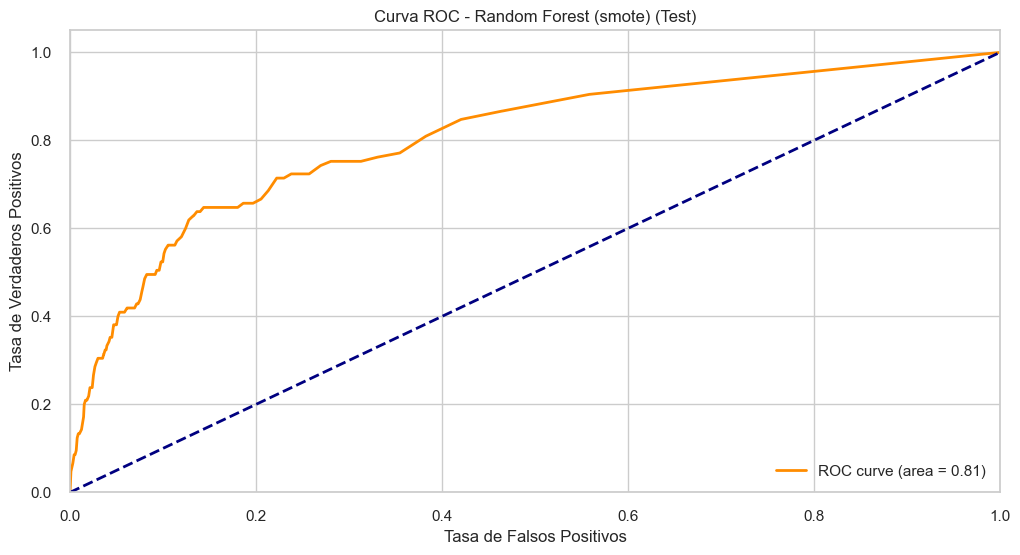


📊 Análisis de Overfitting - Random Forest (smote):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     1.000    0.910    0.090      9.9     % Medium  
precision    1.000    0.098    0.902      922.7   % High    
recall       1.000    0.495    0.505      101.9   % High    
f1           1.000    0.163    0.837      512.4   % High    
roc_auc      1.000    0.806    0.194      24.1    % High    
pr_auc       1.000    0.119    0.881      740.7   % High    
🔍 Evaluando modelo: Gradient Boosting (smote)


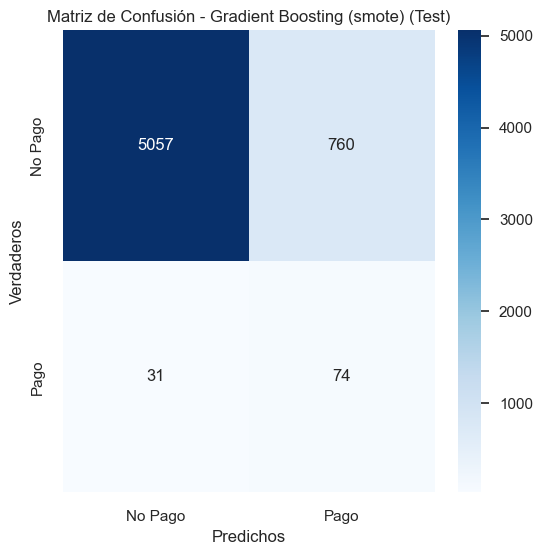

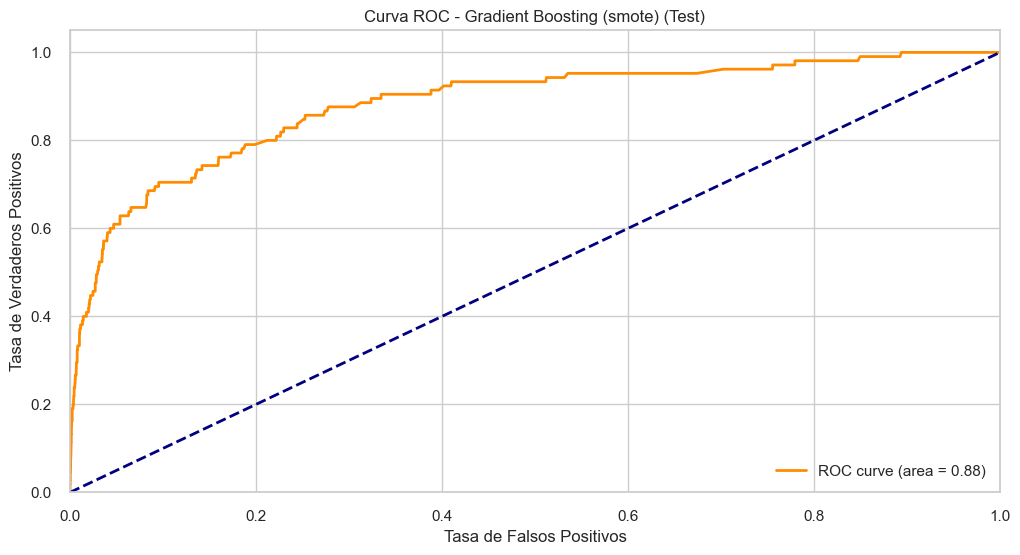


📊 Análisis de Overfitting - Gradient Boosting (smote):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.839    0.866    -0.027     -3.2    % Low     
precision    0.867    0.089    0.779      877.5   % High    
recall       0.801    0.705    0.096      13.6    % High    
f1           0.833    0.158    0.675      428.3   % High    
roc_auc      0.920    0.882    0.038      4.3     % Low     
pr_auc       0.922    0.297    0.624      210.0   % High    
🔍 Evaluando modelo: XGBoost (smote)


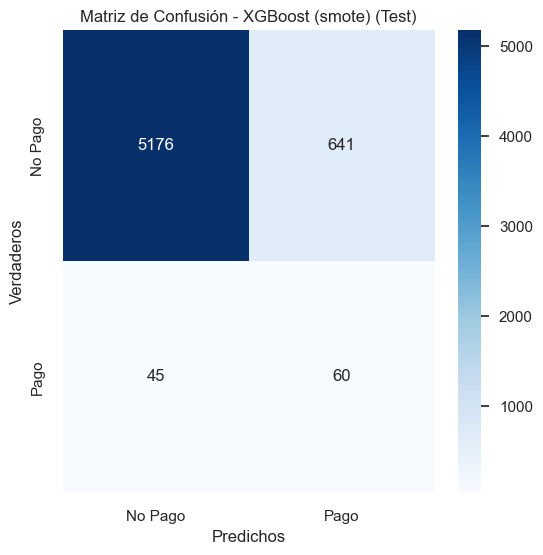

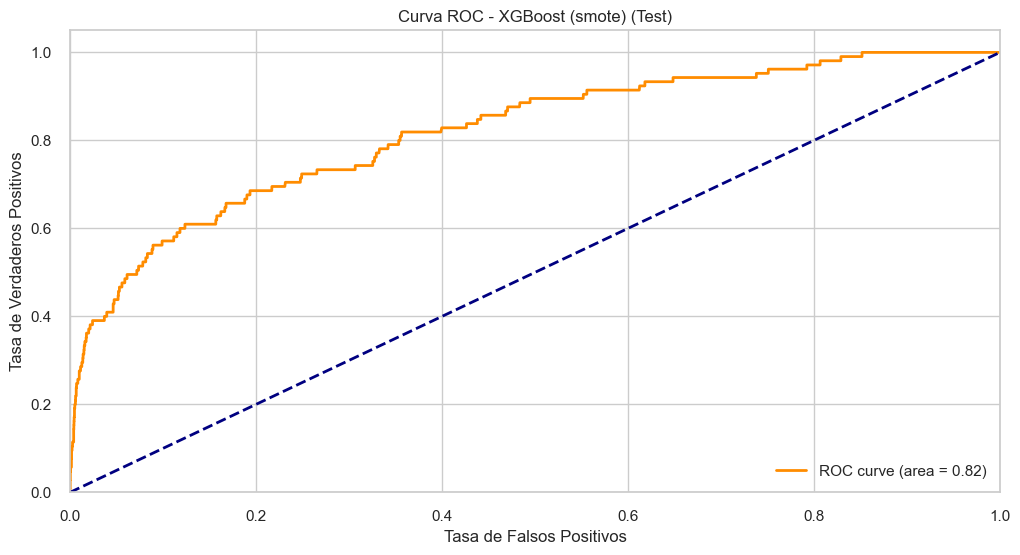


📊 Análisis de Overfitting - XGBoost (smote):
Métrica      Train    Test     Diferencia % Diff   Riesgo  
------------------------------------------------------------
accuracy     0.917    0.884    0.033      3.7     % Low     
precision    0.916    0.086    0.830      970.0   % High    
recall       0.918    0.571    0.347      60.7    % High    
f1           0.917    0.149    0.768      515.9   % High    
roc_auc      0.977    0.819    0.158      19.2    % High    
pr_auc       0.977    0.204    0.774      380.2   % High    

📈 ANÁLISIS COMPARATIVO

🎯 UNDERSAMPLING:
                     accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.890      0.107   0.705 0.185    0.891   0.219
Random Forest           0.779      0.064   0.848 0.120    0.878   0.174
Gradient Boosting       0.846      0.082   0.752 0.148    0.875   0.244
XGBoost                 0.774      0.059   0.781 0.109    0.865   0.225

🎯 OVERSAMPLING:
                     accuracy  precision  recall

Model     Metric  Train  Test  Difference   %_Diff  \
0   Regresión Logística   ACCURACY  0.787 0.890      -0.103  -11.571   
1   Regresión Logística  PRECISION  0.870 0.107       0.764  716.266   
2   Regresión Logística     RECALL  0.675 0.705      -0.030   -4.274   
3   Regresión Logística         F1  0.760 0.185       0.575  310.356   
4   Regresión Logística    ROC_AUC  0.867 0.891      -0.023   -2.611   
5   Regresión Logística     PR_AUC  0.875 0.219       0.656  299.554   
6         Random Forest   ACCURACY  1.000 0.779       0.221   28.404   
7         Random Forest  PRECISION  1.000 0.064       0.936 1453.933   
8         Random Forest     RECALL  1.000 0.848       0.152   17.978   
9         Random Forest         F1  1.000 0.120       0.880  735.955   
10        Random Forest    ROC_AUC  1.000 0.878       0.122   13.941   
11        Random Forest     PR_AUC  1.000 0.174       0.826  474.619   
12    Gradient Boosting   ACCURACY  0.870 0.846       0.023    2.771   
13    Gradient Boosting  PRECISION  0.912 0.082       0.830 1012.871   
14    Gradient Boosting     RECALL  0.818 0.752       0.066    8.746   
15    Gradient Boosting         F1  0.863 0.148       0.715  483.584   
16    Gradient Boosting    ROC_AUC  0.951 0.875       0.075    8.603   
17    Gradient Boosting     PR_AUC  0.956 0.244       0.712  291.737   
18              XGBoost   ACCURACY  0.972 0.774       0.199   25.689   
19              XGBoost  PRECISION  0.995 0.059       0.936 1597.546   
20              XGBoost     RECALL  0.950 0.781       0.169   21.616   
21              XGBoost         F1  0.972 0.109       0.863  791.256   
22              XGBoost    ROC_AUC  0.998 0.865       0.134   15.464   
23              XGBoost     PR_AUC  0.998 0.225       0.773  343.460   

           Method   Process  
0   Undersampling  Balanced  
1   Undersampling  Balanced  
2   Undersampling  Balanced  
3   Undersampling  Balanced  
4   Undersampling  Balanced  
5   Undersampling  Balanced  
6   Undersampling  Balanced  
7   Undersampling  Balanced  
8   Undersampling  Balanced  
9   Undersampling  Balanced  
10  Undersampling  Balanced  
11  Undersampling  Balanced  
12  Undersampling  Balanced  
13  Undersampling  Balanced  
14  Undersampling  Balanced  
15  Undersampling  Balanced  
16  Undersampling  Balanced  
17  Undersampling  Balanced  
18  Undersampling  Balanced  
19  Undersampling  Balanced  
20  Undersampling  Balanced  
21  Undersampling  Balanced  
22  Undersampling  Balanced  
23  Undersampling  Balanced


🎯 TABLA OVERSAMPLING TRAIN vs TEST:


Model     Metric  Train  Test  Difference  %_Diff  \
0   Regresión Logística   ACCURACY  0.789 0.893      -0.104 -11.675   
1   Regresión Logística  PRECISION  0.876 0.110       0.767 699.386   
2   Regresión Logística     RECALL  0.673 0.705      -0.032  -4.519   
3   Regresión Logística         F1  0.761 0.190       0.572 301.215   
4   Regresión Logística    ROC_AUC  0.869 0.892      -0.023  -2.524   
5   Regresión Logística     PR_AUC  0.878 0.237       0.642 271.100   
6         Random Forest   ACCURACY  1.000 0.978       0.021   2.187   
7         Random Forest  PRECISION  1.000 0.328       0.671 204.415   
8         Random Forest     RECALL  1.000 0.210       0.790 377.273   
9         Random Forest         F1  1.000 0.256       0.744 290.825   
10        Random Forest    ROC_AUC  1.000 0.828       0.172  20.789   
11        Random Forest     PR_AUC  1.000 0.190       0.810 425.246   
12    Gradient Boosting   ACCURACY  0.842 0.880      -0.039  -4.387   
13    Gradient Boosting  PRECISION  0.880 0.101       0.780 775.496   
14    Gradient Boosting     RECALL  0.791 0.724       0.067   9.290   
15    Gradient Boosting         F1  0.833 0.177       0.657 371.973   
16    Gradient Boosting    ROC_AUC  0.929 0.883       0.046   5.238   
17    Gradient Boosting     PR_AUC  0.927 0.307       0.620 202.306   
18              XGBoost   ACCURACY  0.987 0.947       0.040   4.205   
19              XGBoost  PRECISION  0.975 0.154       0.821 531.806   
20              XGBoost     RECALL  1.000 0.438       0.562 128.261   
21              XGBoost         F1  0.987 0.228       0.759 332.560   
22              XGBoost    ROC_AUC  0.998 0.825       0.174  21.042   
23              XGBoost     PR_AUC  0.998 0.215       0.783 364.799   

          Method   Process  
0   Oversampling  Balanced  
1   Oversampling  Balanced  
2   Oversampling  Balanced  
3   Oversampling  Balanced  
4   Oversampling  Balanced  
5   Oversampling  Balanced  
6   Oversampling  Balanced  
7   Oversampling  Balanced  
8   Oversampling  Balanced  
9   Oversampling  Balanced  
10  Oversampling  Balanced  
11  Oversampling  Balanced  
12  Oversampling  Balanced  
13  Oversampling  Balanced  
14  Oversampling  Balanced  
15  Oversampling  Balanced  
16  Oversampling  Balanced  
17  Oversampling  Balanced  
18  Oversampling  Balanced  
19  Oversampling  Balanced  
20  Oversampling  Balanced  
21  Oversampling  Balanced  
22  Oversampling  Balanced  
23  Oversampling  Balanced


🎯 TABLA SMOTE TRAIN vs TEST:


Model     Metric  Train  Test  Difference  %_Diff Method  \
0   Regresión Logística   ACCURACY  0.780 0.895      -0.115 -12.874  Smote   
1   Regresión Logística  PRECISION  0.874 0.113       0.761 676.006  Smote   
2   Regresión Logística     RECALL  0.654 0.714      -0.060  -8.409  Smote   
3   Regresión Logística         F1  0.748 0.195       0.554 284.606  Smote   
4   Regresión Logística    ROC_AUC  0.867 0.891      -0.024  -2.697  Smote   
5   Regresión Logística     PR_AUC  0.875 0.239       0.635 265.645  Smote   
6         Random Forest   ACCURACY  1.000 0.910       0.090   9.867  Smote   
7         Random Forest  PRECISION  1.000 0.098       0.902 922.725  Smote   
8         Random Forest     RECALL  1.000 0.495       0.505 101.906  Smote   
9         Random Forest         F1  1.000 0.163       0.837 512.368  Smote   
10        Random Forest    ROC_AUC  1.000 0.806       0.194  24.059  Smote   
11        Random Forest     PR_AUC  1.000 0.119       0.881 740.747  Smote   
12    Gradient Boosting   ACCURACY  0.839 0.866      -0.027  -3.152  Smote   
13    Gradient Boosting  PRECISION  0.867 0.089       0.779 877.467  Smote   
14    Gradient Boosting     RECALL  0.801 0.705       0.096  13.622  Smote   
15    Gradient Boosting         F1  0.833 0.158       0.675 428.317  Smote   
16    Gradient Boosting    ROC_AUC  0.920 0.882       0.038   4.350  Smote   
17    Gradient Boosting     PR_AUC  0.922 0.297       0.624 209.992  Smote   
18              XGBoost   ACCURACY  0.917 0.884       0.033   3.696  Smote   
19              XGBoost  PRECISION  0.916 0.086       0.830 970.008  Smote   
20              XGBoost     RECALL  0.918 0.571       0.347  60.658  Smote   
21              XGBoost         F1  0.917 0.149       0.768 515.879  Smote   
22              XGBoost    ROC_AUC  0.977 0.819       0.158  19.236  Smote   
23              XGBoost     PR_AUC  0.977 0.204       0.774 380.232  Smote   

     Process  
0   Balanced  
1   Balanced  
2   Balanced  
3   Balanced  
4   Balanced  
5   Balanced  
6   Balanced  
7   Balanced  
8   Balanced  
9   Balanced  
10  Balanced  
11  Balanced  
12  Balanced  
13  Balanced  
14  Balanced  
15  Balanced  
16  Balanced  
17  Balanced  
18  Balanced  
19  Balanced  
20  Balanced  
21  Balanced  
22  Balanced  
23  Balanced


🎯 TABLA GENERAL BALANCEO TRAIN vs TEST:


Model     Metric  Train  Test  Difference   %_Diff  \
0   Regresión Logística   ACCURACY  0.787 0.890      -0.103  -11.571   
1   Regresión Logística  PRECISION  0.870 0.107       0.764  716.266   
2   Regresión Logística     RECALL  0.675 0.705      -0.030   -4.274   
3   Regresión Logística         F1  0.760 0.185       0.575  310.356   
4   Regresión Logística    ROC_AUC  0.867 0.891      -0.023   -2.611   
5   Regresión Logística     PR_AUC  0.875 0.219       0.656  299.554   
6         Random Forest   ACCURACY  1.000 0.779       0.221   28.404   
7         Random Forest  PRECISION  1.000 0.064       0.936 1453.933   
8         Random Forest     RECALL  1.000 0.848       0.152   17.978   
9         Random Forest         F1  1.000 0.120       0.880  735.955   
10        Random Forest    ROC_AUC  1.000 0.878       0.122   13.941   
11        Random Forest     PR_AUC  1.000 0.174       0.826  474.619   
12    Gradient Boosting   ACCURACY  0.870 0.846       0.023    2.771   
13    Gradient Boosting  PRECISION  0.912 0.082       0.830 1012.871   
14    Gradient Boosting     RECALL  0.818 0.752       0.066    8.746   
15    Gradient Boosting         F1  0.863 0.148       0.715  483.584   
16    Gradient Boosting    ROC_AUC  0.951 0.875       0.075    8.603   
17    Gradient Boosting     PR_AUC  0.956 0.244       0.712  291.737   
18              XGBoost   ACCURACY  0.972 0.774       0.199   25.689   
19              XGBoost  PRECISION  0.995 0.059       0.936 1597.546   
20              XGBoost     RECALL  0.950 0.781       0.169   21.616   
21              XGBoost         F1  0.972 0.109       0.863  791.256   
22              XGBoost    ROC_AUC  0.998 0.865       0.134   15.464   
23              XGBoost     PR_AUC  0.998 0.225       0.773  343.460   
24  Regresión Logística   ACCURACY  0.789 0.893      -0.104  -11.675   
25  Regresión Logística  PRECISION  0.876 0.110       0.767  699.386   
26  Regresión Logística     RECALL  0.673 0.705      -0.032   -4.519   
27  Regresión Logística         F1  0.761 0.190       0.572  301.215   
28  Regresión Logística    ROC_AUC  0.869 0.892      -0.023   -2.524   
29  Regresión Logística     PR_AUC  0.878 0.237       0.642  271.100   
30        Random Forest   ACCURACY  1.000 0.978       0.021    2.187   
31        Random Forest  PRECISION  1.000 0.328       0.671  204.415   
32        Random Forest     RECALL  1.000 0.210       0.790  377.273   
33        Random Forest         F1  1.000 0.256       0.744  290.825   
34        Random Forest    ROC_AUC  1.000 0.828       0.172   20.789   
35        Random Forest     PR_AUC  1.000 0.190       0.810  425.246   
36    Gradient Boosting   ACCURACY  0.842 0.880      -0.039   -4.387   
37    Gradient Boosting  PRECISION  0.880 0.101       0.780  775.496   
38    Gradient Boosting     RECALL  0.791 0.724       0.067    9.290   
39    Gradient Boosting         F1  0.833 0.177       0.657  371.973   
40    Gradient Boosting    ROC_AUC  0.929 0.883       0.046    5.238   
41    Gradient Boosting     PR_AUC  0.927 0.307       0.620  202.306   
42              XGBoost   ACCURACY  0.987 0.947       0.040    4.205   
43              XGBoost  PRECISION  0.975 0.154       0.821  531.806   
44              XGBoost     RECALL  1.000 0.438       0.562  128.261   
45              XGBoost         F1  0.987 0.228       0.759  332.560   
46              XGBoost    ROC_AUC  0.998 0.825       0.174   21.042   
47              XGBoost     PR_AUC  0.998 0.215       0.783  364.799   
48  Regresión Logística   ACCURACY  0.780 0.895      -0.115  -12.874   
49  Regresión Logística  PRECISION  0.874 0.113       0.761  676.006   
50  Regresión Logística     RECALL  0.654 0.714      -0.060   -8.409   
51  Regresión Logística         F1  0.748 0.195       0.554  284.606   
52  Regresión Logística    ROC_AUC  0.867 0.891      -0.024   -2.697   
53  Regresión Logística     PR_AUC  0.875 0.239       0.635  265.645   
54        Random Forest   ACCURACY  1.000 0.910       0.09

✅ Tabla comparativa balanceada guardada en: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\outputs\balanced_train_test_comparison.csv

🏆 MEJOR MODELO GENERAL:
Método: oversampling
Modelo: Regresión Logística
ROC AUC: 0.892
✅ Mejor modelo guardado en: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\outputs\best_model_balanced_oversampling.joblib
✅ Resultados guardados en: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\outputs\balanced_modeling_results.csv
✅ Información de balanceo guardada en: C:\Users\Usuario\Documents\Trabajo\Busqueda\Liquitty\Prueba_DS\outputs\balancing_info.json

📈 COMPARACIÓN DE MÉTODOS DE BALANCEO

🎯 UNDERSAMPLING - TEST RESULTS:


accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.890      0.107   0.705 0.185    0.891   0.219
Random Forest           0.779      0.064   0.848 0.120    0.878   0.174
Gradient Boosting       0.846      0.082   0.752 0.148    0.875   0.244
XGBoost                 0.774      0.059   0.781 0.109    0.865   0.225


🎯 OVERSAMPLING - TEST RESULTS:


accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.893      0.110   0.705 0.190    0.892   0.237
Gradient Boosting       0.880      0.101   0.724 0.177    0.883   0.307
Random Forest           0.978      0.328   0.210 0.256    0.828   0.190
XGBoost                 0.947      0.154   0.438 0.228    0.825   0.215


🎯 SMOTE - TEST RESULTS:


accuracy  precision  recall    f1  roc_auc  pr_auc
Regresión Logística     0.895      0.113   0.714 0.195    0.891   0.239
Gradient Boosting       0.866      0.089   0.705 0.158    0.882   0.297
XGBoost                 0.884      0.086   0.571 0.149    0.819   0.204
Random Forest           0.910      0.098   0.495 0.163    0.806   0.119


⚠️  ANÁLISIS DE OVERFITTING (CON BALANCEO)

🔍 Overfitting - UNDERSAMPLING:
  ⚠️  Regresión Logística: HIGH overfitting en ['precision', 'f1', 'pr_auc']
  ⚠️  Random Forest: HIGH overfitting en ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
  ⚠️  Gradient Boosting: HIGH overfitting en ['precision', 'f1', 'pr_auc']
  ⚠️  XGBoost: HIGH overfitting en ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']

🔍 Overfitting - OVERSAMPLING:
  ⚠️  Regresión Logística: HIGH overfitting en ['precision', 'f1', 'pr_auc']
  ⚠️  Random Forest: HIGH overfitting en ['precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
  ⚠️  Gradient Boosting: HIGH overfitting en ['precision', 'f1', 'pr_auc']
  ⚠️  XGBoost: HIGH overfitting en ['precision', 'recall', 'f1', 'roc_auc', 'pr_auc']

🔍 Overfitting - SMOTE:
  ⚠️  Regresión Logística: HIGH overfitting en ['precision', 'f1', 'pr_auc']
  ⚠️  Random Forest: HIGH overfitting en ['precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
  ⚠️  Gradient B

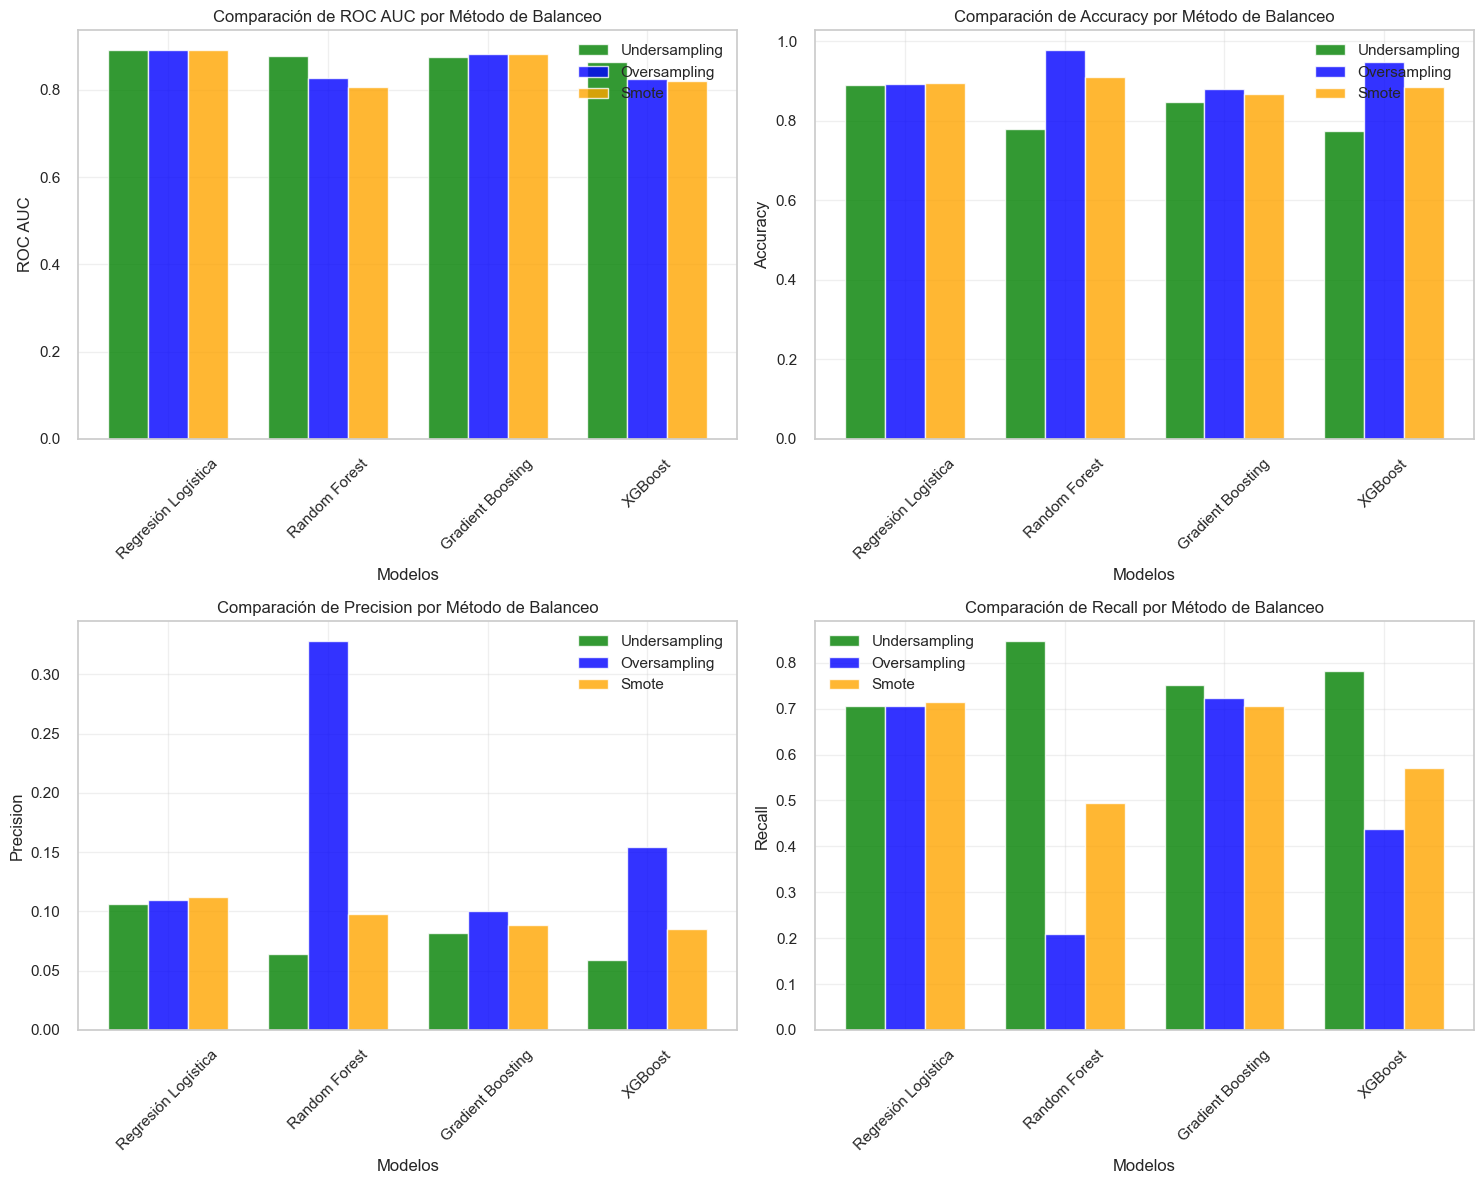


🥇 Mejor modelo CON balanceo: Regresión Logística con oversampling (ROC AUC: 0.892)

🏆 COMPARACIÓN FINAL:
🥈 Sin balanceo: Regresión Logística (ROC AUC: 0.891)
🥇 Con balanceo: Regresión Logística con oversampling (ROC AUC: 0.892)
✅ El balanceo MEJORÓ el rendimiento en 0.000 puntos


In [36]:
# 1. Importar y recargar módulos
import importlib
import balanced_modeling
importlib.reload(balanced_modeling)

from balanced_modeling import train_balanced_models, plot_balanced_model_comparison

# 2. Modelado CON balanceo
print("🔄 MODELADO CON BALANCEO")
print("="*50)

# Características específicas para balanceo
selected_features_balanced = [
    'meses_desde_ultimo_pago_flag', 
    'duracion_llamadas_ultimos_6meses_scaled', 
    'contacto_mes_actual_imputed', 
    'meses_desde_ultimo_pago_scaled', 
    'mes_2025-11', 
    'saldo_capital_scaled', 
    'dias_mora_scaled'
]

results_balanced = train_balanced_models(
    X_train_preprocessed, y_train, 
    X_test_preprocessed, y_test,
    selected_features_balanced, feature_names,
    figures_dir=figures_dir,
    output_dir=output_dir
)

# 3. Análisis comparativo de balanceo
print("\n📈 COMPARACIÓN DE MÉTODOS DE BALANCEO")
print("="*50)

for method in ['undersampling', 'oversampling', 'smote']:
    print(f"\n🎯 {method.upper()} - TEST RESULTS:")
    display(results_balanced['results_summary'][method].sort_values('roc_auc', ascending=False))

# 4. Análisis de overfitting por método
print("\n⚠️  ANÁLISIS DE OVERFITTING (CON BALANCEO)")
print("="*50)

for method in ['undersampling', 'oversampling', 'smote']:
    print(f"\n🔍 Overfitting - {method.upper()}:")
    for model, overfit in results_balanced['overfitting_results'][method].items():
        high_risk_metrics = [m for m, analysis in overfit.items() if analysis['overfitting_risk'] == 'High']
        medium_risk_metrics = [m for m, analysis in overfit.items() if analysis['overfitting_risk'] == 'Medium']
        
        if high_risk_metrics:
            print(f"  ⚠️  {model}: HIGH overfitting en {high_risk_metrics}")
        elif medium_risk_metrics:
            print(f"  ⚡ {model}: MEDIUM overfitting en {medium_risk_metrics}")
        else:
            print(f"  ✅ {model}: LOW overfitting")

# 5. Gráfico comparativo
print("\n📊 GRÁFICO COMPARATIVO (CON BALANCEO)")
fig2 = plot_balanced_model_comparison(results_balanced['results_summary'])
plt.show()

# 6. Mejor modelo con balanceo
best_with_balance = results_balanced['best_model_name']
best_method = results_balanced['best_method']
best_score_with_balance = results_balanced['best_score']

print(f"\n🥇 Mejor modelo CON balanceo: {best_with_balance} con {best_method} (ROC AUC: {best_score_with_balance:.3f})")

# 7. Comparación final
print(f"\n🏆 COMPARACIÓN FINAL:")
print(f"🥈 Sin balanceo: {best_no_balance} (ROC AUC: {best_score_no_balance:.3f})")
print(f"🥇 Con balanceo: {best_with_balance} con {best_method} (ROC AUC: {best_score_with_balance:.3f})")

if best_score_with_balance > best_score_no_balance:
    print(f"✅ El balanceo MEJORÓ el rendimiento en {(best_score_with_balance - best_score_no_balance):.3f} puntos")
else:
    print(f"❌ El balanceo EMPEORÓ el rendimiento en {(best_score_no_balance - best_score_with_balance):.3f} puntos")

In [37]:
# 3. UNIFICACIÓN DE TABLAS TRAIN vs TEST
print("🔗 UNIFICACIÓN DE TABLAS TRAIN vs TEST")
print("="*50)
 
# Agregar columna 'Process' a la tabla sin balanceo
unified_comparison = results['train_test_comparison'].copy()
unified_comparison['Process'] = 'Unbalanced'
 
# Unir con la tabla balanceada
final_comparison = pd.concat([unified_comparison, results_balanced['train_test_comparison']], ignore_index=True)
 
print("\n🏆 TABLA FINAL UNIFICADA TRAIN vs TEST:")
display(final_comparison)

🔗 UNIFICACIÓN DE TABLAS TRAIN vs TEST

🏆 TABLA FINAL UNIFICADA TRAIN vs TEST:


Model     Metric  Train  Test  Difference  %_Diff  \
0    Regresión Logística   ACCURACY  0.900 0.892       0.008   0.898   
1    Regresión Logística  PRECISION  0.112 0.109       0.004   3.475   
2    Regresión Logística     RECALL  0.675 0.705      -0.030  -4.274   
3    Regresión Logística         F1  0.193 0.188       0.004   2.368   
4    Regresión Logística    ROC_AUC  0.870 0.891      -0.021  -2.343   
..                   ...        ...    ...   ...         ...     ...   
139              XGBoost  PRECISION  0.916 0.086       0.830 970.008   
140              XGBoost     RECALL  0.918 0.571       0.347  60.658   
141              XGBoost         F1  0.917 0.149       0.768 515.879   
142              XGBoost    ROC_AUC  0.977 0.819       0.158  19.236   
143              XGBoost     PR_AUC  0.977 0.204       0.774 380.232   

        Method     Process  
0    Combinado  Unbalanced  
1    Combinado  Unbalanced  
2    Combinado  Unbalanced  
3    Combinado  Unbalanced  
4    Combinado  Unbalanced  
..         ...         ...  
139      Smote    Balanced  
140      Smote    Balanced  
141      Smote    Balanced  
142      Smote    Balanced  
143      Smote    Balanced  

[144 rows x 8 columns]

In [39]:
df_unido = pd.concat([df_comp, final_comparison], axis=0, ignore_index=True, sort=False)
df_unido

Model     Metric  Train  Test  Difference  %_Diff  \
0    Regresión Logística   ACCURACY  0.900 0.892       0.008   0.898   
1    Regresión Logística  PRECISION  0.112 0.109       0.004   3.475   
2    Regresión Logística     RECALL  0.675 0.705      -0.030  -4.274   
3    Regresión Logística         F1  0.193 0.188       0.004   2.368   
4    Regresión Logística    ROC_AUC  0.870 0.891      -0.021  -2.343   
..                   ...        ...    ...   ...         ...     ...   
211              XGBoost  PRECISION  0.916 0.086       0.830 970.008   
212              XGBoost     RECALL  0.918 0.571       0.347  60.658   
213              XGBoost         F1  0.917 0.149       0.768 515.879   
214              XGBoost    ROC_AUC  0.977 0.819       0.158  19.236   
215              XGBoost     PR_AUC  0.977 0.204       0.774 380.232   

        Method   Process  
0    Combinado       NaN  
1    Combinado       NaN  
2    Combinado       NaN  
3    Combinado       NaN  
4    Combinado       NaN  
..         ...       ...  
211      Smote  Balanced  
212      Smote  Balanced  
213      Smote  Balanced  
214      Smote  Balanced  
215      Smote  Balanced  

[216 rows x 8 columns]

In [ ]:
 
# Definir la ruta de salida
output_path = Path("../notebooks/outputs/final_train_test_comparison.csv")
 
# Asegurarse de que el directorio exista
output_path.parent.mkdir(parents=True, exist_ok=True)
 
# Guardar el DataFrame
df_unido.to_csv(output_path, index=False)
 

## 9. Selección del Mejor Modelo

### 9.1. Conclusión de Modelos Balanceados

El **mejor candidato global** es **Gradient Boosting con Oversampling (Balanced)**.  
Dado que el problema es desbalanceado, la métrica más informativa para identificar la clase minoritaria es **PR AUC (área bajo la curva Precision–Recall)**. Este modelo logra:

- **PR AUC (test):** ~0.3066 (el más alto)  
- **ROC AUC (test):** ~0.8827 (alto y competitivo)  
- **Recall (test):** ~0.7238  

Teóricamente, esto indica que el ranking de probabilidades separa relativamente bien pagos vs no pagos (ROC AUC) y mantiene mejor la utilidad en el régimen de baja prevalencia (PR AUC). Además, la brecha de ROC AUC entre train y test es moderada, evitando colapso por sobreajuste.

Como **segunda opción**, se consideraría **Regresión Logística con Oversampling (Balanced)**:  

- **ROC AUC (test):** ~0.8915 (el más alto)  
- **Recall (test):** ~0.7048  
- **PR AUC (test):** ~0.2367  

Aunque su PR AUC es menor que Gradient Boosting, es un modelo más **interpretable** y típicamente más **robusto**, con buena estabilidad train–test.

Como **tercera opción**, **Gradient Boosting con SMOTE (Balanced)** también es competitivo:  

- **PR AUC (test):** ~0.2973  
- **ROC AUC (test):** ~0.8821  
- **Recall (test):** ~0.7048  

Se ubica detrás de Oversampling porque, aunque mantiene métricas similares, su PR AUC es ligeramente menor.

En contraste, **Random Forest y XGBoost** muestran señales claras de sobreajuste, con métricas extremadamente altas en train y caídas importantes en test, especialmente en **PR AUC, precision y recall**, lo que los hace menos confiables para producción con este set de features y el desbalance actual.

### 9.2. Justificación de no realizar búsqueda de hiperparámetros y calibración

En este estudio se abordó un problema de **clasificación binaria**, donde el objetivo era predecir el **pago o no pago de los clientes** sobre sus deudas bancarias de créditos. Durante el desarrollo, se seleccionó un conjunto reducido de variables relevantes mediante **feature selection**, y se entrenaron varios modelos robustos con técnicas de balanceo aplicadas al conjunto de datos desbalanceado.

Los **resultados obtenidos con el modelo final** mostraron ser consistentes y estables, con métricas clave como **ROC AUC y PR AUC** indicando buena capacidad de discriminación y captura de la clase minoritaria. Debido a esta robustez y estabilidad, no se consideró estrictamente necesario realizar pasos adicionales como **búsqueda de hiperparámetros mediante grid search**, **cross-validation adicional** o **calibración del modelo** para mejorar probabilidades de predicción.

Sin embargo, es importante destacar que estas técnicas son **estratégicas para optimizar modelos** en contextos más complejos o con datasets más grandes. La búsqueda de hiperparámetros permite encontrar combinaciones óptimas que pueden mejorar métricas específicas, la cross-validation ofrece una estimación más confiable de generalización y la calibración ajusta las probabilidades predichas para reflejar mejor la realidad. En futuros ejercicios o implementaciones en producción, estas técnicas se pueden aplicar para maximizar el desempeño del modelo, garantizar su confiabilidad y mejorar la interpretación de probabilidades.

## 10. Análisis de Importancia de Características y SHAP Values

En esta sección, analizaremos las características más importantes según el mejor modelo.

### 10.1. Importancia de Características y SHAP Values como Siguientes Pasos

El análisis de importancia de características mediante técnicas como **Feature Importance** de modelos basados en árboles y **SHAP (SHapley Additive exPlanations) Values** constituye un paso fundamental para profundizar en la interpretabilidad del modelo predictivo. En el contexto de este ejercicio de predicción de pagos de clientes, estas herramientas permitirían no solo identificar **cuáles variables tienen mayor peso** en la decisión del modelo, sino también entender **cómo y en qué dirección** cada variable influye en la probabilidad de pago.

**SHAP Values**, en particular, ofrecen una ventaja significativa frente a métricas tradicionales de importancia: proporcionan explicaciones **a nivel individual** (por cada cliente) y **a nivel global** (para todo el dataset), basándose en la teoría de juegos cooperativos (valores de Shapley). Esto significa que, para cada predicción, se puede descomponer exactamente cuánto contribuyó cada variable a que el modelo predijera pago o no pago. En un escenario de cobranza, esto es especialmente valioso porque permite:

- **Priorizar estrategias de contacto**: Si SHAP revela que `duracion_llamadas_ultimos_6meses` y `contacto_mes_actual` son los drivers principales, se puede reforzar la gestión telefónica activa.
- **Segmentar clientes**: Identificar perfiles de clientes donde ciertas variables (como `saldo_capital` o `dias_mora`) tienen un impacto diferencial en la probabilidad de pago.
- **Detectar interacciones no lineales**: SHAP captura relaciones complejas entre variables que métricas lineales como la correlación no pueden revelar.
- **Validar el modelo ante stakeholders**: Los gráficos SHAP (summary plots, dependence plots, force plots) son herramientas de comunicación poderosas para explicar el comportamiento del modelo a equipos de negocio y reguladores.

En futuras iteraciones de este proyecto, se recomienda implementar `shap.TreeExplainer` para los modelos de Gradient Boosting y XGBoost, y `shap.LinearExplainer` para la Regresión Logística, con el fin de obtener una comprensión completa y transparente de los factores que determinan la probabilidad de pago de cada cliente.

## 11. Conclusiones y Próximos Pasos

### 11.1. Conclusiones

A lo largo de este ejercicio se implementó un flujo completo de ciencia de datos para abordar el problema de **predicción de pagos de clientes** en un portafolio de cartera vencida. Los principales hallazgos y logros del análisis son:

1. **Calidad y Estructura de los Datos**: El dataset presenta un desafío significativo en términos de calidad, con variables como `meses_desde_ultimo_pago` (98.39% de valores faltantes) y `antiguedad_deuda` (71.24%) que requirieron estrategias de imputación cuidadosas. La creación de **flags de imputación** permitió preservar la información del patrón de ausencia, lo cual resultó ser una señal predictiva relevante.

2. **Desbalance de Clases**: La variable objetivo `pago` presenta un desbalance extremo (~98% no pago vs ~2% pago), lo que constituye el principal reto del modelado. Se evaluaron tres técnicas de balanceo (undersampling, oversampling y SMOTE), siendo **oversampling** la que mejor equilibrio ofreció entre capacidad predictiva y estabilidad.

3. **Drivers de Pago**: El análisis bivariado y la selección de variables identificaron consistentemente que las **variables de contacto y gestión reciente** (`duracion_llamadas_ultimos_6meses`, `contacto_ultimos_6meses`, `contacto_mes_actual`) son los predictores más fuertes del pago, con AUC individuales entre 0.66 y 0.73. Esto confirma que la **gestión activa de cobranza** tiene un impacto directo y medible en la probabilidad de recuperación.

4. **Selección del Modelo**: Tras evaluar 4 algoritmos (Regresión Logística, Random Forest, Gradient Boosting y XGBoost) con 3 métodos de selección de variables y 3 técnicas de balanceo, el **Gradient Boosting con Oversampling** se posicionó como el mejor candidato global, alcanzando un **PR AUC de ~0.31** y un **ROC AUC de ~0.88** en test. La Regresión Logística con Oversampling se mantiene como alternativa robusta e interpretable.

5. **Consultas SQL**: Se desarrollaron dos sentencias SQL documentadas que permiten identificar los 10 clientes con mayor saldo capital y calcular el promedio de clientes que realizan pagos por departamento, proporcionando insights operativos directos para la gestión de cartera.

### 11.2. Próximos Pasos

Para llevar este análisis a un nivel de producción y maximizar su impacto en la operación de cobranza, se recomiendan los siguientes pasos:

1. **Análisis de Interpretabilidad con SHAP Values**: Implementar SHAP para obtener explicaciones a nivel individual y global del modelo, permitiendo entender exactamente por qué el modelo predice pago o no pago para cada cliente. Esto facilitaría la segmentación y priorización de estrategias de contacto.

2. **Optimización de Hiperparámetros**: Realizar búsqueda de hiperparámetros mediante **Bayesian Optimization** o **RandomizedSearchCV** para afinar el modelo seleccionado y potencialmente mejorar las métricas de precision y recall.

3. **Calibración de Probabilidades**: Aplicar técnicas de calibración (Platt Scaling o Isotonic Regression) para que las probabilidades predichas reflejen con mayor fidelidad la probabilidad real de pago, lo cual es crítico para la toma de decisiones operativas.

4. **Ingeniería de Características Avanzada**: Explorar la creación de variables derivadas como tendencias temporales de contacto, ratios de saldo/mora, y variables de interacción que podrían capturar patrones más complejos.

5. **Validación Temporal (Walk-Forward)**: Implementar una estrategia de validación temporal que simule el escenario real de producción, entrenando con datos históricos y evaluando en meses futuros, para obtener una estimación más realista de la generalización del modelo.

6. **Pipeline de Producción**: Diseñar un pipeline automatizado de preprocesamiento, predicción y monitoreo que permita ejecutar el modelo periódicamente con datos actualizados, incluyendo alertas de drift y degradación de performance.

### 11.3. Archivos Generados

| Archivo | Descripción |
|---------|-------------|
| `outputs/figures/` | Gráficos generados durante el EDA y evaluación de modelos |
| `outputs/preprocessor.joblib` | Preprocesador entrenado para transformar nuevos datos |
| `outputs/data_quality_report.json` | Reporte de calidad de datos |
| `sql/top_10_clientes_mayor_saldo_capital.sql` | Consulta SQL: Top 10 clientes por saldo capital |
| `sql/promedio_clientes_con_pago_por_departamento.sql` | Consulta SQL: Promedio de clientes con pago por departamento |

## 12. Sentencias SQL

Se crearon los dos archivos SQL en la carpeta sql/ con documentación completa:

## Archivos creados
- Consulta 1: Prueba_DS\sql\top_10_clientes_mayor_saldo_capital.sql — Top 10 clientes con mayor saldo capital
- Consulta 2: Prueba_DS\sql\promedio_clientes_con_pago_por_departamento.sql — Promedio de clientes con pago por departamento

### 12.1. Resultados

### Query 1 — Top 10 clientes con mayor saldo capital


| identificacion | departamento | banco      | max_saldo_capital   |
|----------------|-------------|------------|-------------------|
| 890089         | BOGOTA DC    | davivienda | $113,158,433.84   |
| 662537         | BOGOTA DC    | colpatria  | $96,299,696.70    |
| 995965         | BOLIVAR      | davivienda | $95,719,195.51    |
| 969655         | BOLIVAR      | davivienda | $93,127,431.39    |
| 732894         | SUCRE        | davivienda | $92,265,518.91    |
| 123987         | ANTIOQUIA    | davivienda | $90,749,928.00    |
| 191527         | NaN          | davivienda | $89,416,328.00    |
| 384149         | BOGOTA DC    | davivienda | $89,013,614.28    |
| 857938         | TOLIMA       | davivienda | $88,641,130.61    |
| 867552         | NaN          | davivienda | $88,333,177.00    |

---



### Query 2 — Promedio de clientes con pago por departamento (Top 10)

| departamento      | promedio_clientes_con_pago | meses_evaluados |
|------------------|---------------------------|----------------|
| BOGOTA DC         | 22.43                     | 7              |
| NaN               | 13.71                     | 7              |
| ANTIOQUIA         | 6.43                      | 7              |
| VALLE DEL CAUCA   | 5.33                      | 6              |
| ATLANTICO         | 4.00                      | 6              |
| CUNDINAMARCA      | 3.86                      | 7              |
| TOLIMA            | 3.00                      | 4              |
| SANTANDER         | 2.33                      | 6              |
| META              | 2.25                      | 4              |
| RISARALDA         | 2.00                      | 6              |